In [2]:
# Cell 1: Import required libraries
import base64
from io import BytesIO
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import zipfile
import json
import pandas as pd
import os
import seaborn as sns

In [3]:
# Cell 2: Data extraction functions
def extract_valid_results(jrzip_path):
    """Extract and validate results from JRZIP file"""
    def load_single_result(json_line):
        try:
            data = json.loads(json_line)
            # Check if this is a valid entry with required fields
            if (isinstance(data, dict) and 
                'metadata' in data and 
                'participant_id' in data['metadata']):
                return data
        except json.JSONDecodeError:
            return None
        return None

    valid_results = []
    with zipfile.ZipFile(jrzip_path, 'r') as zip_ref:
        for file_name in zip_ref.namelist():
            if file_name.endswith('.txt'):
                with zip_ref.open(file_name) as f:
                    content = f.read().decode('utf-8')
                    for line in content.split('\n'):
                        if line.strip():
                            result = load_single_result(line)
                            if result:
                                valid_results.append(result)
    
    print(f"Found {len(valid_results)} valid results")
    return valid_results

In [4]:
# Cell 3: DataFrame creation functions
def create_participant_df(valid_results):
    """Create participant info DataFrame"""
    participant_info = []
    for result in valid_results:
        info = {
            'participant_id': result['metadata']['participant_id'],
            'timestamp': result['metadata']['timestamp'],
            'filter_threshold': result['metadata']['parameters']['filter_parameters']['threshold'],
            'preservation_factor': result['metadata']['parameters']['filter_parameters']['preservation_factor'],
            'noise_reduction': result['metadata']['parameters']['filter_parameters']['noise_reduction_factor']
        }
        participant_info.append(info)
    return pd.DataFrame(participant_info).set_index('participant_id')

def create_training_df(valid_results):
    """Create training phase DataFrame"""
    training_data = []
    for result in valid_results:
        if isinstance(result.get('training_phase'), dict):
            training = {
                'participant_id': result['metadata']['participant_id'],
                'total_trials': result['training_phase']['summary']['total_trials'],
                'correct_trials': result['training_phase']['summary']['correct_trials'],
                'accuracy': result['training_phase']['summary']['accuracy_percentage'],
                'mean_rt': result['training_phase']['summary']['mean_rt']
            }
            training_data.append(training)
    return pd.DataFrame(training_data).set_index('participant_id')

def create_vviq_df(valid_results):
    """Create VVIQ DataFrame with attention check validation"""
    vviq_data = []
    for result in valid_results:
        participant_id = result['metadata']['participant_id']
        vviq_metadata = result['metadata'].get('vviq_data', {})
        
        # Check attention checks
        attention_checks = vviq_metadata.get('attention_check_passed', {})
        
        for eye_condition in ['eyes_open', 'eyes_closed']:
            responses = vviq_metadata.get(eye_condition, [])
            for response in responses:
                for item, rating in response.get('responses', {}).items():
                    vviq_data.append({
                        'participant_id': participant_id,
                        'condition': eye_condition,
                        'question_index': response.get('question_index'),
                        'item': item,
                        'rating': rating,
                        'attention_check_passed': attention_checks.get(eye_condition, False)
                    })
    return pd.DataFrame(vviq_data)

def create_caps_df(valid_results):
    """Create CAPS DataFrame"""
    caps_data = []
    for result in valid_results:
        participant_id = result['metadata']['participant_id']
        caps_responses = result['metadata'].get('caps_data', [])
        
        for response in caps_responses:
            caps_data.append({
                'participant_id': participant_id,
                'question_index': response.get('question_index'),
                'question_text': response.get('question_text'),
                'response': response.get('response'),
                'subscale': response.get('subscale')
            })
    return pd.DataFrame(caps_data)

def create_evolution_df(valid_results):
    """Create evolution DataFrame"""
    evolution_data = []
    for result in valid_results:
        participant_id = result['metadata']['participant_id']
        for entry in result['evolution_summary']:
            evolution_data.append({
                'participant_id': participant_id,
                'session': entry['session'],
                'generation': entry['generation'],
                'n_selections': len(entry['selected_parents'])
            })
    return pd.DataFrame(evolution_data)

In [5]:
# Cell 4: Analysis functions
def analyze_attention_checks(vviq_df):
    """Analyze VVIQ attention check performance"""
    attention_summary = vviq_df.groupby('participant_id')['attention_check_passed'].agg(['first', 'count'])
    attention_summary.columns = ['passed_check', 'total_responses']
    return attention_summary

def analyze_training_performance(training_df):
    """Analyze training phase performance"""
    performance_summary = training_df.agg({
        'accuracy': ['mean', 'std', 'min', 'max'],
        'mean_rt': ['mean', 'std']
    }).round(2)
    return performance_summary

In [6]:
# Cell 5: Usage example
#jrzip_path = "jatos_results_20241209_filtered_post5074.jrzip" #this one is without me and guido
jrzip_path = "jatos_results_20241209150149.jrzip" #this one is with  me and guido
valid_results = extract_valid_results(jrzip_path)

# Create all DataFrames
dfs = {
    'participants': create_participant_df(valid_results),
    'training': create_training_df(valid_results),
    'vviq': create_vviq_df(valid_results),
    'caps': create_caps_df(valid_results),
    'evolution': create_evolution_df(valid_results)
}

# Print basic info about each DataFrame
for name, df in dfs.items():
    print(f"\n{name} DataFrame shape:", df.shape)
    print(f"Columns:", df.columns.tolist())

# Analyze attention checks and training performance
attention_summary = analyze_attention_checks(dfs['vviq'])
training_summary = analyze_training_performance(dfs['training'])

print("\nVVIQ Attention Check Summary:")
print(attention_summary)
print("\nTraining Performance Summary:")
print(training_summary)

Found 21 valid results

participants DataFrame shape: (21, 4)
Columns: ['timestamp', 'filter_threshold', 'preservation_factor', 'noise_reduction']

training DataFrame shape: (18, 4)
Columns: ['total_trials', 'correct_trials', 'accuracy', 'mean_rt']

vviq DataFrame shape: (714, 6)
Columns: ['participant_id', 'condition', 'question_index', 'item', 'rating', 'attention_check_passed']

caps DataFrame shape: (672, 5)
Columns: ['participant_id', 'question_index', 'question_text', 'response', 'subscale']

evolution DataFrame shape: (294, 4)
Columns: ['participant_id', 'session', 'generation', 'n_selections']

VVIQ Attention Check Summary:
                passed_check  total_responses
participant_id                               
11893                  False               34
11929                   True               34
11974                   True               68
12040                   True               34
12049                  False               34
12109                   True          

In [7]:
# Cell 1: Improved attention check identification
def identify_failed_attention_checks(dfs):
    vviq_df = dfs['vviq']
    
    # Group by participant and ensure ALL attention checks are passed
    attention_status = vviq_df.groupby('participant_id')['attention_check_passed'].agg(
        lambda x: all(x)  # Must pass ALL attention checks
    )
    
    # Get participants who failed any attention check
    failed_participants = attention_status[~attention_status].index.tolist()
    
    print("\nAttention check status per participant:")
    print(attention_status)
    print(f"\nFound {len(failed_participants)} participants who failed at least one attention check")
    print("Failed Participant IDs:", failed_participants)
    
    return failed_participants

# Cell 2: Separate naughty participants
def separate_naughty_participants(dfs, failed_participants):
    naughty_dfs = {}
    clean_dfs = {}
    
    for name, df in dfs.items():
        if df.index.name == 'participant_id':
            # For DataFrames indexed by participant_id
            naughty_dfs[name] = df.loc[df.index.isin(failed_participants)]
            clean_dfs[name] = df.loc[~df.index.isin(failed_participants)]
        else:
            # For DataFrames with participant_id as a column
            naughty_dfs[name] = df[df['participant_id'].isin(failed_participants)]
            clean_dfs[name] = df[~df['participant_id'].isin(failed_participants)]
    
    # Print summary of removed participants
    print("\nParticipants removed from analysis:")
    for participant in failed_participants:
        print(f"\nParticipant {participant}:")
        for name, df in naughty_dfs.items():
            if df.index.name == 'participant_id' and participant in df.index:
                print(f"- Found in {name} DataFrame")
    
    return clean_dfs, naughty_dfs

# Cell 3: Usage
failed_participants = identify_failed_attention_checks(dfs)
clean_dfs, naughty_dfs = separate_naughty_participants(dfs, failed_participants)

# Cell 4: Verification
print("\nVerification of clean DataFrames:")
for name, df in clean_dfs.items():
    if df.index.name == 'participant_id':
        print(f"\n{name} remaining participants:", len(df))
    else:
        print(f"\n{name} remaining entries:", len(df))



Attention check status per participant:
participant_id
11893    False
11929     True
11974     True
12040     True
12049    False
12109     True
12136    False
12295     True
12334     True
12346     True
12361     True
12382     True
12511     True
13153     True
13186     True
13615     True
4702     False
4737      True
4739      True
Name: attention_check_passed, dtype: bool

Found 4 participants who failed at least one attention check
Failed Participant IDs: ['11893', '12049', '12136', '4702']

Participants removed from analysis:

Participant 11893:
- Found in participants DataFrame
- Found in training DataFrame

Participant 12049:
- Found in participants DataFrame
- Found in training DataFrame

Participant 12136:
- Found in participants DataFrame
- Found in training DataFrame

Participant 4702:
- Found in participants DataFrame

Verification of clean DataFrames:

participants remaining participants: 16

training remaining participants: 14

vviq remaining entries: 544

caps remai

In [8]:
clean_dfs

{'participants':                                timestamp  filter_threshold  \
 participant_id                                               
 4737            2024-12-02T10:22:55.867Z                30   
 4739            2024-12-02T13:31:29.290Z                30   
 12109           2024-12-07T16:31:10.113Z                30   
 11974           2024-12-07T16:17:23.921Z                30   
 13615           2024-12-07T16:54:23.025Z                30   
 12040           2024-12-07T18:14:34.987Z                30   
 13186           2024-12-07T17:54:49.562Z                30   
 12361           2024-12-07T18:36:51.983Z                30   
 12346           2024-12-07T20:23:49.761Z                30   
 12382           2024-12-07T20:43:21.141Z                30   
 12511           2024-12-08T15:25:15.235Z                30   
 12334           2024-12-08T15:18:43.550Z                30   
 12295           2024-12-08T15:30:28.130Z                30   
 11974           2024-12-08T20:22:14.96

Training Data Summary:
                total_trials  correct_trials  accuracy       mean_rt
participant_id                                                      
12109                    227              10       100  22755.707317
11974                    227               8        80   5460.162439
13615                    227               0         0   8877.292195
12040                    227               6        60  15302.214634
13186                    227               9        90   7630.151220
12361                    227               8        80   8150.431220
12346                    227               1        10   8482.474634
12382                    227              10       100  13331.415610
12511                    227               7        70  14460.180000
12334                    227              10       100   8836.107317
12295                    227               8        80   6639.611220
11974                    227               8        80   2826.913659
13153      

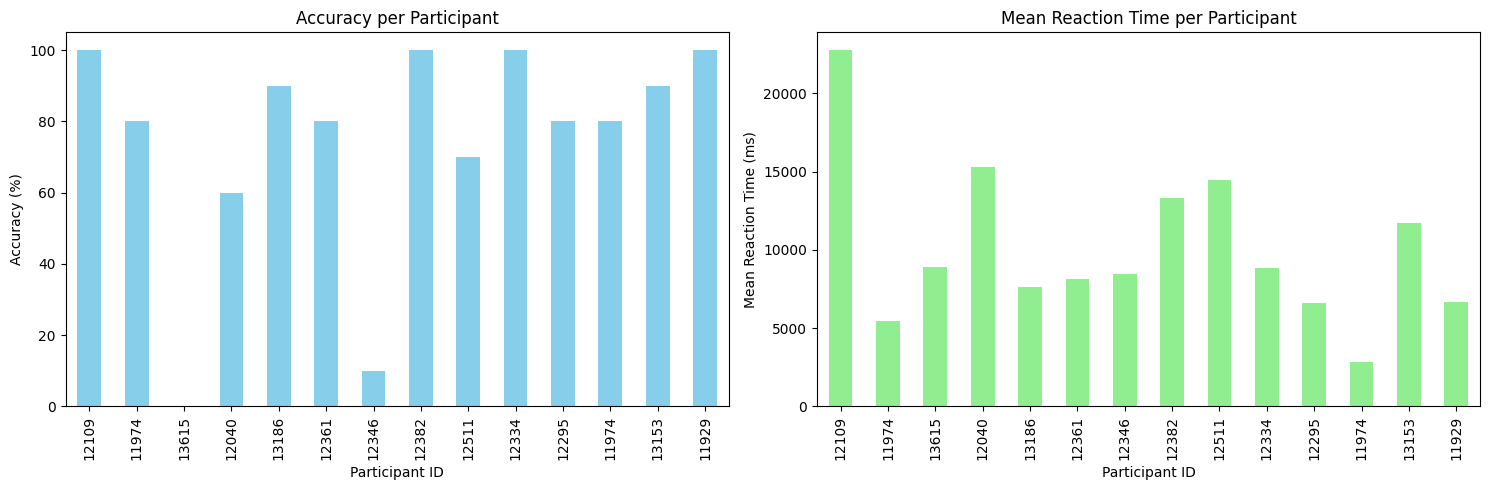

In [9]:
# Display training data summary
print("Training Data Summary:")
print(clean_dfs['training'])

# Create visualizations
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy plot
clean_dfs['training']['accuracy'].plot(kind='bar', ax=ax1, color='skyblue')
ax1.set_title('Accuracy per Participant')
ax1.set_ylabel('Accuracy (%)')
ax1.set_xlabel('Participant ID')

# Reaction time plot
clean_dfs['training']['mean_rt'].plot(kind='bar', ax=ax2, color='lightgreen')
ax2.set_title('Mean Reaction Time per Participant')
ax2.set_ylabel('Mean Reaction Time (ms)')
ax2.set_xlabel('Participant ID')

plt.tight_layout()
plt.show()


In [10]:
 # Cell 1: Helper functions for image processing
def decode_base64_image(base64_string_or_list):
    if isinstance(base64_string_or_list, list):
        base64_string = base64_string_or_list[0]
    else:
        base64_string = base64_string_or_list
    
    try:
        img_data = base64.b64decode(base64_string.split(',')[1])
    except IndexError:
        img_data = base64.b64decode(base64_string)
    
    return Image.open(BytesIO(img_data))

def create_composite_image(images):
    if not images:
        return np.zeros((16, 16), dtype=np.uint8)
    np_images = [np.array(img.convert('L').resize((16, 16))) for img in images]
    mean_image = np.mean(np.stack(np_images), axis=0)
    return mean_image.astype(np.uint8)

# Cell 3: Visualization function
def plot_participant_sessions(participant_data, participant_id):
    for session, session_data in participant_data.items():
        generations = sorted(session_data.keys())
        n_gens = len(generations)
        
        if n_gens == 0:
            print(f"No generations found for Participant {participant_id}, Session {session}")
            continue
            
        fig, axes = plt.subplots(1, n_gens, figsize=(3*n_gens, 3))
        if n_gens == 1:
            axes = [axes]
        
        for idx, gen in enumerate(generations):
            gen_images = []
            for img_base64 in session_data[gen]['selected']:
                try:
                    img = decode_base64_image(img_base64)
                    gen_images.append(img)
                except Exception as e:
                    print(f"Error processing image for Participant {participant_id}, Session {session}, Generation {gen}: {str(e)}")
                    continue
                    
            if gen_images:
                composite = create_composite_image(gen_images)
                axes[idx].imshow(composite, cmap='gray')
                axes[idx].axis('off')
                axes[idx].set_title(f'Gen {gen}')
        
        plt.suptitle(f'Participant {participant_id} - Session {session}')
        plt.tight_layout()
        plt.show()
        plt.close()



Clean Evolution Data Summary:

Participant 4737:
  Session 1: 7 generations
  Available generations: [0, 1, 2, 3, 4, 5, 6]
  Session 2: 7 generations
  Available generations: [0, 1, 2, 3, 4, 5, 6]

Participant 4739:
  Session 1: 7 generations
  Available generations: [0, 1, 2, 3, 4, 5, 6]
  Session 2: 7 generations
  Available generations: [0, 1, 2, 3, 4, 5, 6]

Participant 12109:
  Session 1: 7 generations
  Available generations: [0, 1, 2, 3, 4, 5, 6]
  Session 2: 7 generations
  Available generations: [0, 1, 2, 3, 4, 5, 6]

Participant 11974:
  Session 1: 7 generations
  Available generations: [0, 1, 2, 3, 4, 5, 6]
  Session 2: 7 generations
  Available generations: [0, 1, 2, 3, 4, 5, 6]

Participant 13615:
  Session 1: 7 generations
  Available generations: [0, 1, 2, 3, 4, 5, 6]
  Session 2: 7 generations
  Available generations: [0, 1, 2, 3, 4, 5, 6]

Participant 12040:
  Session 1: 7 generations
  Available generations: [0, 1, 2, 3, 4, 5, 6]
  Session 2: 7 generations
  Available

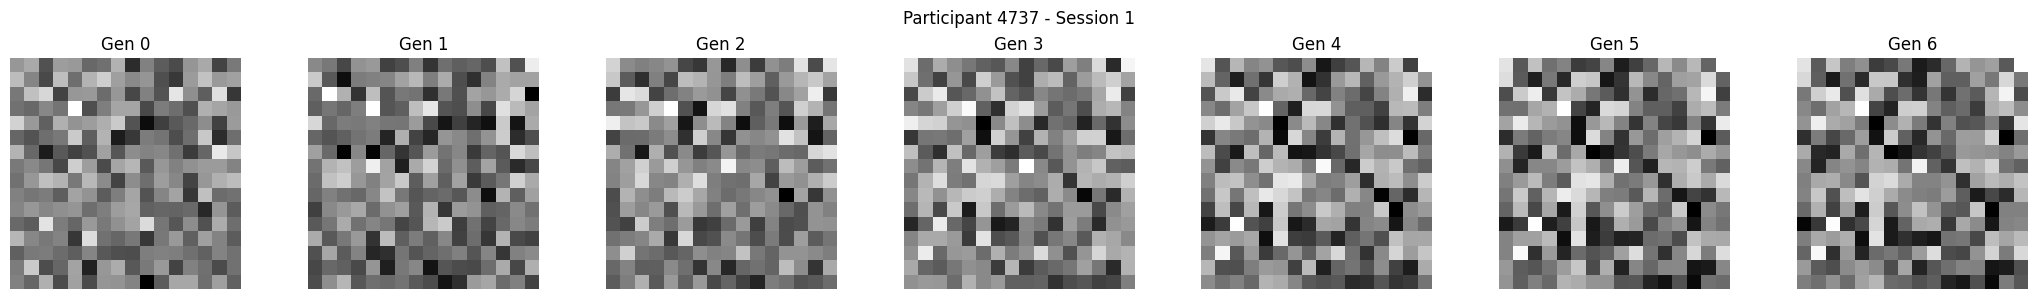

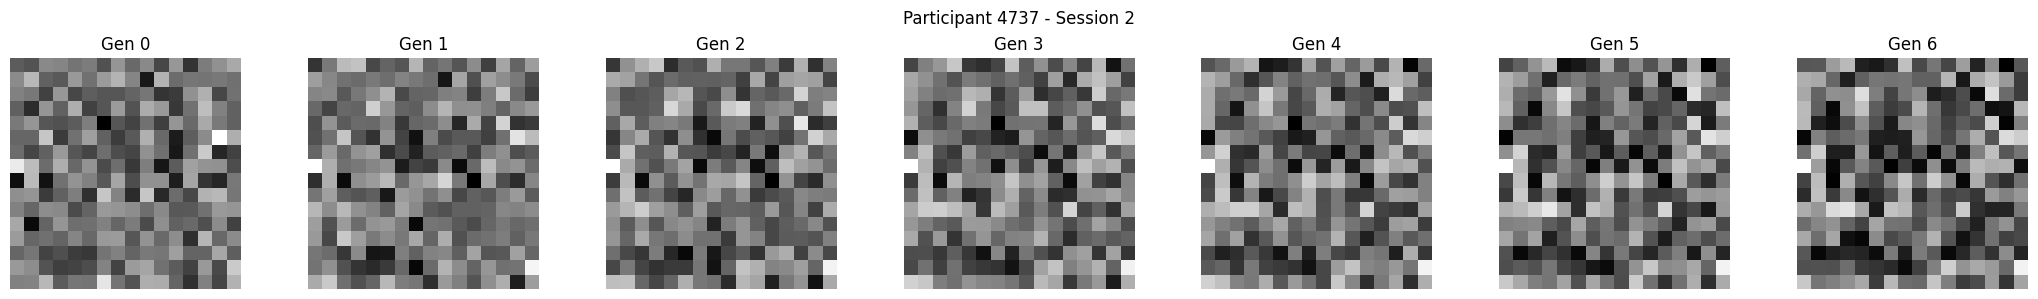

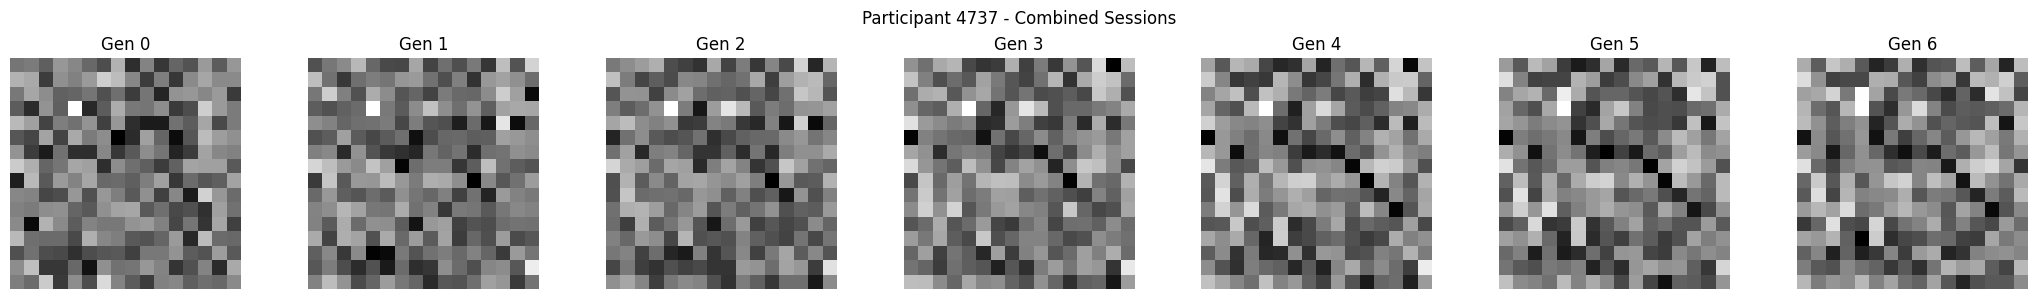


Visualizing Participant 4739


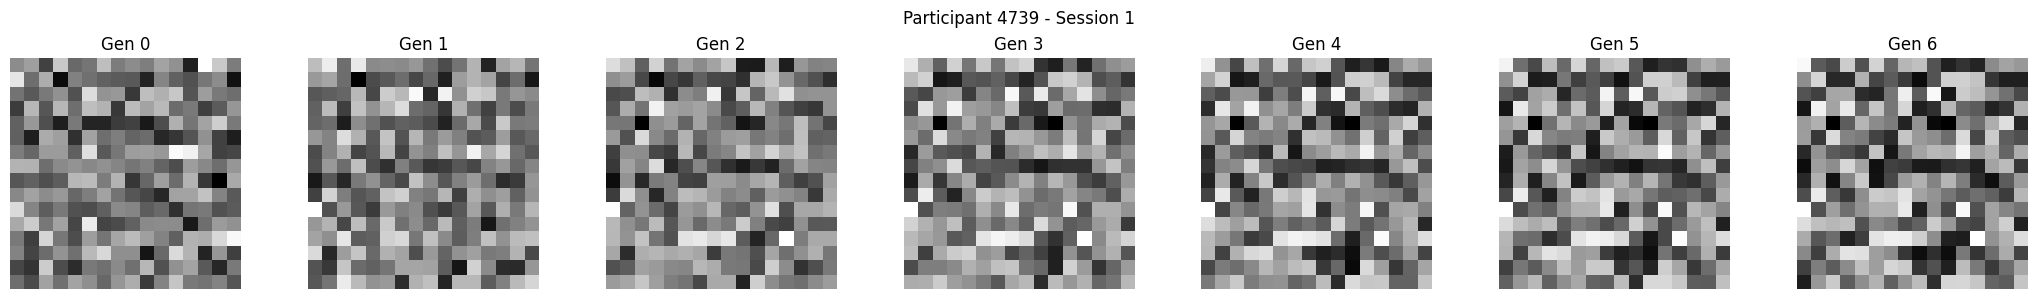

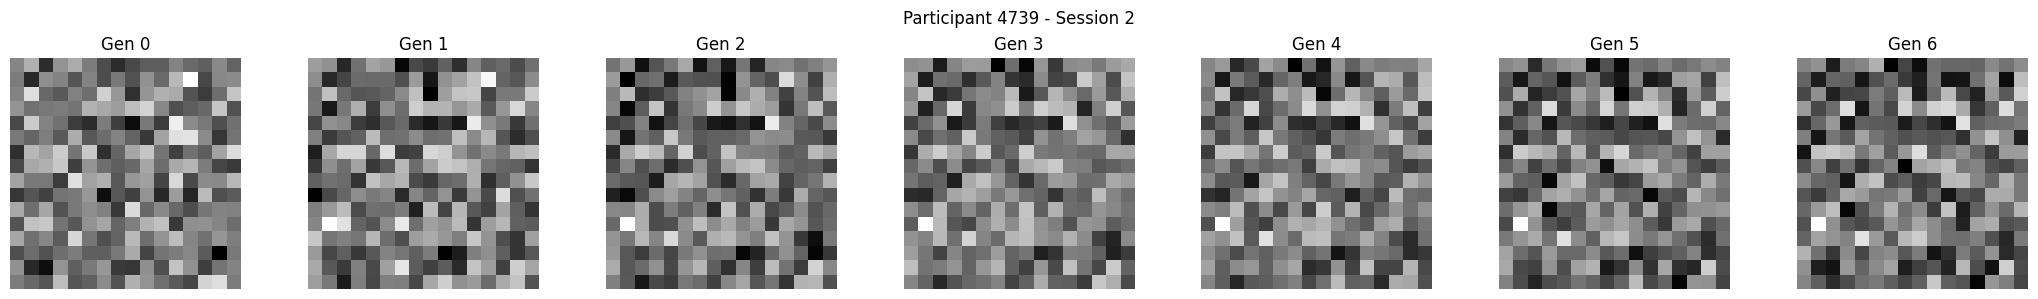

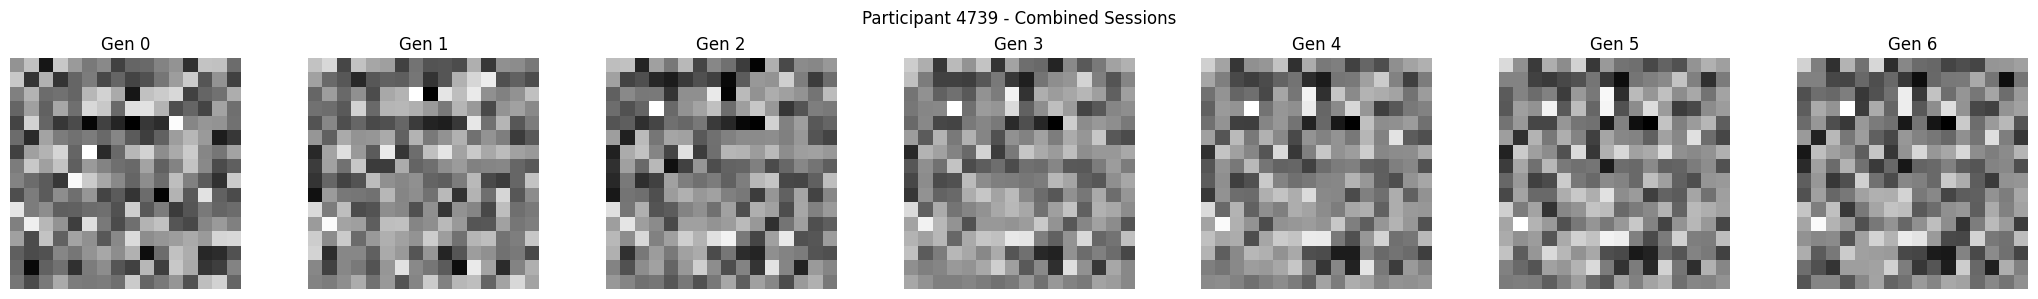


Visualizing Participant 12109


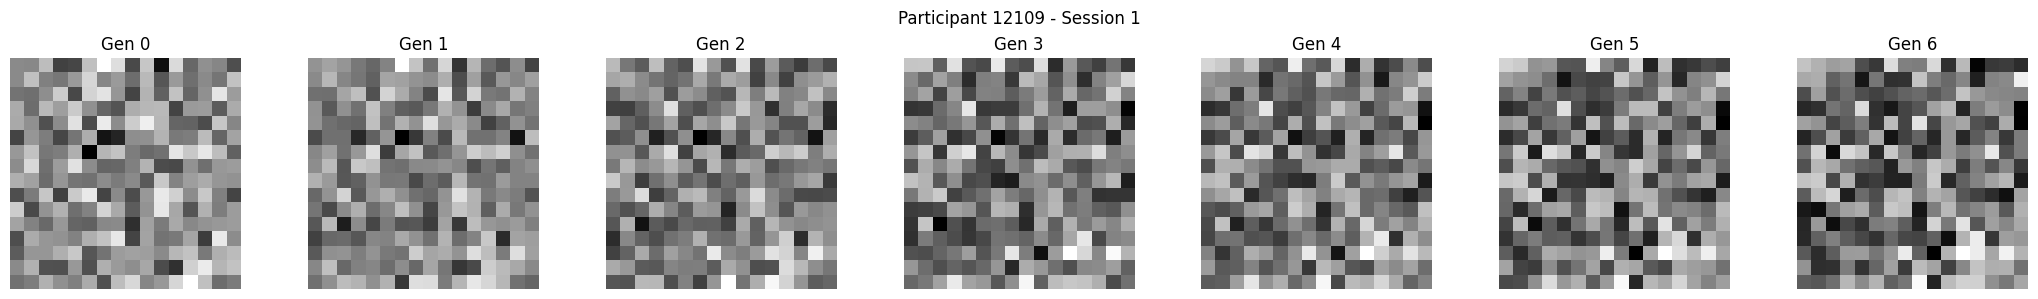

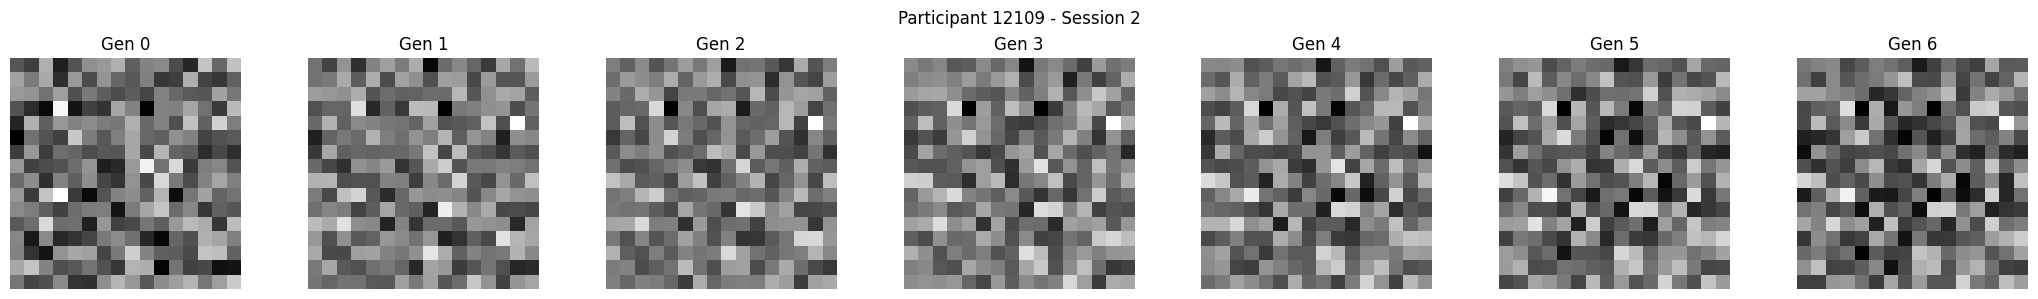

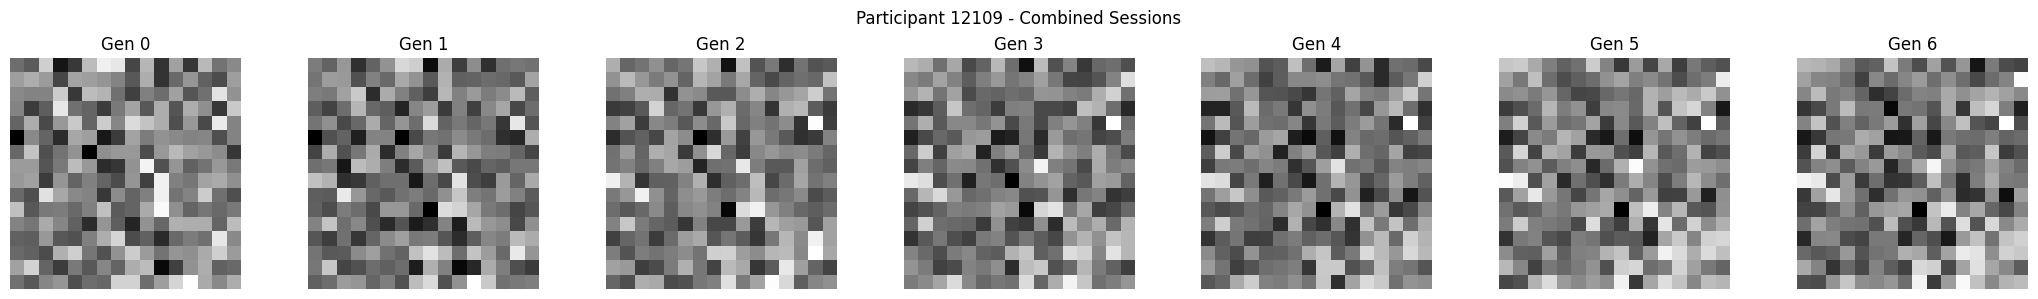


Visualizing Participant 11974


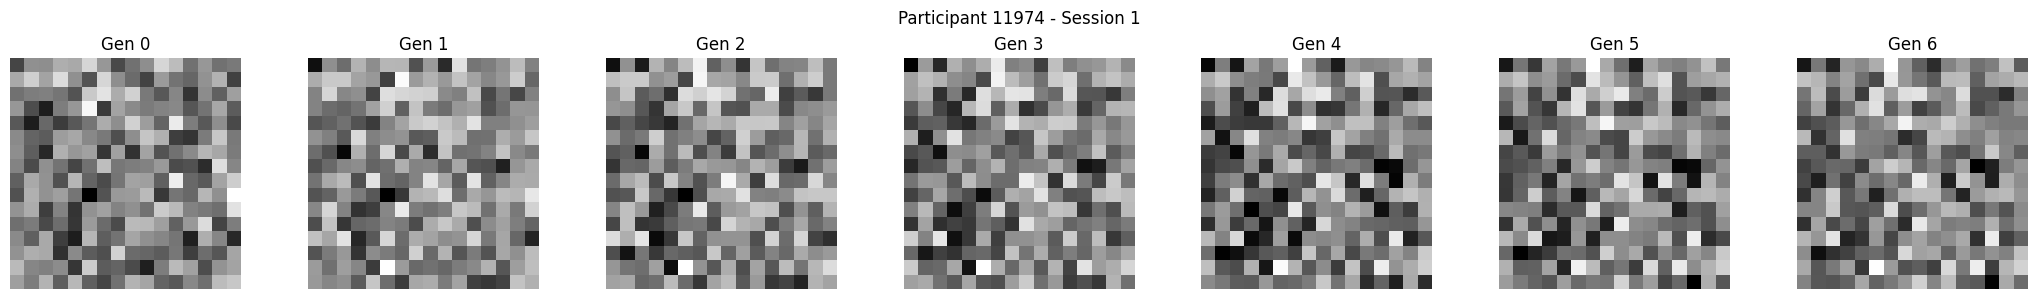

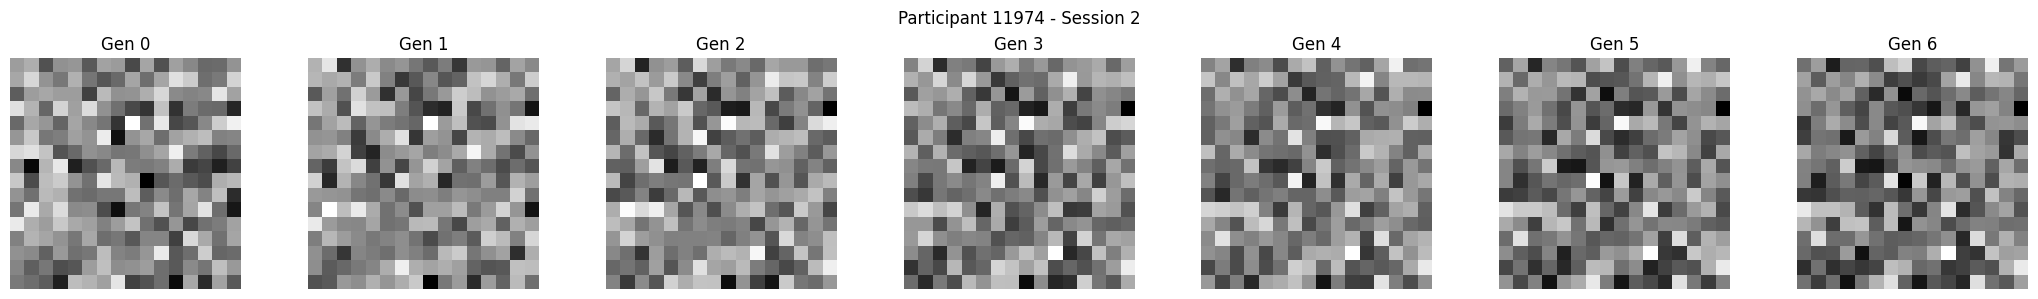

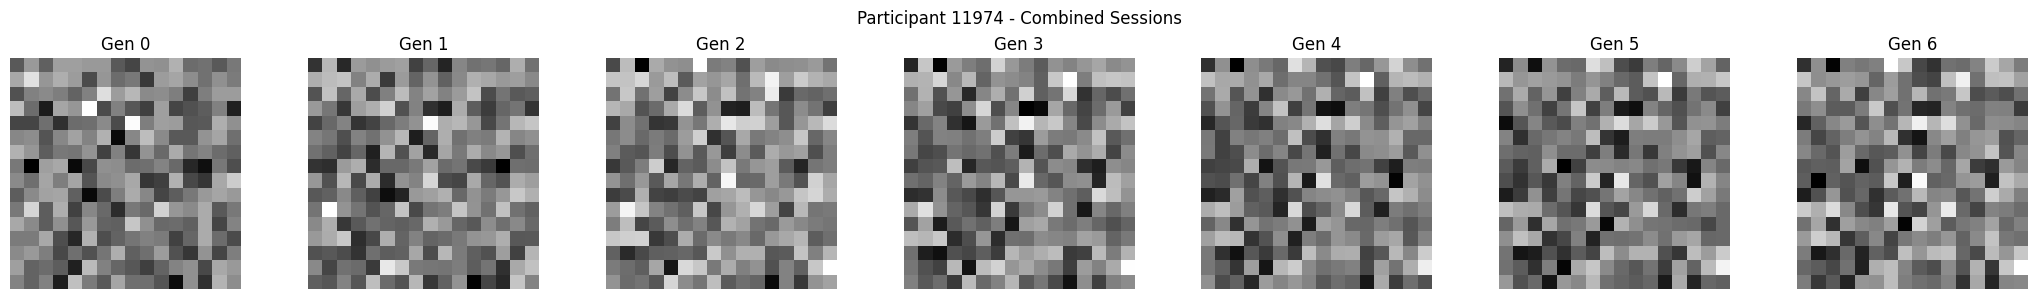


Visualizing Participant 13615


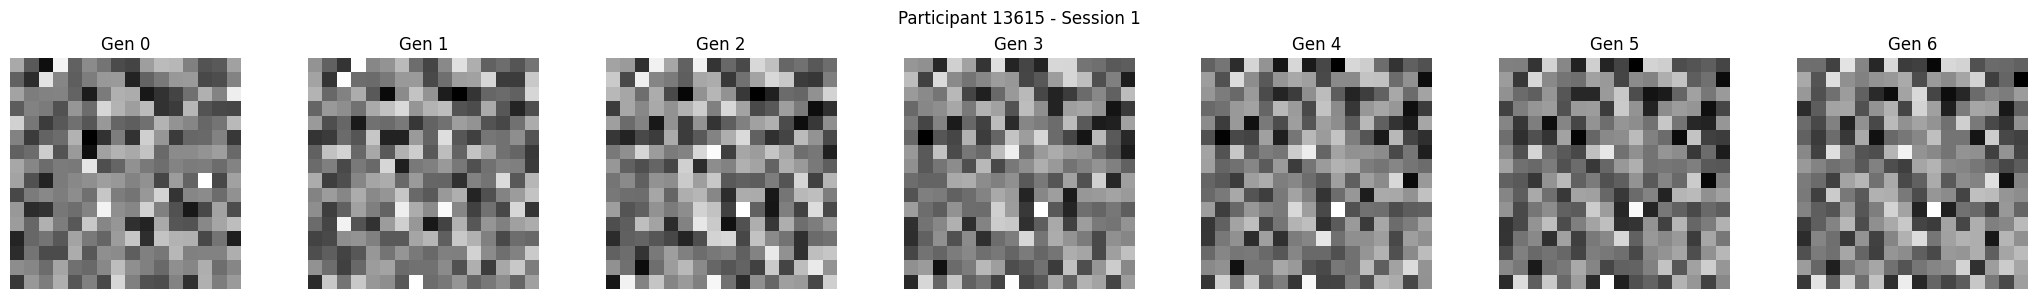

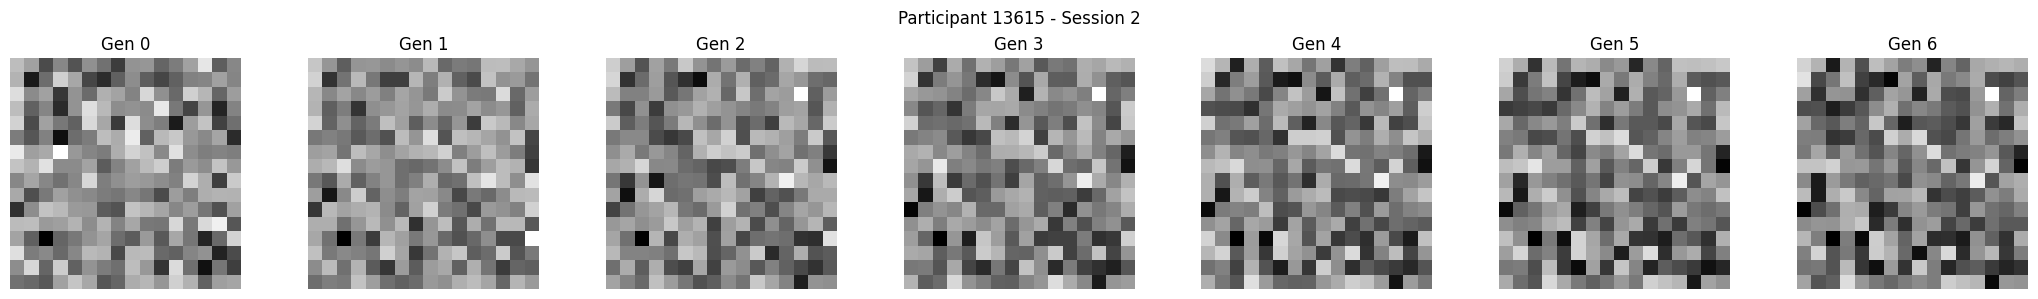

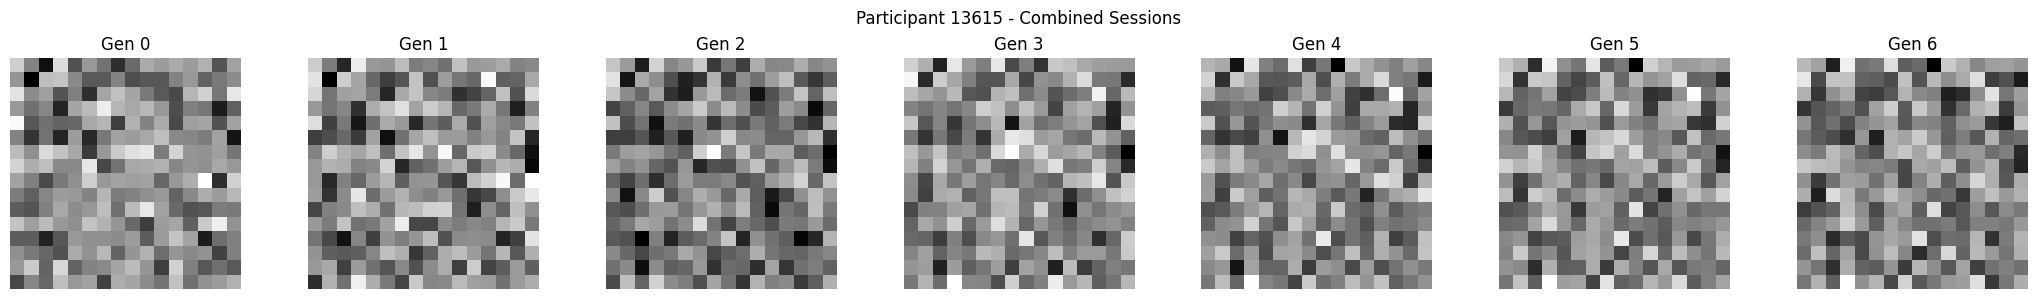


Visualizing Participant 12040


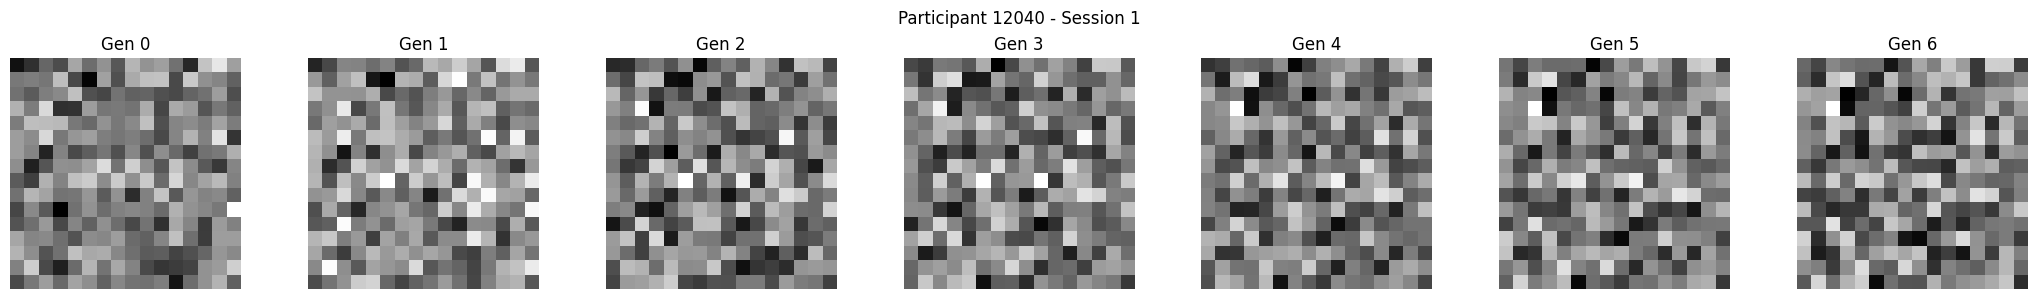

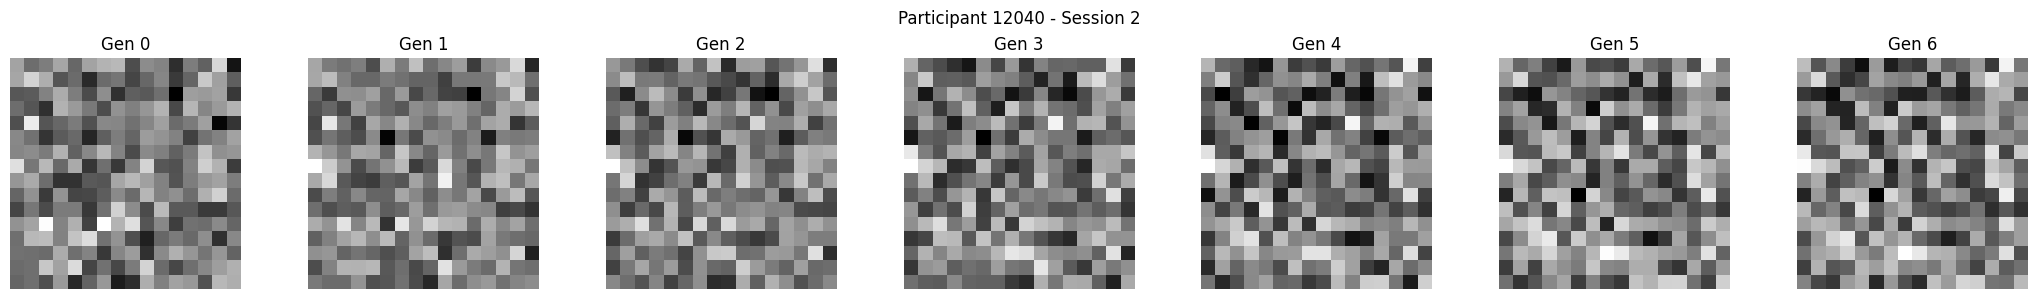

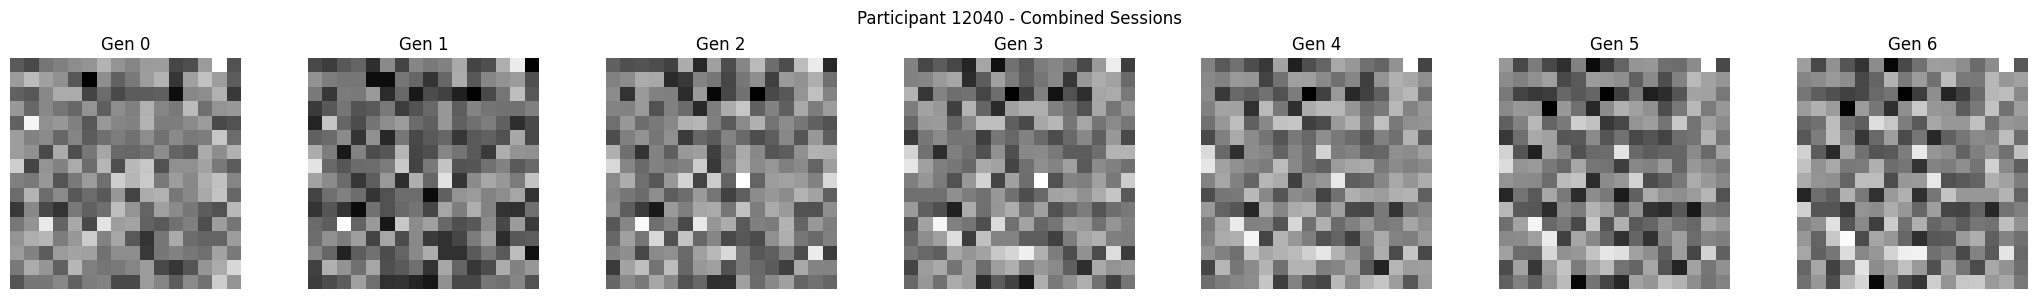


Visualizing Participant 13186


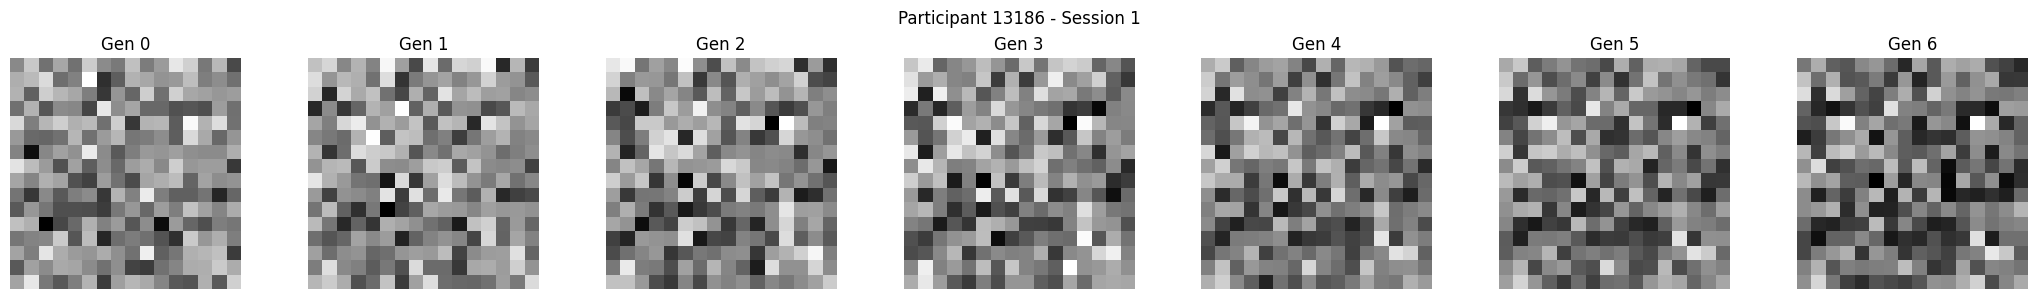

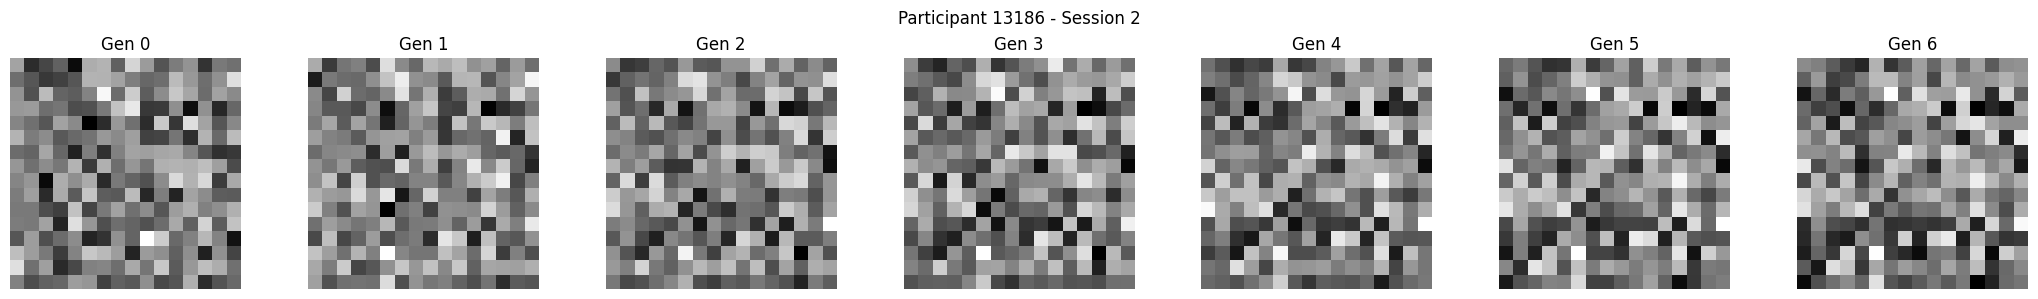

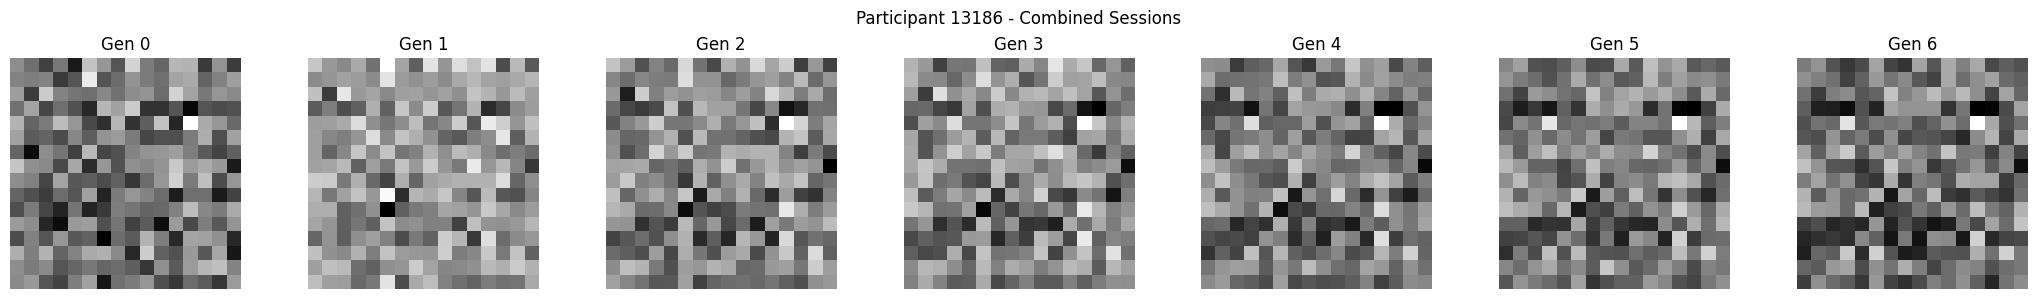


Visualizing Participant 12361


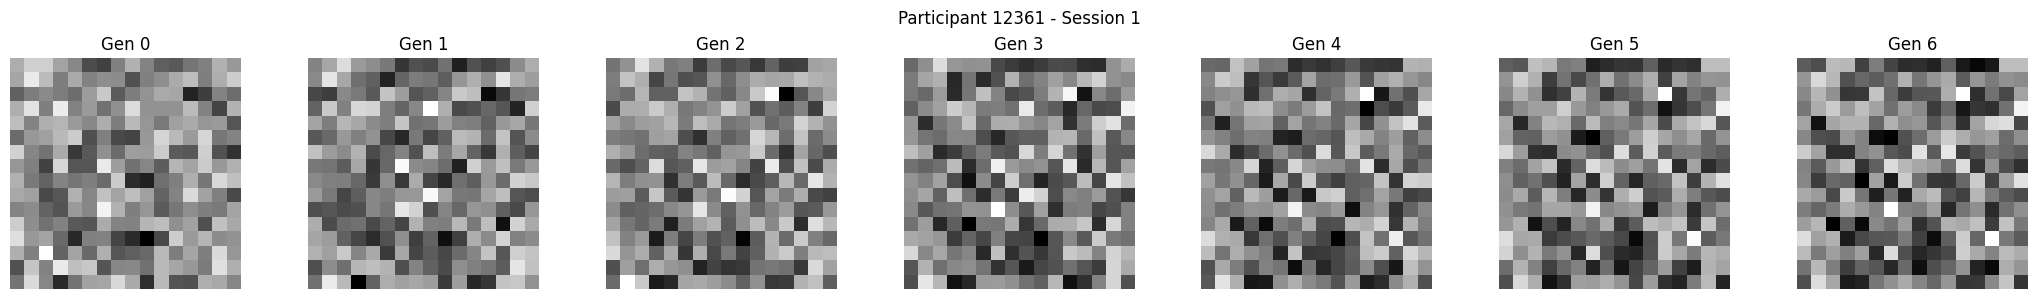

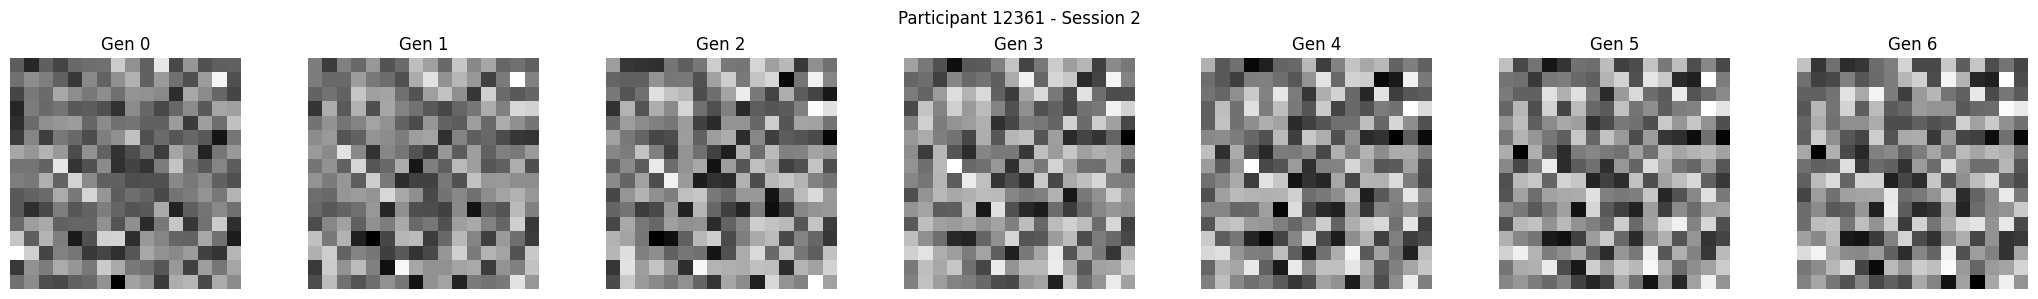

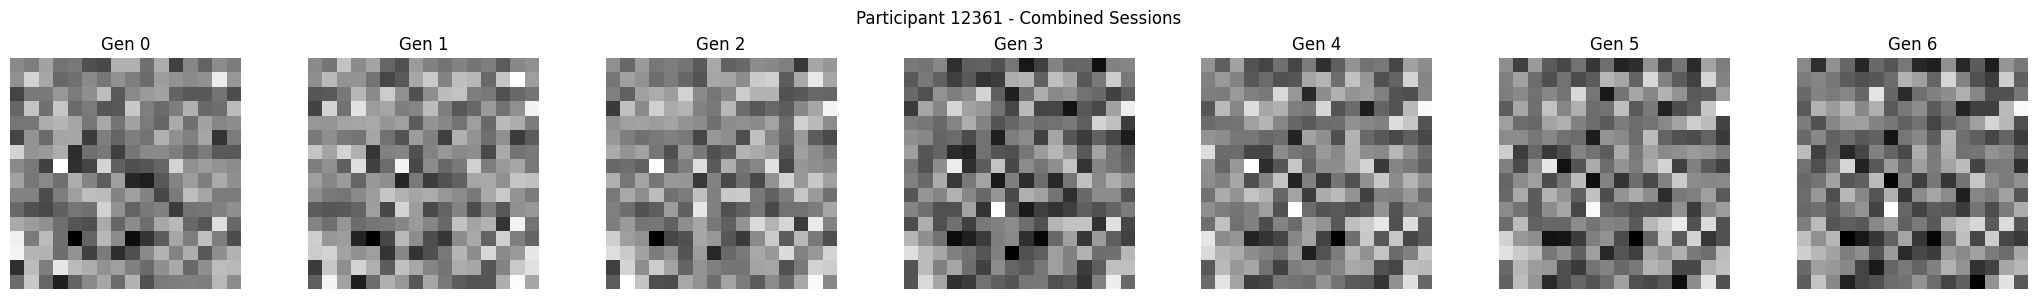


Visualizing Participant 12346


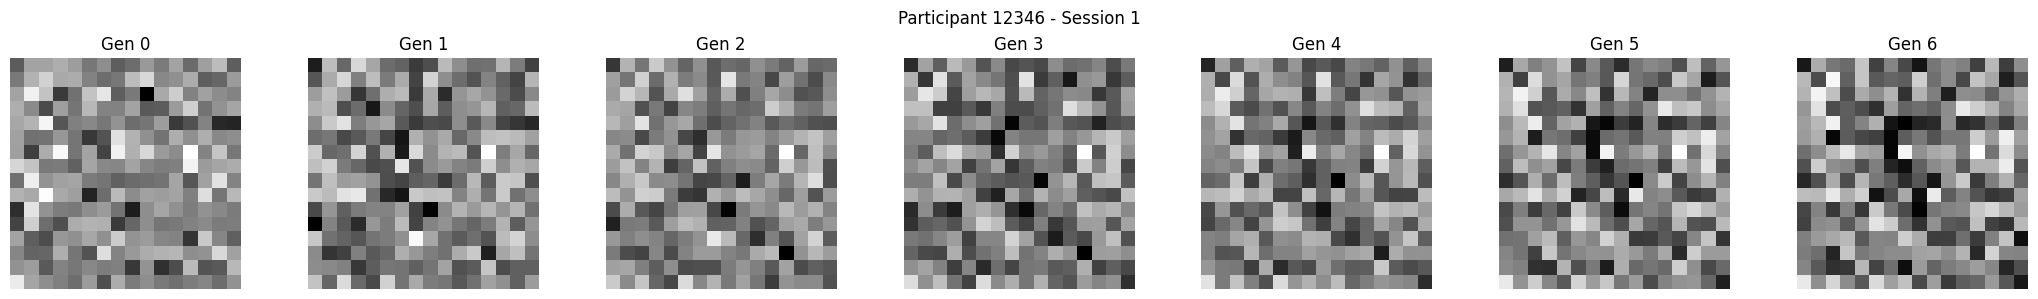

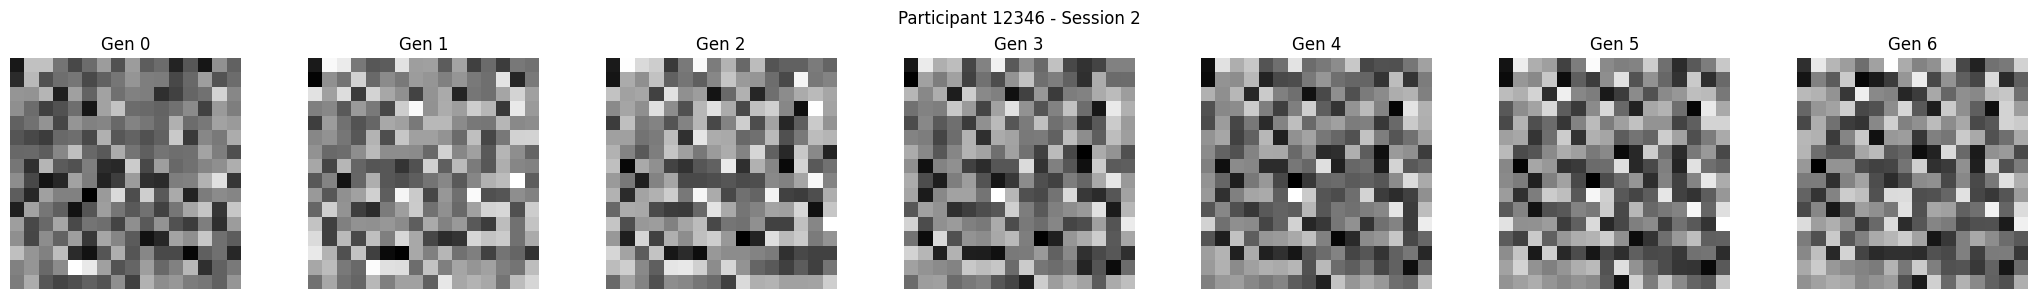

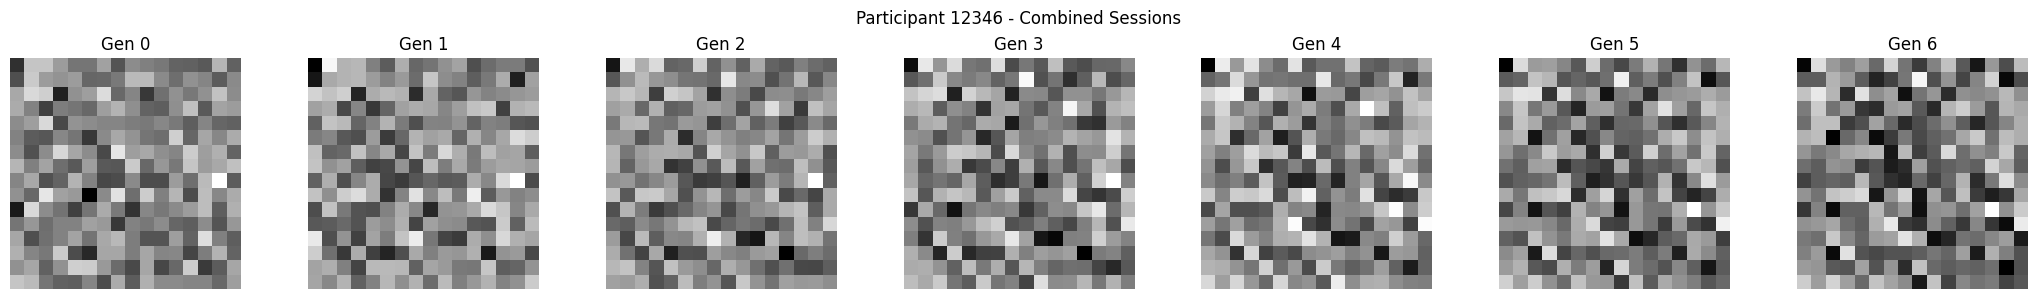


Visualizing Participant 12382


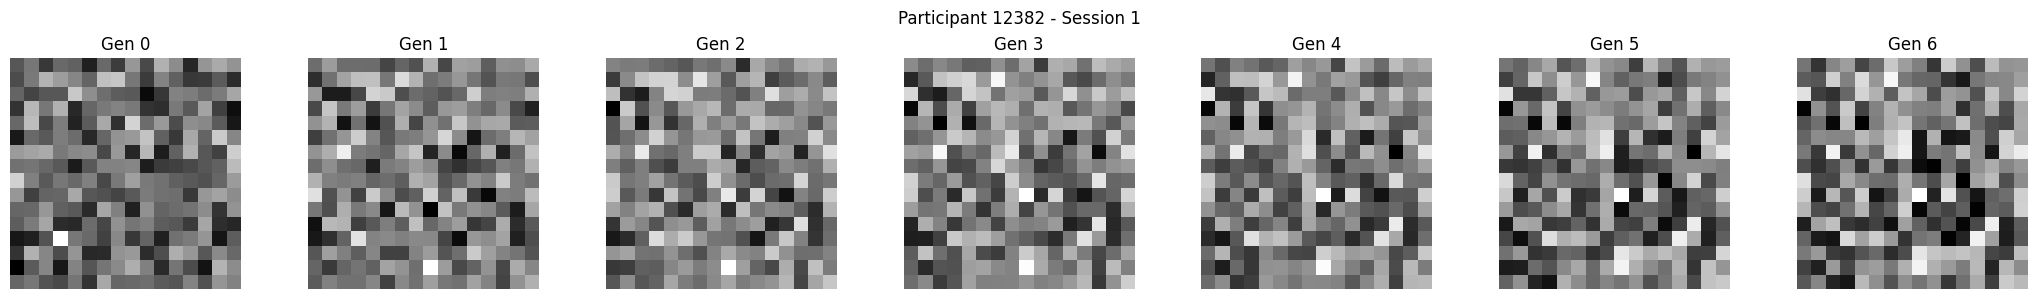

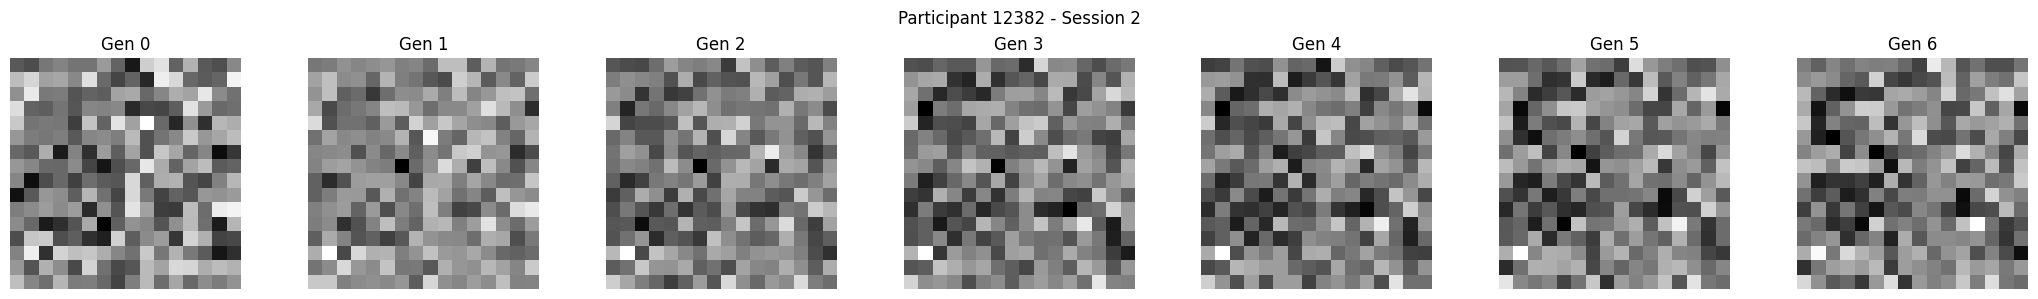

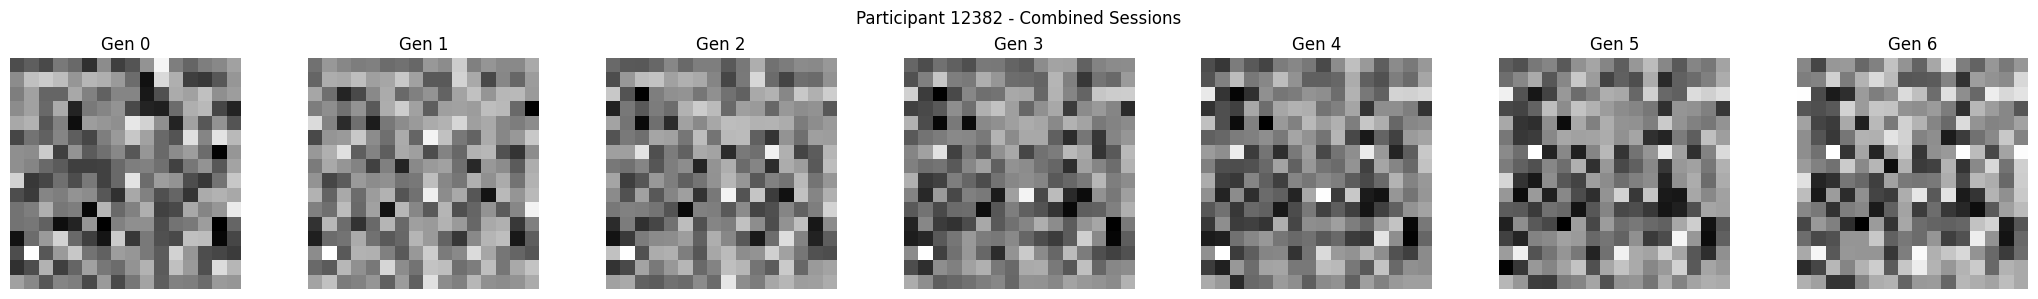


Visualizing Participant 12511


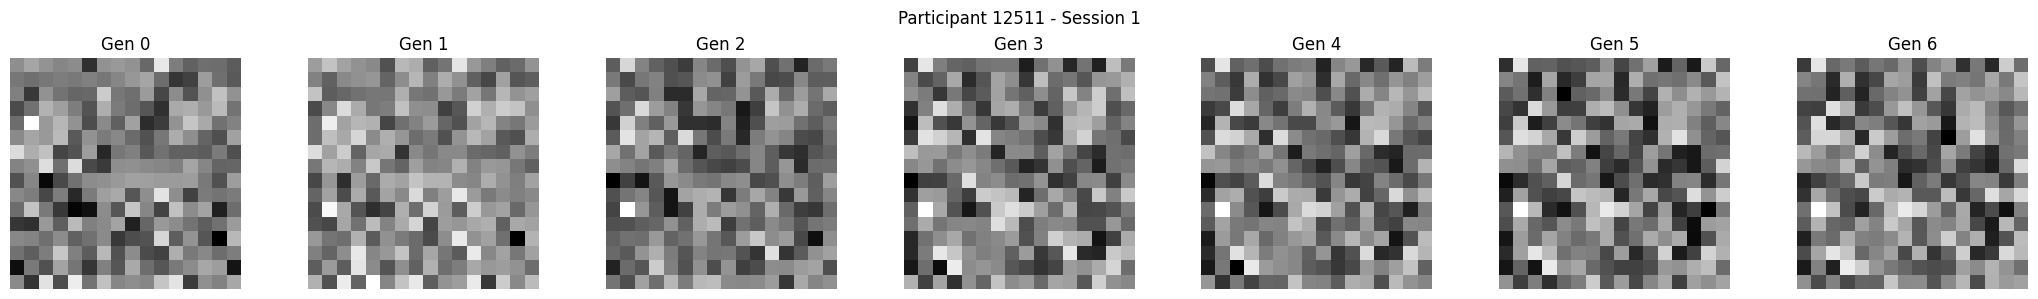

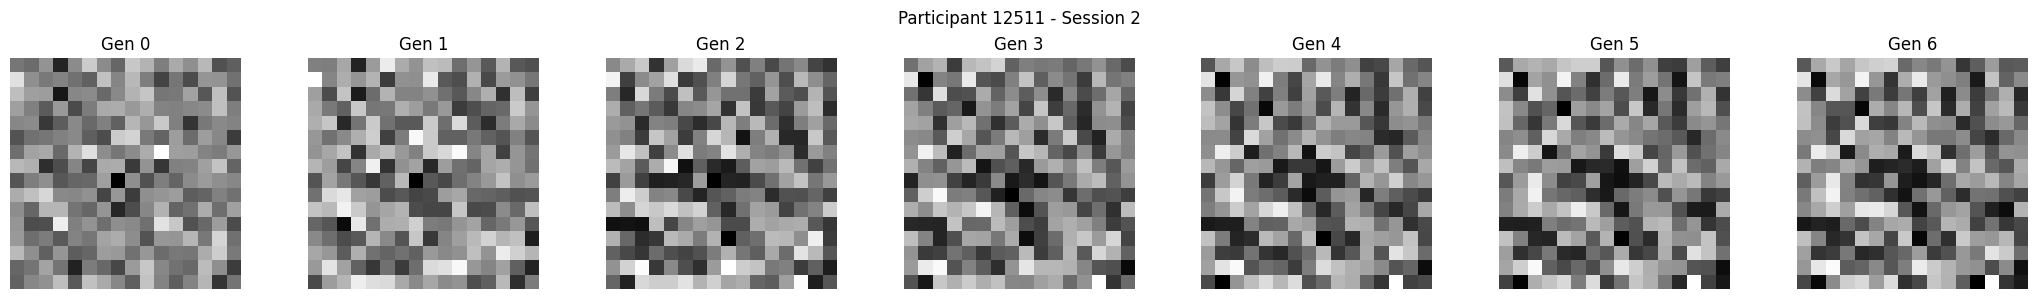

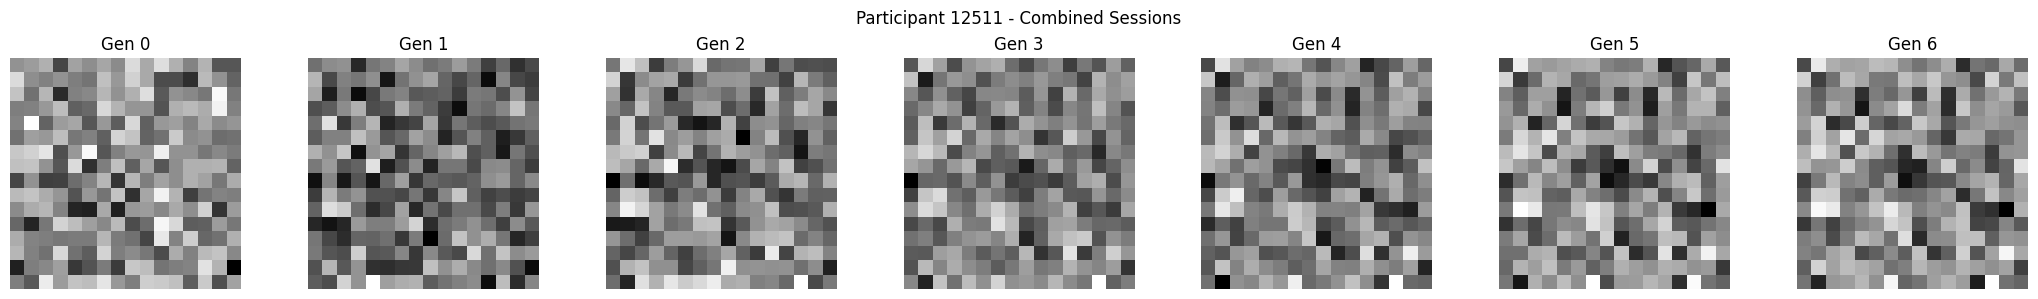


Visualizing Participant 12334


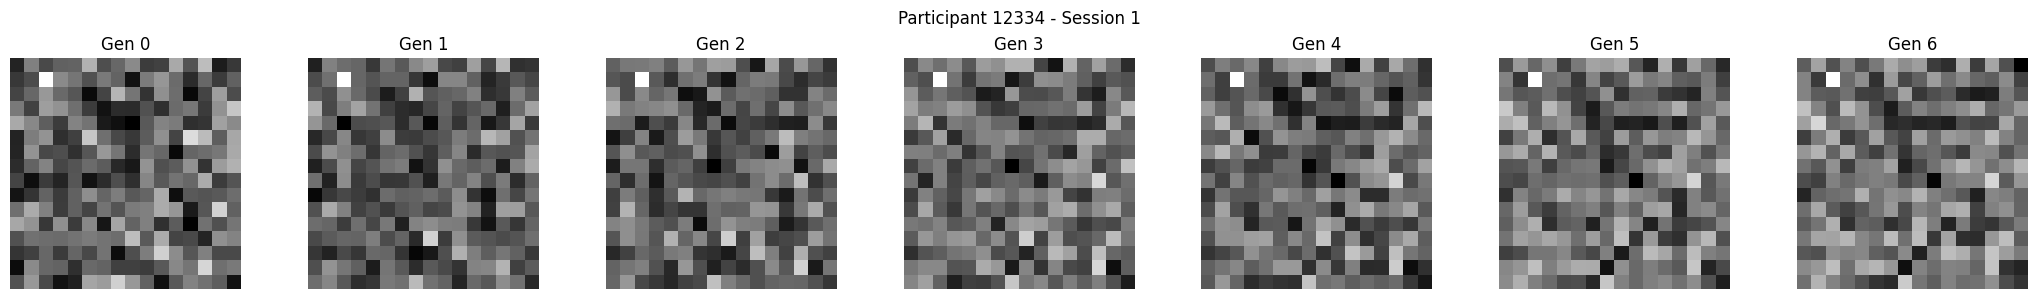

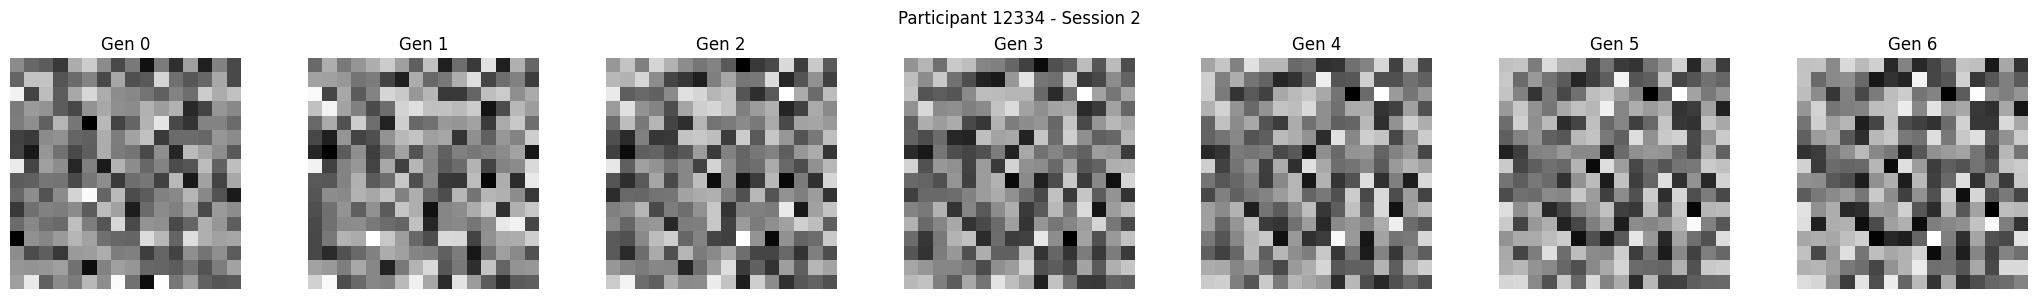

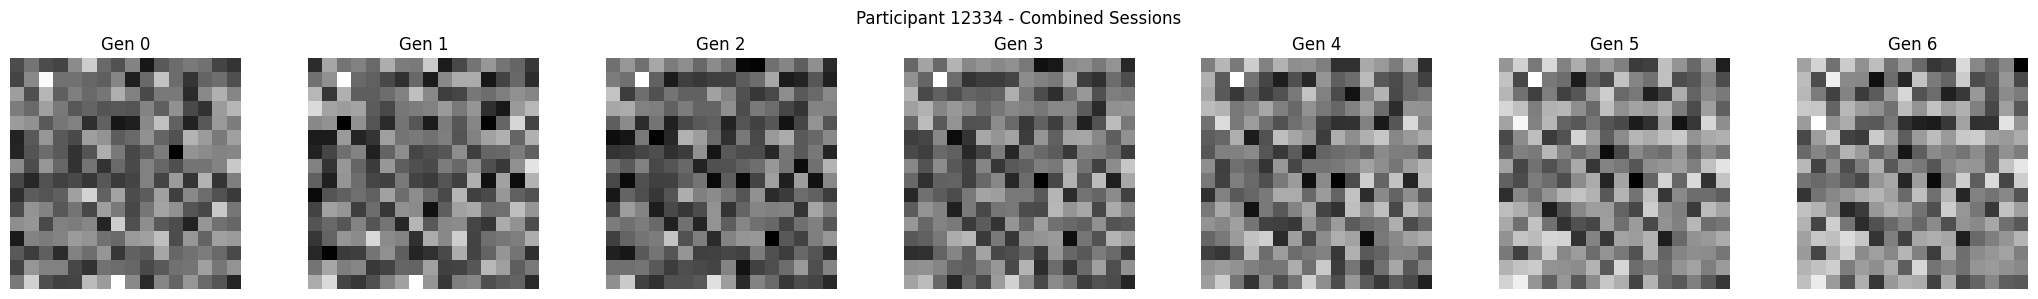


Visualizing Participant 12295


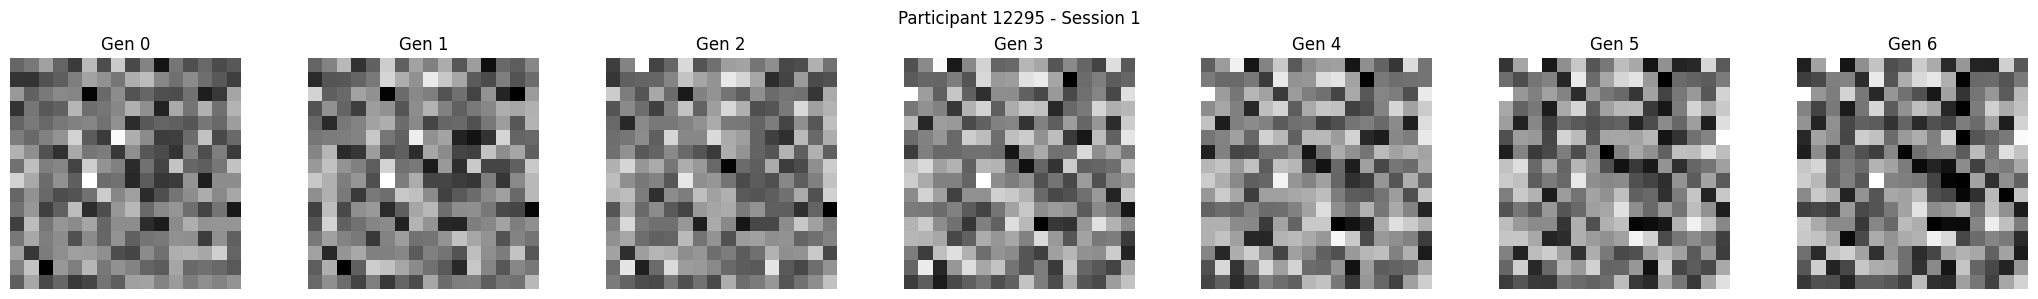

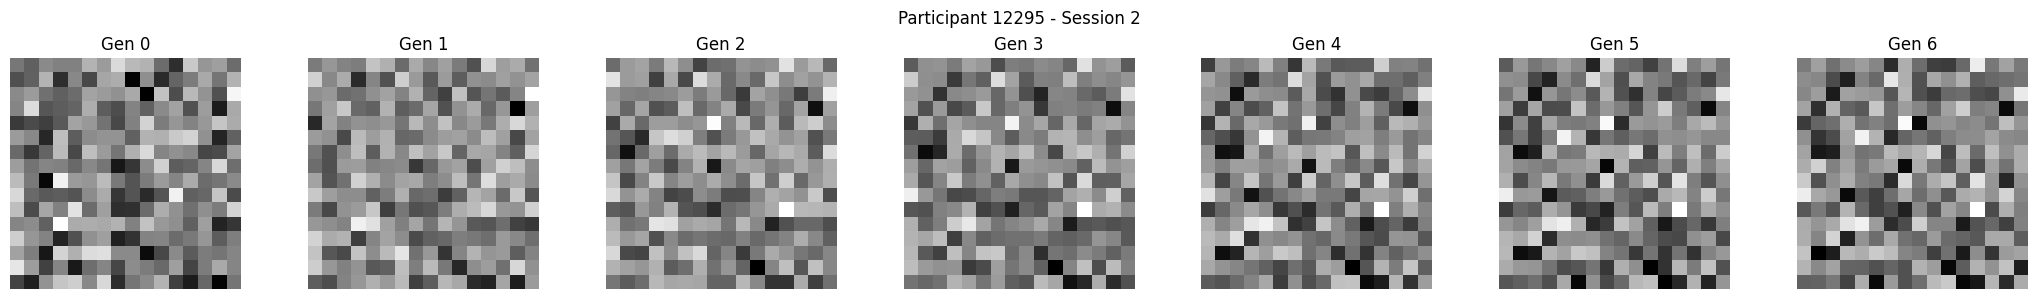

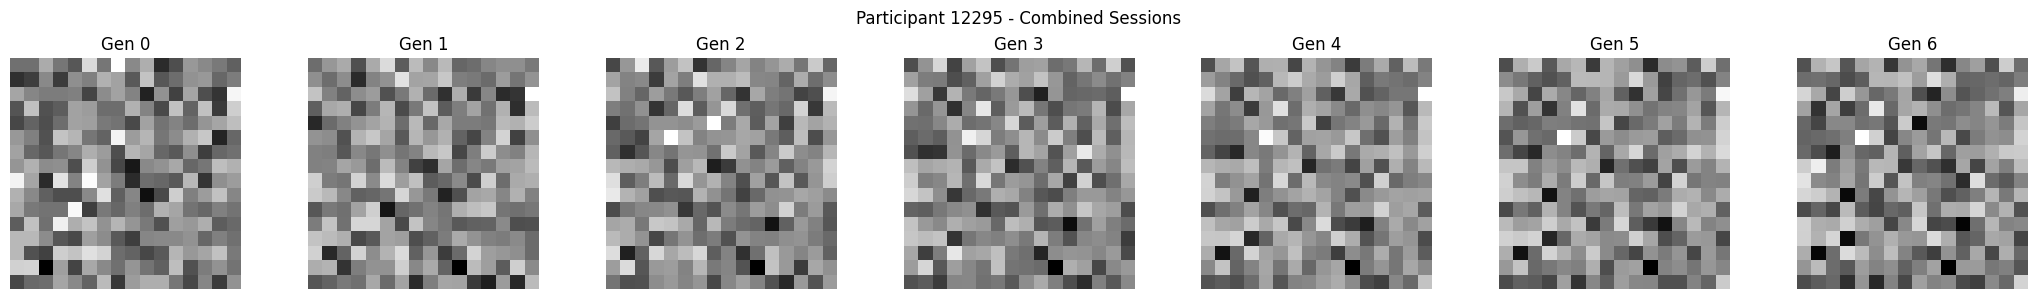


Visualizing Participant 13153


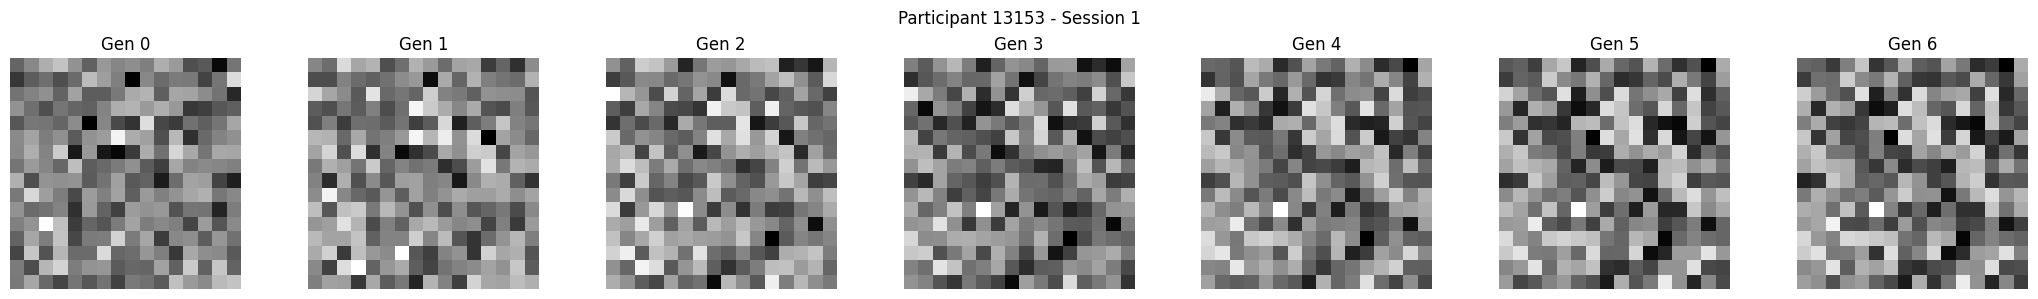

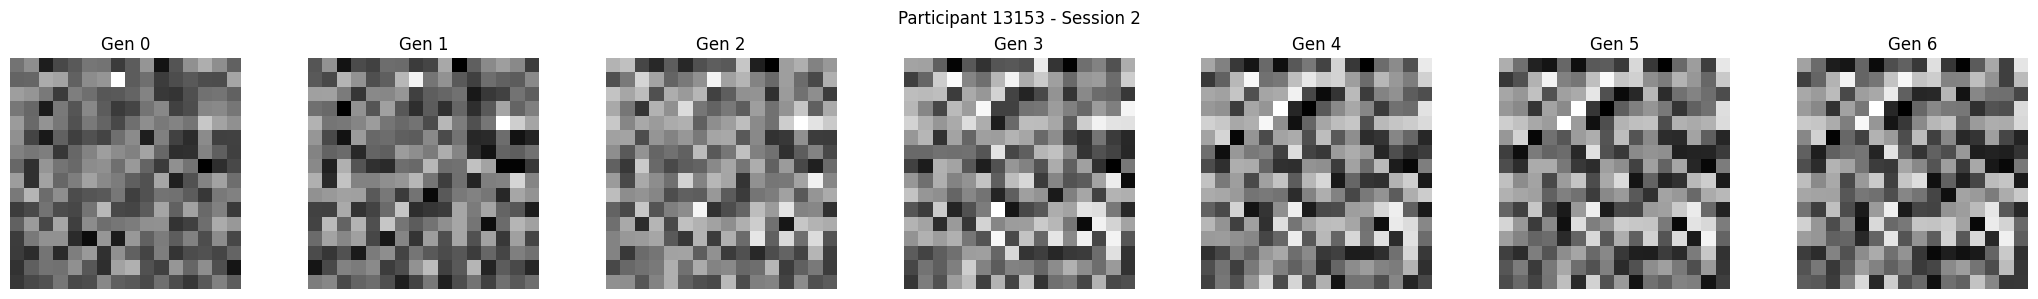

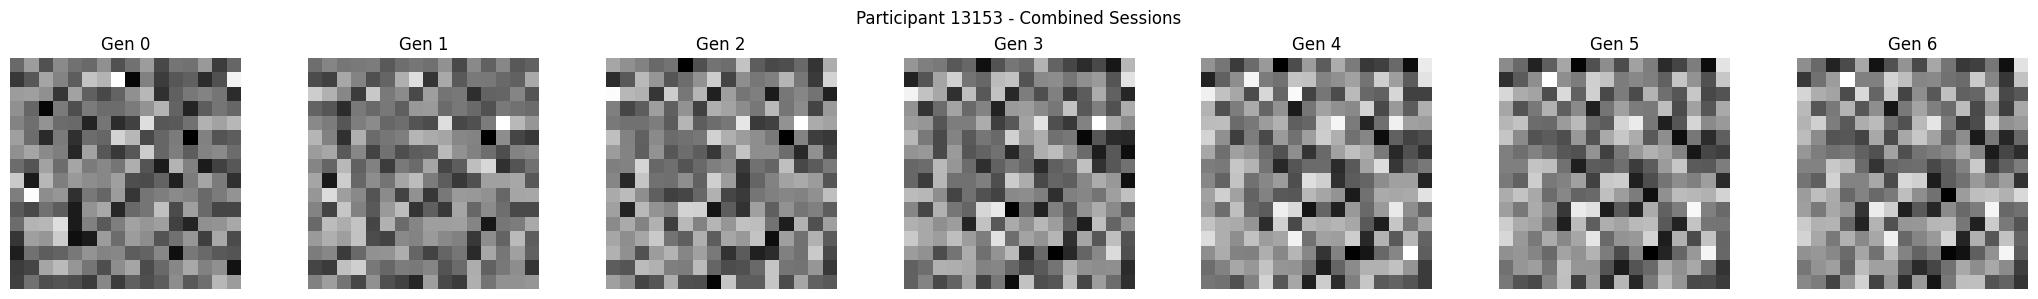


Visualizing Participant 11929


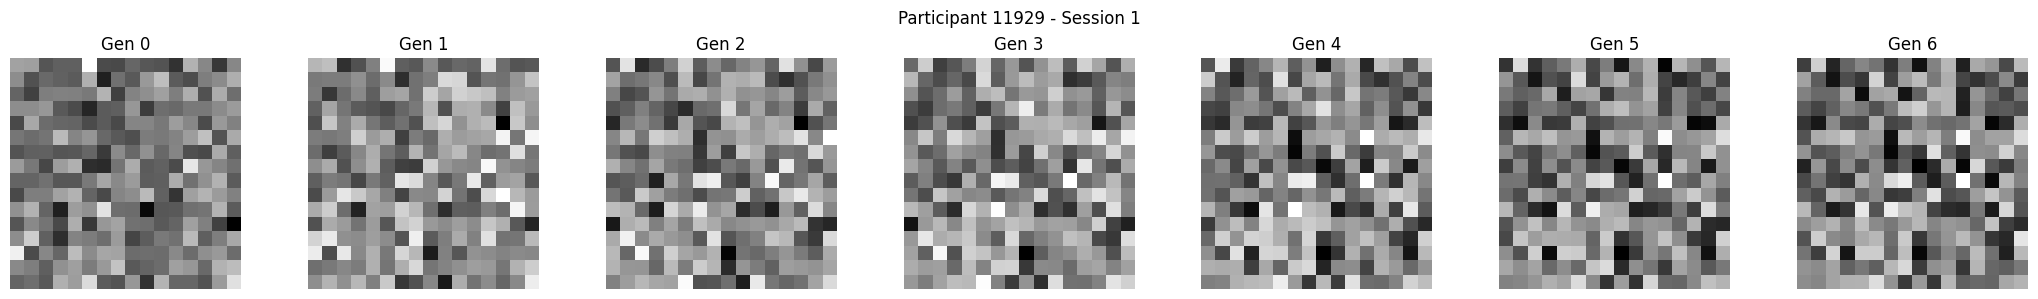

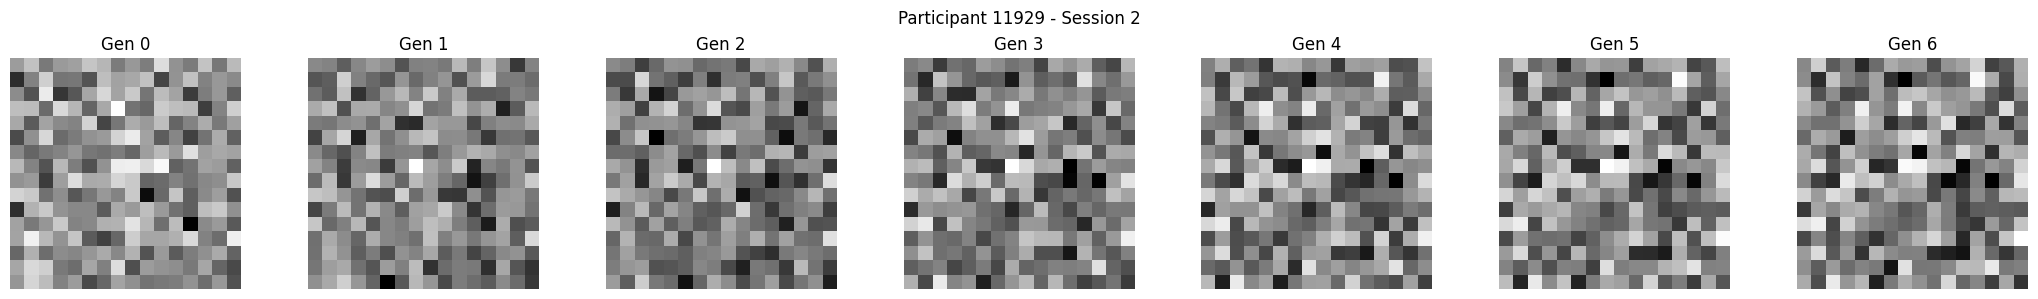

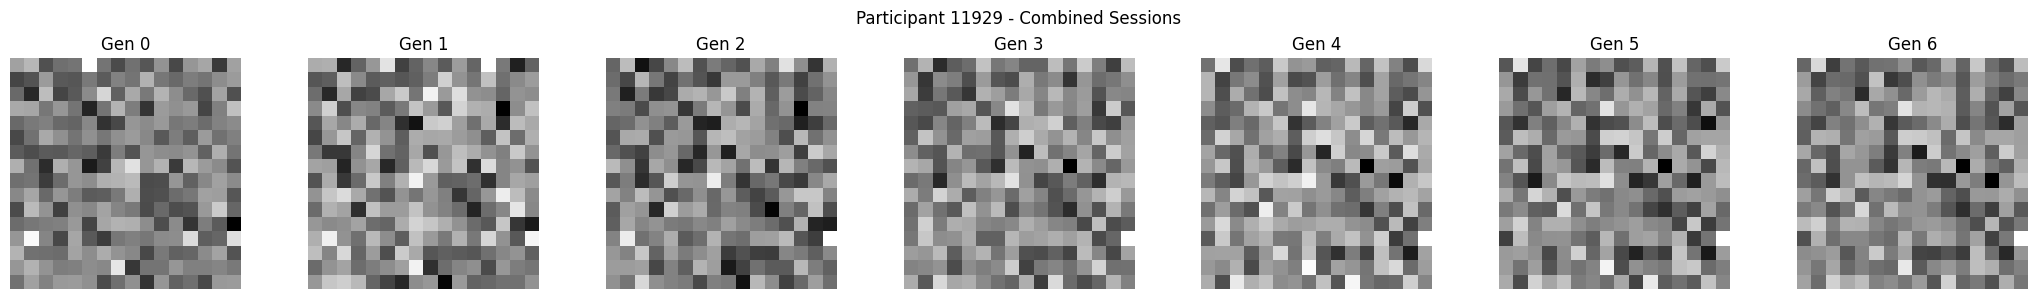

In [11]:
# Cell 1: Combine clean participants with original data
def process_evolution_data(valid_results, clean_dfs):
    # Get list of clean participants (those who passed attention checks)
    clean_participants = clean_dfs['participants'].index.tolist()
    
    # Process only clean participants' data
    results = {}
    for result in valid_results:
        participant_id = result['metadata']['participant_id']
        if participant_id in clean_participants:  # Only process clean participants
            if 'evolution_summary' in result:
                results[participant_id] = {}
                
                for gen_data in result['evolution_summary']:
                    session = gen_data['session']
                    if session not in results[participant_id]:
                        results[participant_id][session] = {}
                    
                    generation = gen_data['generation']
                    if 'selected_parents' in gen_data:
                        results[participant_id][session][generation] = {
                            'selected': [p['filtered_image'] for p in gen_data['selected_parents']]
                        }
    
    return results

def plot_participant_sessions_with_combined(participant_data, participant_id):
    # First plot individual sessions
    for session, session_data in participant_data.items():
        generations = sorted(session_data.keys())
        n_gens = len(generations)
        
        if n_gens == 0:
            print(f"No generations found for Participant {participant_id}, Session {session}")
            continue
            
        fig, axes = plt.subplots(1, n_gens, figsize=(3*n_gens, 3))
        if n_gens == 1:
            axes = [axes]
        
        for idx, gen in enumerate(generations):
            gen_images = []
            for img_base64 in session_data[gen]['selected']:
                try:
                    img = decode_base64_image(img_base64)
                    gen_images.append(img)
                except:
                    continue
                    
            if gen_images:
                composite = create_composite_image(gen_images)
                axes[idx].imshow(composite, cmap='gray')
                axes[idx].axis('off')
                axes[idx].set_title(f'Gen {gen}')
        
        plt.suptitle(f'Participant {participant_id} - Session {session}')
        plt.tight_layout()
        plt.show()
        plt.close()

    # Then create and plot combined sessions
    combined_generations = {}
    for session, session_data in participant_data.items():
        for gen, gen_data in session_data.items():
            if gen not in combined_generations:
                combined_generations[gen] = []
            combined_generations[gen].extend(gen_data['selected'])

    # Plot combined sessions
    fig, axes = plt.subplots(1, len(combined_generations), figsize=(3*len(combined_generations), 3))
    if len(combined_generations) == 1:
        axes = [axes]

    for idx, (gen, gen_images_base64) in enumerate(sorted(combined_generations.items())):
        gen_images = []
        for img_base64 in gen_images_base64:
            try:
                img = decode_base64_image(img_base64)
                gen_images.append(img)
            except:
                continue

        if gen_images:
            composite = create_composite_image(gen_images)
            axes[idx].imshow(composite, cmap='gray')
            axes[idx].axis('off')
            axes[idx].set_title(f'Gen {gen}')

    plt.suptitle(f'Participant {participant_id} - Combined Sessions')
    plt.tight_layout()
    plt.show()
    plt.close()

# Update the visualization function in your pipeline
def visualize_clean_evolution(valid_results, clean_dfs):
    clean_participant_data = process_evolution_data(valid_results, clean_dfs)
    
    print("Clean Evolution Data Summary:")
    for participant_id, data in clean_participant_data.items():
        print(f"\nParticipant {participant_id}:")
        for session, session_data in data.items():
            print(f"  Session {session}: {len(session_data)} generations")
            print(f"  Available generations: {sorted(session_data.keys())}")
    
    for participant_id, data in clean_participant_data.items():
        print(f"\nVisualizing Participant {participant_id}")
        plot_participant_sessions_with_combined(data, participant_id)

# Run the analysis
visualize_clean_evolution(valid_results, clean_dfs)


VVIQ Score Summary:

Mean Scores per Participant:
                eyes_open_mean  eyes_closed_mean  total_mean
participant_id                                              
4737                      3.18              2.88        3.03
4739                      2.18              1.29        1.74
12109                     2.35              2.47        2.41
11974                     2.91              2.50        2.71
13615                     1.53              1.24        1.38
12040                     2.29              2.65        2.47
13186                     2.24              1.88        2.06
12361                     2.71              2.24        2.47
12346                     3.12              2.88        3.00
12382                     2.76              2.71        2.74
12511                     2.47              1.94        2.21
12334                     2.65              2.41        2.53
12295                     2.12              2.41        2.26
13153                     2.06     

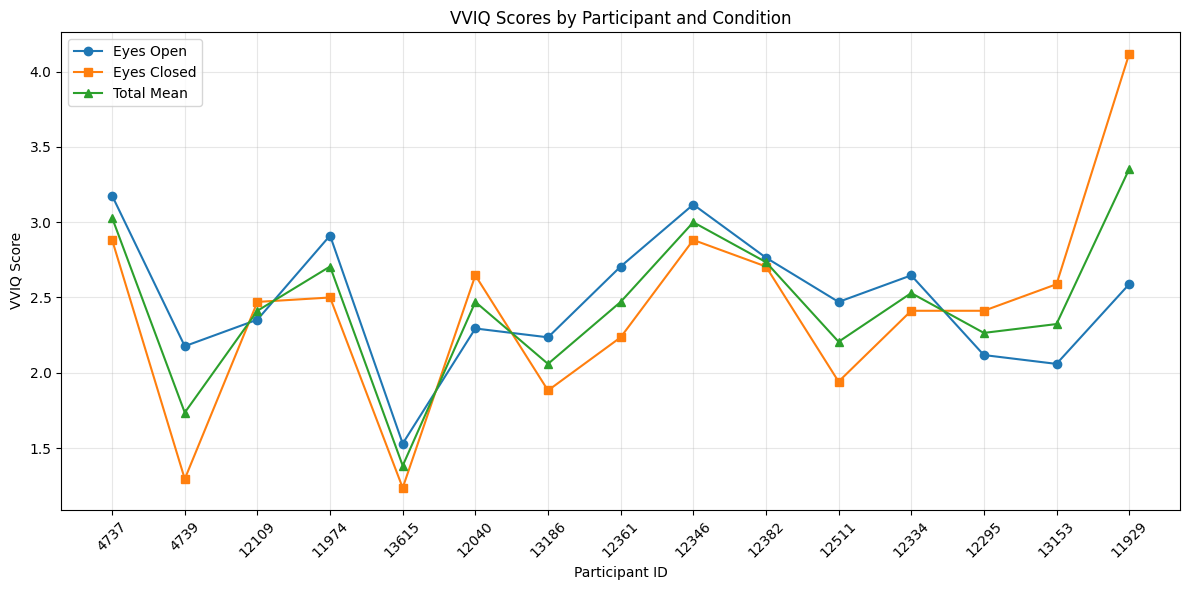

In [12]:
def analyze_vviq_scores(clean_dfs):
    """Analyze VVIQ scores for each participant"""
    vviq_df = clean_dfs['vviq']
    
    # Calculate scores for each condition and participant
    vviq_scores = {}
    for participant_id in clean_dfs['participants'].index:
        participant_data = vviq_df[vviq_df['participant_id'] == participant_id]
        
        # Initialize participant scores
        vviq_scores[participant_id] = {
            'eyes_open': {'scores': [], 'mean': 0},
            'eyes_closed': {'scores': [], 'mean': 0},
            'total_mean': 0
        }
        
        # Process each condition
        for condition in ['eyes_open', 'eyes_closed']:
            condition_data = participant_data[participant_data['condition'] == condition]
            scores = condition_data['rating'].tolist()
            
            if scores:  # Check if we have scores for this condition
                vviq_scores[participant_id][condition]['scores'] = scores
                vviq_scores[participant_id][condition]['mean'] = np.mean(scores)
        
        # Calculate total mean
        all_scores = (vviq_scores[participant_id]['eyes_open']['scores'] + 
                     vviq_scores[participant_id]['eyes_closed']['scores'])
        if all_scores:
            vviq_scores[participant_id]['total_mean'] = np.mean(all_scores)
    
    # Create summary DataFrame
    summary_data = []
    for participant_id, scores in vviq_scores.items():
        summary_data.append({
            'participant_id': participant_id,
            'eyes_open_mean': scores['eyes_open']['mean'],
            'eyes_closed_mean': scores['eyes_closed']['mean'],
            'total_mean': scores['total_mean']
        })
    
    summary_df = pd.DataFrame(summary_data).set_index('participant_id')
    
    # Print summary statistics
    print("VVIQ Score Summary:")
    print("\nMean Scores per Participant:")
    print(summary_df.round(2))
    
    print("\nOverall Statistics:")
    print(summary_df.agg(['mean', 'std', 'min', 'max']).round(2))
    
    # Create visualization
    plt.figure(figsize=(12, 6))
    
    # Plot individual scores
    x = range(len(summary_df))
    plt.plot(x, summary_df['eyes_open_mean'], 'o-', label='Eyes Open')
    plt.plot(x, summary_df['eyes_closed_mean'], 's-', label='Eyes Closed')
    plt.plot(x, summary_df['total_mean'], '^-', label='Total Mean')
    
    plt.xticks(x, summary_df.index, rotation=45)
    plt.xlabel('Participant ID')
    plt.ylabel('VVIQ Score')
    plt.title('VVIQ Scores by Participant and Condition')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return summary_df

# Run the analysis
vviq_summary = analyze_vviq_scores(clean_dfs)



Correlations with Training Accuracy:

eyes_open_mean:
r = 0.215
p = 0.461

eyes_closed_mean:
r = 0.395
p = 0.162

total_mean:
r = 0.370
p = 0.193


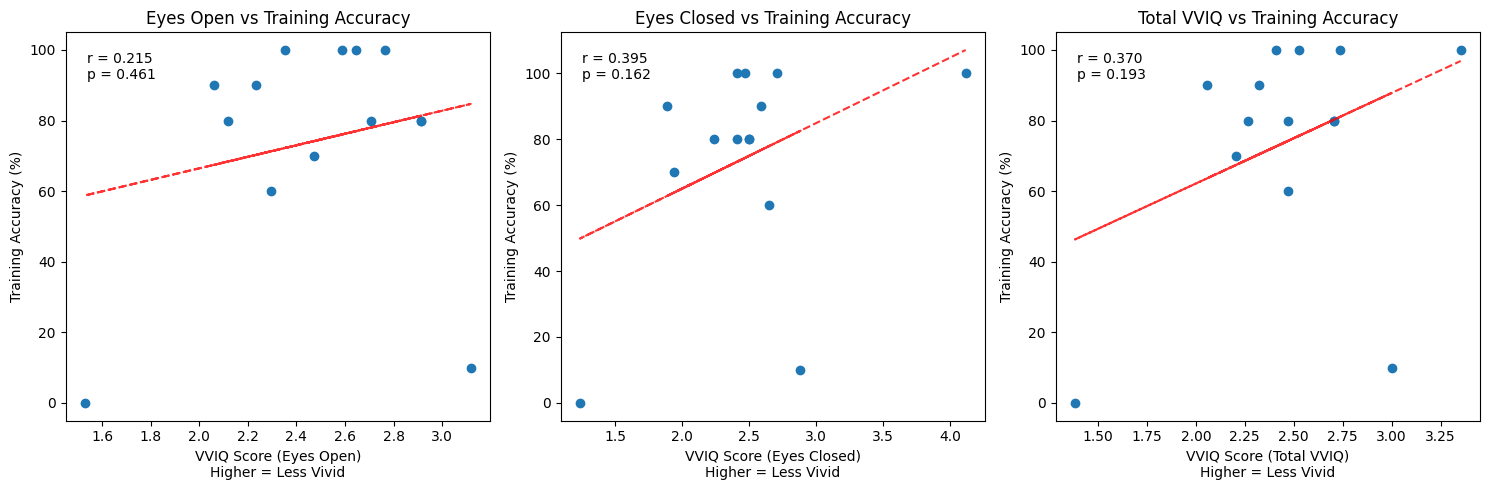

In [13]:
def correlate_vviq_training(clean_dfs, vviq_summary):
    # Get training accuracy and reset index to avoid duplicates
    training_accuracy = clean_dfs['training']['accuracy'].reset_index()
    vviq_data = vviq_summary.reset_index()
    
    # Merge data on participant_id
    correlation_df = pd.merge(
        training_accuracy, 
        vviq_data,
        on='participant_id'
    )
    
    # Calculate correlations
    correlations = {}
    p_values = {}
    for vviq_measure in ['eyes_open_mean', 'eyes_closed_mean', 'total_mean']:
        r, p = stats.pearsonr(correlation_df['accuracy'], 
                            correlation_df[vviq_measure])
        correlations[vviq_measure] = r
        p_values[vviq_measure] = p
    
    # Print results
    print("\nCorrelations with Training Accuracy:")
    for measure in correlations:
        print(f"\n{measure}:")
        print(f"r = {correlations[measure]:.3f}")
        print(f"p = {p_values[measure]:.3f}")
    
    # Create scatter plots
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    measures = ['eyes_open_mean', 'eyes_closed_mean', 'total_mean']
    titles = ['Eyes Open', 'Eyes Closed', 'Total VVIQ']
    
    for ax, measure, title in zip(axes, measures, titles):
        ax.scatter(correlation_df[measure], correlation_df['accuracy'])
        ax.set_xlabel(f'VVIQ Score ({title})\nHigher = Less Vivid')
        ax.set_ylabel('Training Accuracy (%)')
        ax.set_title(f'{title} vs Training Accuracy')
        
        # Add trend line
        z = np.polyfit(correlation_df[measure], correlation_df['accuracy'], 1)
        p = np.poly1d(z)
        ax.plot(correlation_df[measure], p(correlation_df[measure]), "r--", alpha=0.8)
        
        # Add correlation coefficient and p-value
        ax.text(0.05, 0.95, f'r = {correlations[measure]:.3f}\np = {p_values[measure]:.3f}', 
                transform=ax.transAxes, verticalalignment='top')
    
    plt.tight_layout()
    plt.show()
    
    return correlation_df, correlations, p_values

# Run the correlation analysis
from scipy import stats
correlation_results = correlate_vviq_training(clean_dfs, vviq_summary)

Removed 2 participants with accuracy below 50%


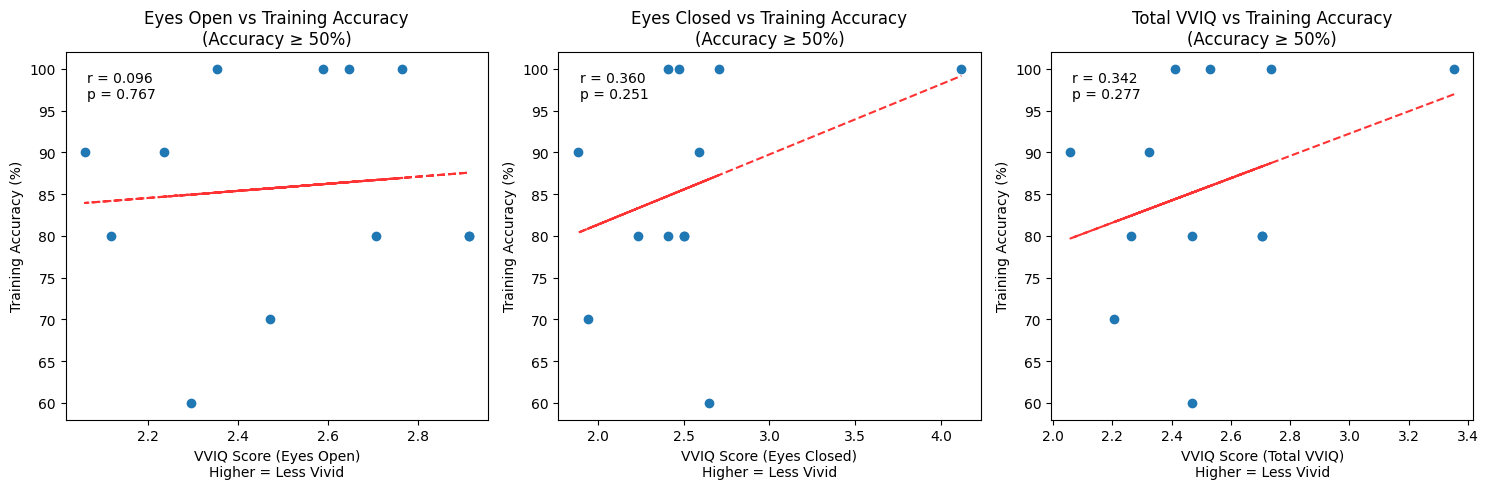

In [14]:
def correlate_vviq_training_filtered(clean_dfs, vviq_summary, accuracy_threshold=50):
    # Get training accuracy and reset index
    training_accuracy = clean_dfs['training']['accuracy'].reset_index()
    vviq_data = vviq_summary.reset_index()
    
    # Merge data and filter by accuracy threshold
    correlation_df = pd.merge(training_accuracy, vviq_data, on='participant_id')
    filtered_df = correlation_df[correlation_df['accuracy'] >= accuracy_threshold]
    
    print(f"Removed {len(correlation_df) - len(filtered_df)} participants with accuracy below {accuracy_threshold}%")
    
    # Calculate correlations with filtered data
    correlations = {}
    p_values = {}
    for vviq_measure in ['eyes_open_mean', 'eyes_closed_mean', 'total_mean']:
        r, p = stats.pearsonr(filtered_df['accuracy'], 
                            filtered_df[vviq_measure])
        correlations[vviq_measure] = r
        p_values[vviq_measure] = p
    
    # Create scatter plots with filtered data
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    measures = ['eyes_open_mean', 'eyes_closed_mean', 'total_mean']
    titles = ['Eyes Open', 'Eyes Closed', 'Total VVIQ']
    
    for ax, measure, title in zip(axes, measures, titles):
        ax.scatter(filtered_df[measure], filtered_df['accuracy'])
        ax.set_xlabel(f'VVIQ Score ({title})\nHigher = Less Vivid')
        ax.set_ylabel('Training Accuracy (%)')
        ax.set_title(f'{title} vs Training Accuracy\n(Accuracy ≥ {accuracy_threshold}%)')
        
        # Add trend line
        z = np.polyfit(filtered_df[measure], filtered_df['accuracy'], 1)
        p = np.poly1d(z)
        ax.plot(filtered_df[measure], p(filtered_df[measure]), "r--", alpha=0.8)
        
        # Add correlation coefficient and p-value
        ax.text(0.05, 0.95, f'r = {correlations[measure]:.3f}\np = {p_values[measure]:.3f}', 
                transform=ax.transAxes, verticalalignment='top')
    
    plt.tight_layout()
    plt.show()
    
    return filtered_df, correlations, p_values

# Run the filtered analysis
filtered_results = correlate_vviq_training_filtered(clean_dfs, vviq_summary, accuracy_threshold=50)


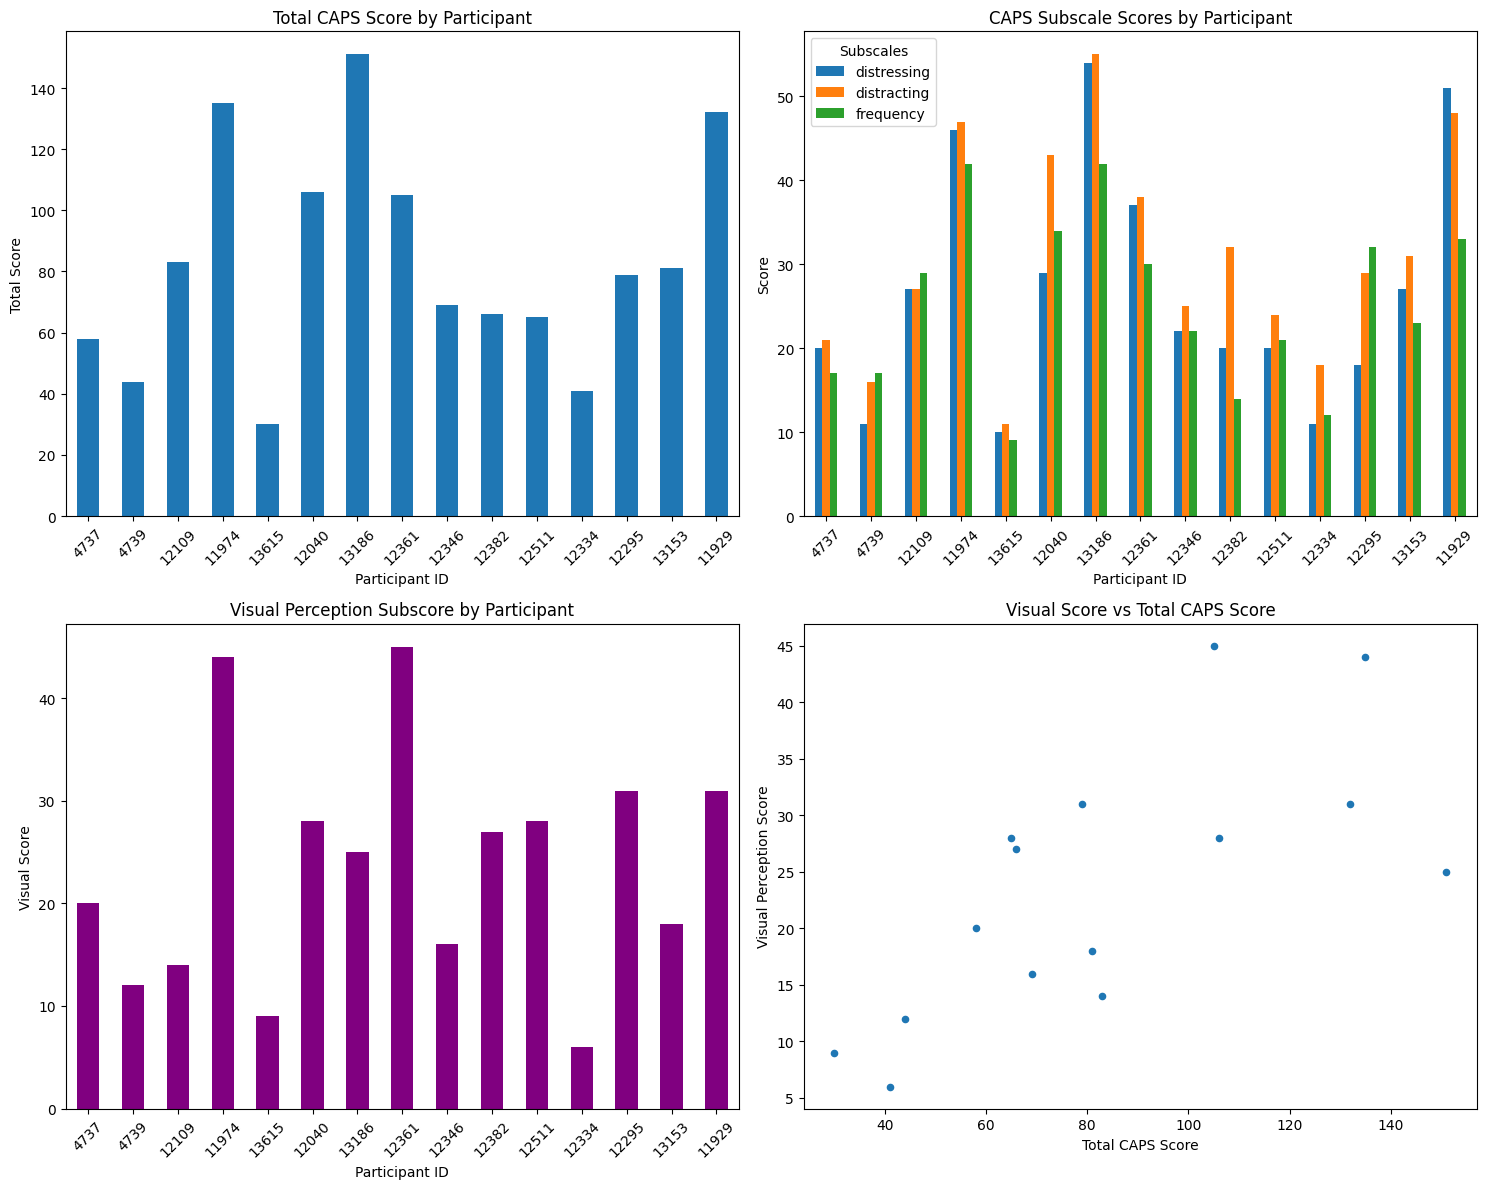


CAPS Score Summary (including Visual Subscale):

Subscale Statistics:
       distressing  distracting  frequency  visual_score  total_score
count        15.00        15.00      15.00         15.00        15.00
mean         26.87        31.00      25.13         23.60        83.00
std          14.20        12.86      10.41         11.61        36.14
min          10.00        11.00       9.00          6.00        30.00
25%          19.00        22.50      17.00         15.00        61.50
50%          22.00        29.00      23.00         25.00        79.00
75%          33.00        40.50      32.50         29.50       105.50
max          54.00        55.00      42.00         45.00       151.00


In [15]:
def analyze_caps_scores(clean_dfs):
    """Analyze CAPS scores with subscales and visual perception items"""
    caps_df = clean_dfs['caps'].copy()
    
    # Define visual perception questions
    visual_questions = [4, 19, 22, 23, 26, 31]
    
    # Initialize subscale scores
    subscale_totals = {}
    for participant_id in caps_df['participant_id'].unique():
        participant_data = caps_df[caps_df['participant_id'] == participant_id]
        
        # Initialize subscale sums
        subscale_sums = {
            'distressing': 0,
            'distracting': 0,
            'frequency': 0,
            'visual_score': 0  # New visual subscore
        }
        
        # Sum up subscales for 'yes' responses
        for _, row in participant_data.iterrows():
            if row['response'] == 'yes' and row['subscale'] is not None:
                for subscale, value in row['subscale'].items():
                    subscale_sums[subscale] += value
                # Add to visual score if it's a visual question
                if row['question_index'] in visual_questions:
                    subscale_sums['visual_score'] += sum(row['subscale'].values())
        
        subscale_totals[participant_id] = subscale_sums
    
    # Convert to DataFrame
    caps_summary = pd.DataFrame.from_dict(subscale_totals, orient='index')
    caps_summary['total_score'] = caps_summary[['distressing', 'distracting', 'frequency']].sum(axis=1)
    
    # Create visualization
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    
    # Plot total scores
    caps_summary['total_score'].plot(kind='bar', ax=ax1)
    ax1.set_title('Total CAPS Score by Participant')
    ax1.set_xlabel('Participant ID')
    ax1.set_ylabel('Total Score')
    ax1.tick_params(axis='x', rotation=45)
    
    # Plot subscale scores
    caps_summary[['distressing', 'distracting', 'frequency']].plot(kind='bar', ax=ax2)
    ax2.set_title('CAPS Subscale Scores by Participant')
    ax2.set_xlabel('Participant ID')
    ax2.set_ylabel('Score')
    ax2.tick_params(axis='x', rotation=45)
    ax2.legend(title='Subscales')
    
    # Plot visual perception scores
    caps_summary['visual_score'].plot(kind='bar', ax=ax3, color='purple')
    ax3.set_title('Visual Perception Subscore by Participant')
    ax3.set_xlabel('Participant ID')
    ax3.set_ylabel('Visual Score')
    ax3.tick_params(axis='x', rotation=45)
    
    # Plot visual score vs total score
    caps_summary.plot(kind='scatter', x='total_score', y='visual_score', ax=ax4)
    ax4.set_title('Visual Score vs Total CAPS Score')
    ax4.set_xlabel('Total CAPS Score')
    ax4.set_ylabel('Visual Perception Score')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\nCAPS Score Summary (including Visual Subscale):")
    print("\nSubscale Statistics:")
    print(caps_summary.describe().round(2))
    
    return caps_summary

# Run the analysis
caps_summary = analyze_caps_scores(clean_dfs)

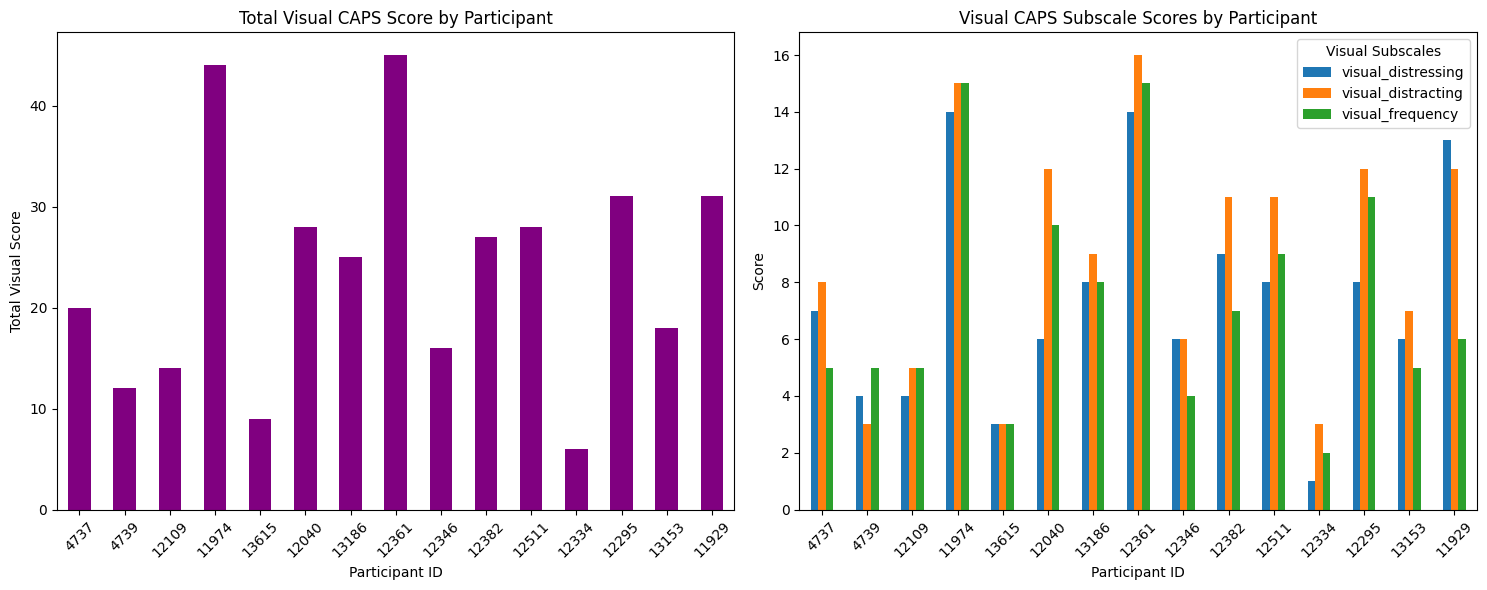


Visual CAPS Subscale Summary:

Subscale Statistics:
       visual_distressing  visual_distracting  visual_frequency  visual_total
count               15.00               15.00             15.00         15.00
mean                 7.40                8.87              7.33         23.60
std                  3.89                4.29              3.99         11.61
min                  1.00                3.00              2.00          6.00
25%                  5.00                5.50              5.00         15.00
50%                  7.00                9.00              6.00         25.00
75%                  8.50               12.00              9.50         29.50
max                 14.00               16.00             15.00         45.00


In [16]:
def analyze_caps_visual_scores(clean_dfs):
    """Analyze CAPS visual scores with detailed subscale breakdown"""
    caps_df = clean_dfs['caps'].copy()
    
    # Define visual perception questions
    visual_questions = [4, 19, 22, 23, 26, 31]
    
    # Initialize visual subscale scores
    visual_subscale_totals = {}
    for participant_id in caps_df['participant_id'].unique():
        participant_data = caps_df[caps_df['participant_id'] == participant_id]
        
        # Initialize visual subscale sums
        visual_sums = {
            'visual_distressing': 0,
            'visual_distracting': 0,
            'visual_frequency': 0
        }
        
        # Sum up subscales for visual questions only
        for _, row in participant_data.iterrows():
            if (row['question_index'] in visual_questions and 
                row['response'] == 'yes' and 
                row['subscale'] is not None):
                visual_sums['visual_distressing'] += row['subscale']['distressing']
                visual_sums['visual_distracting'] += row['subscale']['distracting']
                visual_sums['visual_frequency'] += row['subscale']['frequency']
        
        visual_subscale_totals[participant_id] = visual_sums
    
    # Convert to DataFrame
    visual_summary = pd.DataFrame.from_dict(visual_subscale_totals, orient='index')
    visual_summary['visual_total'] = visual_summary.sum(axis=1)
    
    # Create visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot total visual scores
    visual_summary['visual_total'].plot(kind='bar', ax=ax1, color='purple')
    ax1.set_title('Total Visual CAPS Score by Participant')
    ax1.set_xlabel('Participant ID')
    ax1.set_ylabel('Total Visual Score')
    ax1.tick_params(axis='x', rotation=45)
    
    # Plot visual subscale scores
    visual_summary[['visual_distressing', 'visual_distracting', 'visual_frequency']].plot(
        kind='bar', ax=ax2)
    ax2.set_title('Visual CAPS Subscale Scores by Participant')
    ax2.set_xlabel('Participant ID')
    ax2.set_ylabel('Score')
    ax2.tick_params(axis='x', rotation=45)
    ax2.legend(title='Visual Subscales')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\nVisual CAPS Subscale Summary:")
    print("\nSubscale Statistics:")
    print(visual_summary.describe().round(2))
    
    return visual_summary

# Run the visual analysis
visual_caps_summary = analyze_caps_visual_scores(clean_dfs)

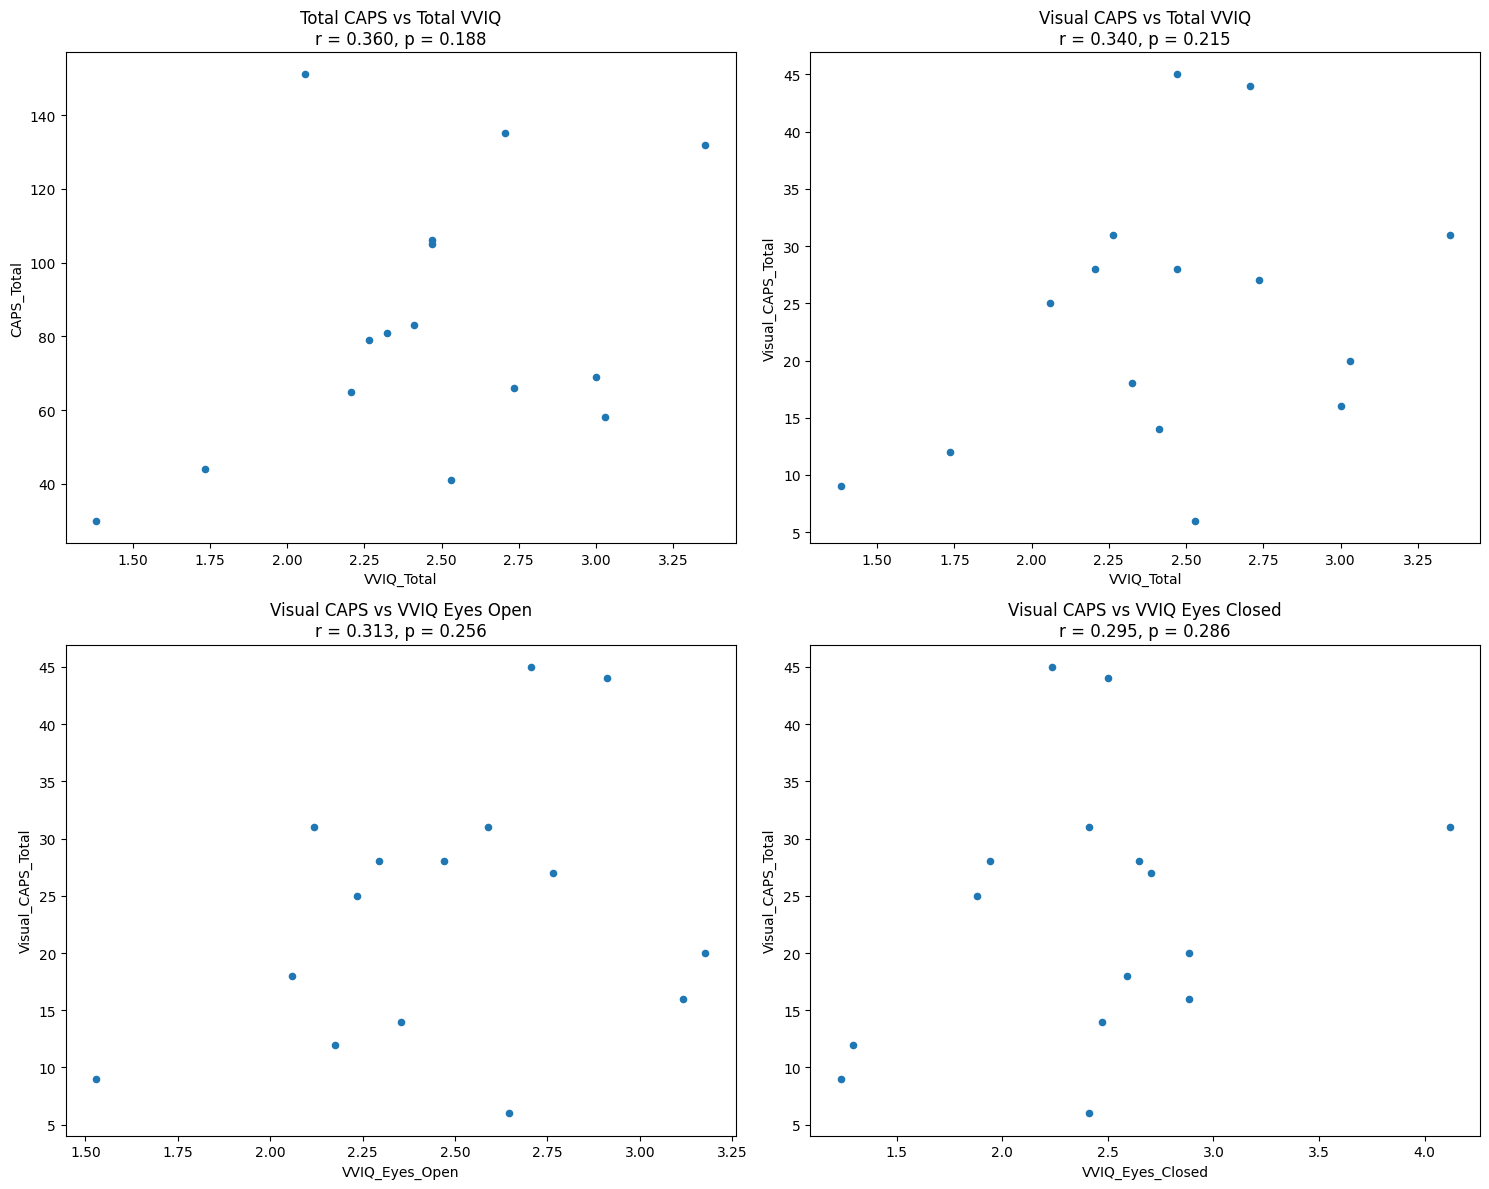

In [17]:
def correlate_caps_vviq(caps_summary, visual_caps_summary, vviq_summary):
    # Prepare correlation data
    correlation_df = pd.DataFrame({
        'VVIQ_Eyes_Open': vviq_summary['eyes_open_mean'],
        'VVIQ_Eyes_Closed': vviq_summary['eyes_closed_mean'],
        'VVIQ_Total': vviq_summary['total_mean'],
        'CAPS_Total': caps_summary['total_score'],
        'Visual_CAPS_Total': visual_caps_summary['visual_total']
    })
    
    # Calculate correlations
    correlations = {}
    p_values = {}
    for caps_measure in ['CAPS_Total', 'Visual_CAPS_Total']:
        for vviq_measure in ['VVIQ_Eyes_Open', 'VVIQ_Eyes_Closed', 'VVIQ_Total']:
            r, p = stats.pearsonr(correlation_df[vviq_measure], 
                                correlation_df[caps_measure])
            correlations[f"{caps_measure}_{vviq_measure}"] = r
            p_values[f"{caps_measure}_{vviq_measure}"] = p
    
    # Create visualization
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    
    # Total CAPS vs VVIQ
    correlation_df.plot.scatter('VVIQ_Total', 'CAPS_Total', ax=ax1)
    r = correlations['CAPS_Total_VVIQ_Total']
    p = p_values['CAPS_Total_VVIQ_Total']
    ax1.set_title(f'Total CAPS vs Total VVIQ\nr = {r:.3f}, p = {p:.3f}')
    
    # Visual CAPS vs VVIQ
    correlation_df.plot.scatter('VVIQ_Total', 'Visual_CAPS_Total', ax=ax2)
    r = correlations['Visual_CAPS_Total_VVIQ_Total']
    p = p_values['Visual_CAPS_Total_VVIQ_Total']
    ax2.set_title(f'Visual CAPS vs Total VVIQ\nr = {r:.3f}, p = {p:.3f}')
    
    # Eyes Open correlations
    correlation_df.plot.scatter('VVIQ_Eyes_Open', 'Visual_CAPS_Total', ax=ax3)
    r = correlations['Visual_CAPS_Total_VVIQ_Eyes_Open']
    p = p_values['Visual_CAPS_Total_VVIQ_Eyes_Open']
    ax3.set_title(f'Visual CAPS vs VVIQ Eyes Open\nr = {r:.3f}, p = {p:.3f}')
    
    # Eyes Closed correlations
    correlation_df.plot.scatter('VVIQ_Eyes_Closed', 'Visual_CAPS_Total', ax=ax4)
    r = correlations['Visual_CAPS_Total_VVIQ_Eyes_Closed']
    p = p_values['Visual_CAPS_Total_VVIQ_Eyes_Closed']
    ax4.set_title(f'Visual CAPS vs VVIQ Eyes Closed\nr = {r:.3f}, p = {p:.3f}')
    
    plt.tight_layout()
    plt.show()
    
    return correlation_df, correlations, p_values

# Run the correlation analysis
correlation_results = correlate_caps_vviq(caps_summary, visual_caps_summary, vviq_summary)


In [18]:
def categorize_vviq(vviq_summary):
    thresholds = {
        'low': (1.0, 2.0),    # More vivid imagery
        'medium': (2.0, 3.0),  # Moderate imagery
        'high': (3.0, 4.0)     # Less vivid imagery
    }
    
    vviq_summary['group'] = 'unknown'
    for group, (lower, upper) in thresholds.items():
        vviq_summary.loc[(vviq_summary['total_mean'] >= lower) & 
                        (vviq_summary['total_mean'] < upper), 'group'] = group
    
    return vviq_summary



Classification Images for Group: high_vivid
Number of participants: 2

Participant 4739 (VVIQ Score: 1.74)


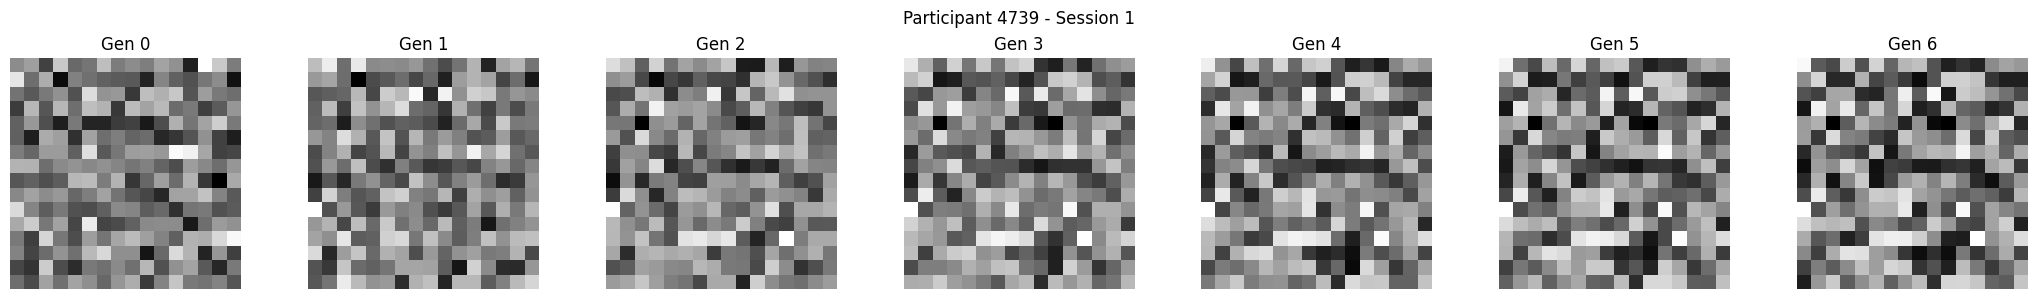

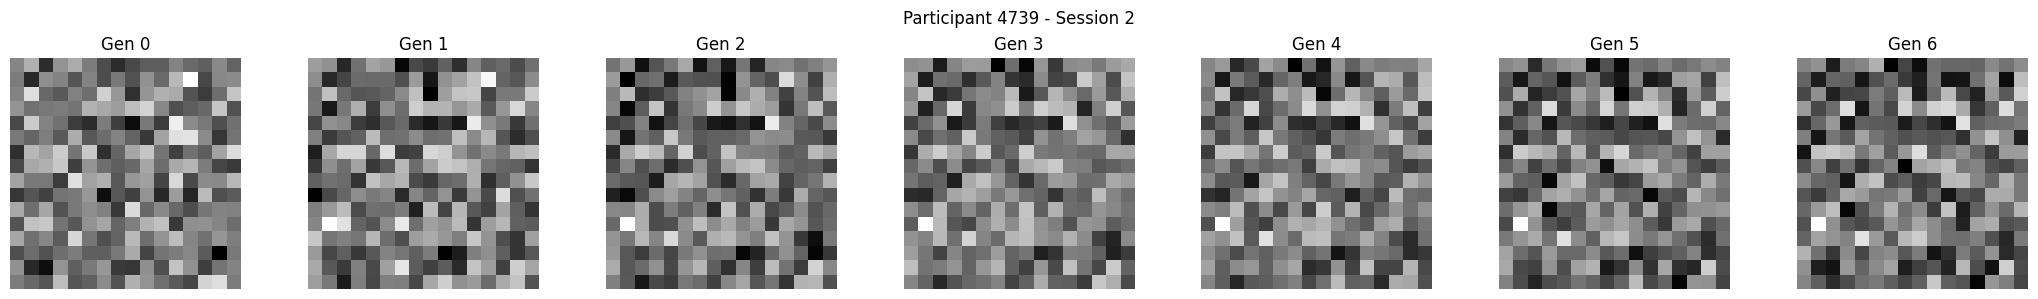

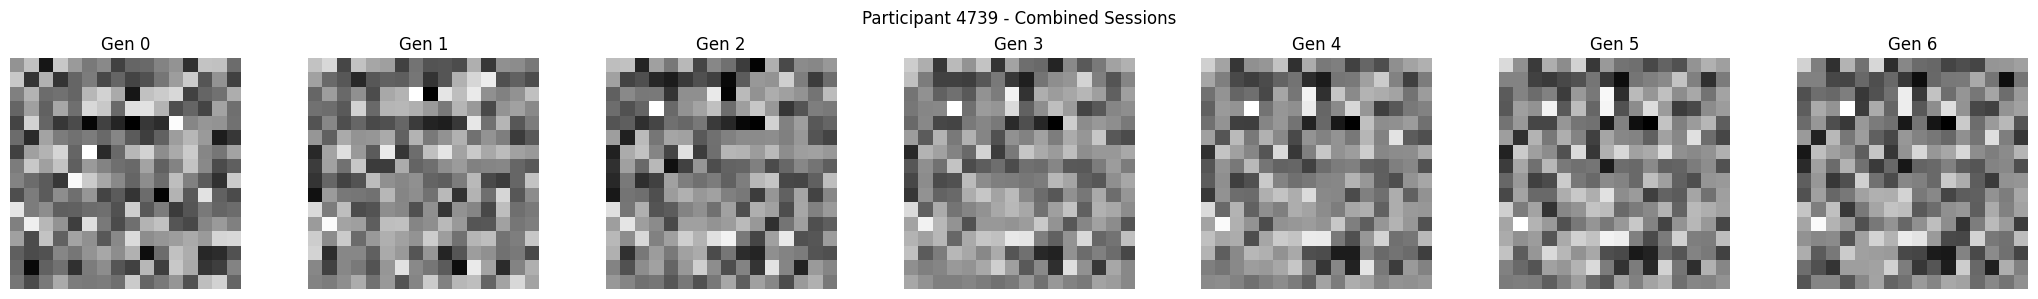


Participant 13615 (VVIQ Score: 1.38)


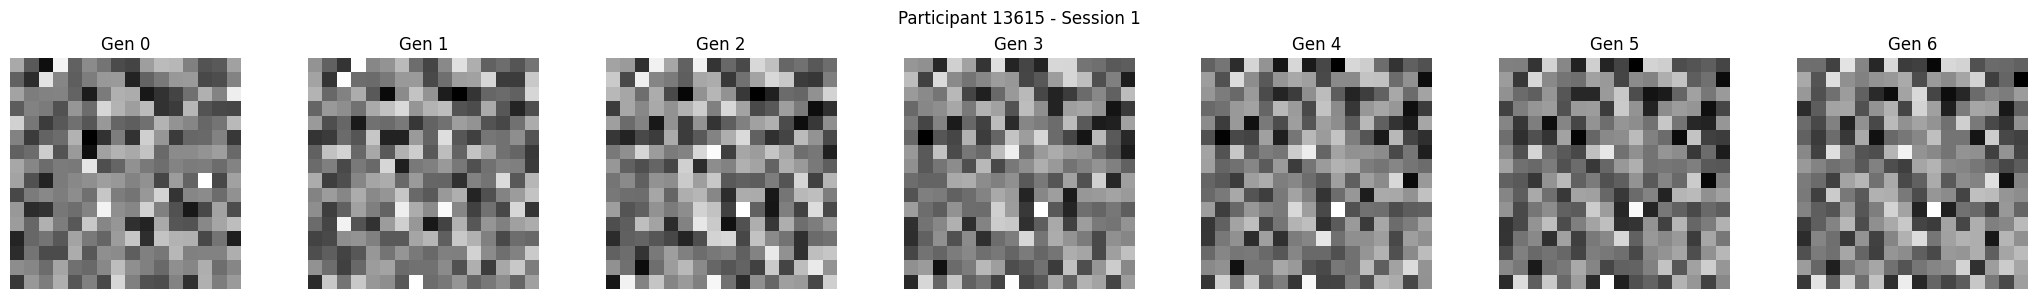

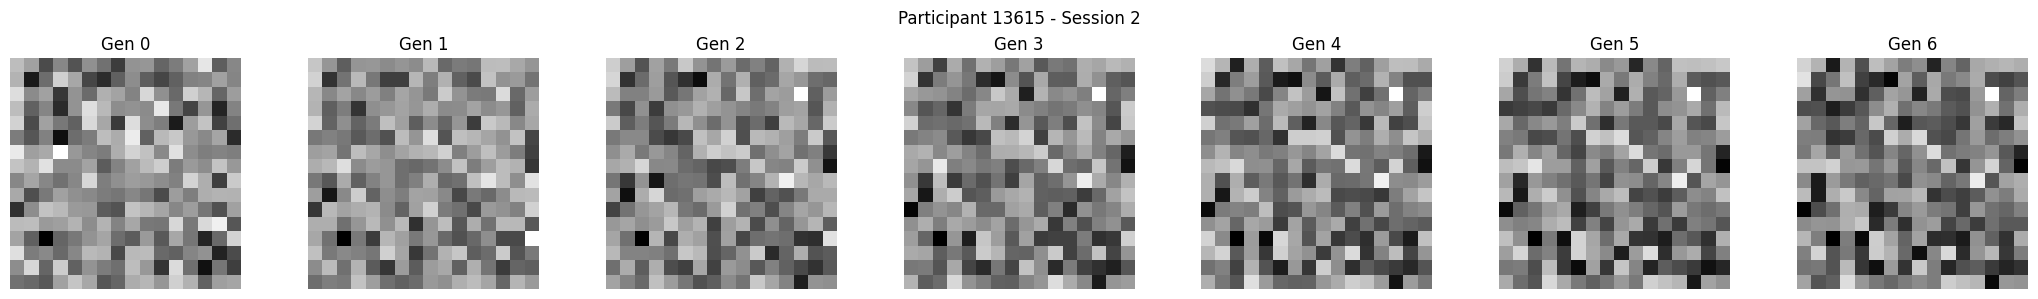

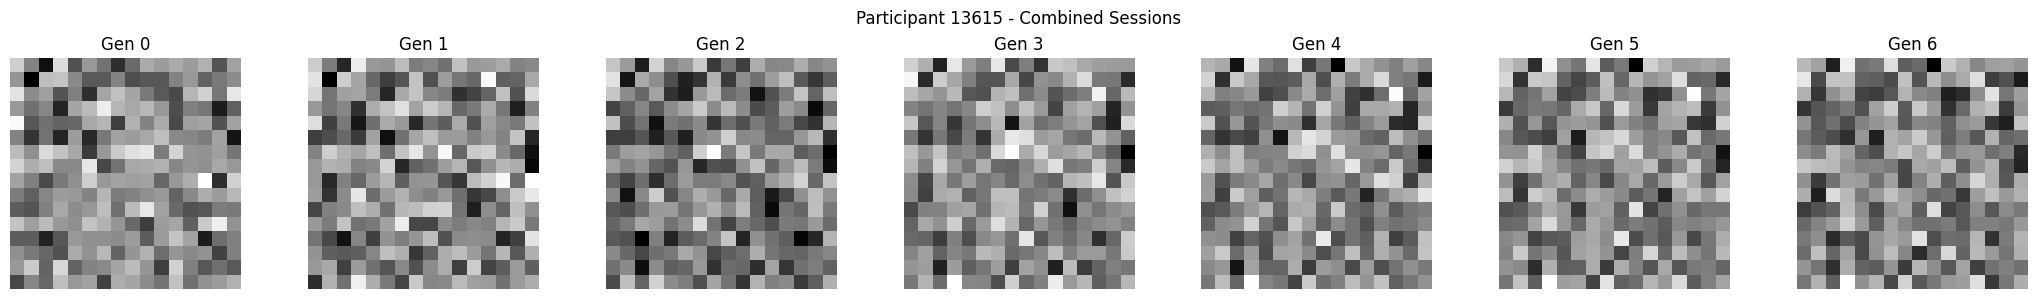


Classification Images for Group: medium_vivid
Number of participants: 10

Participant 12109 (VVIQ Score: 2.41)


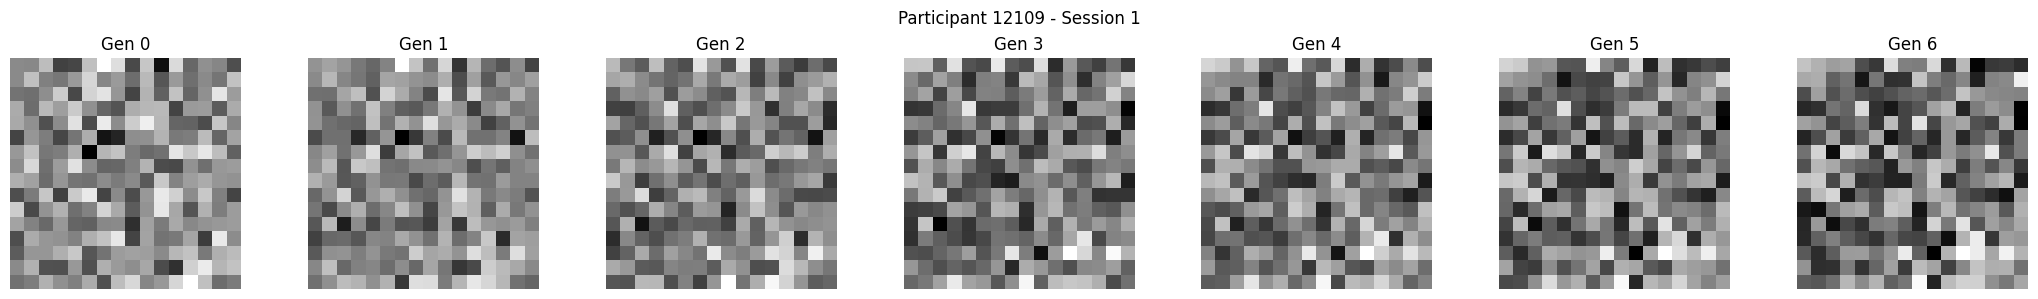

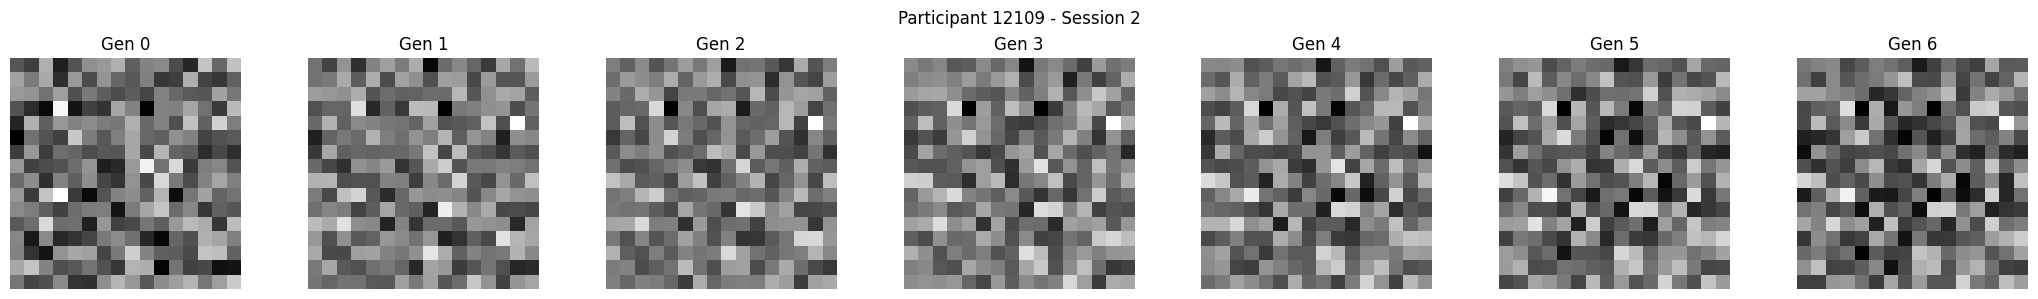

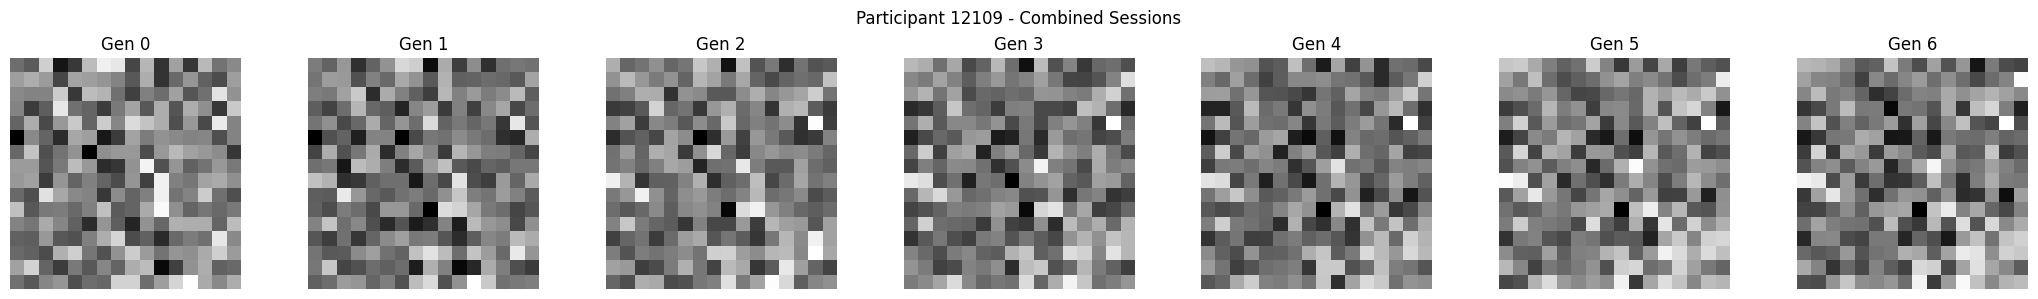


Participant 11974 (VVIQ Score: 2.71)


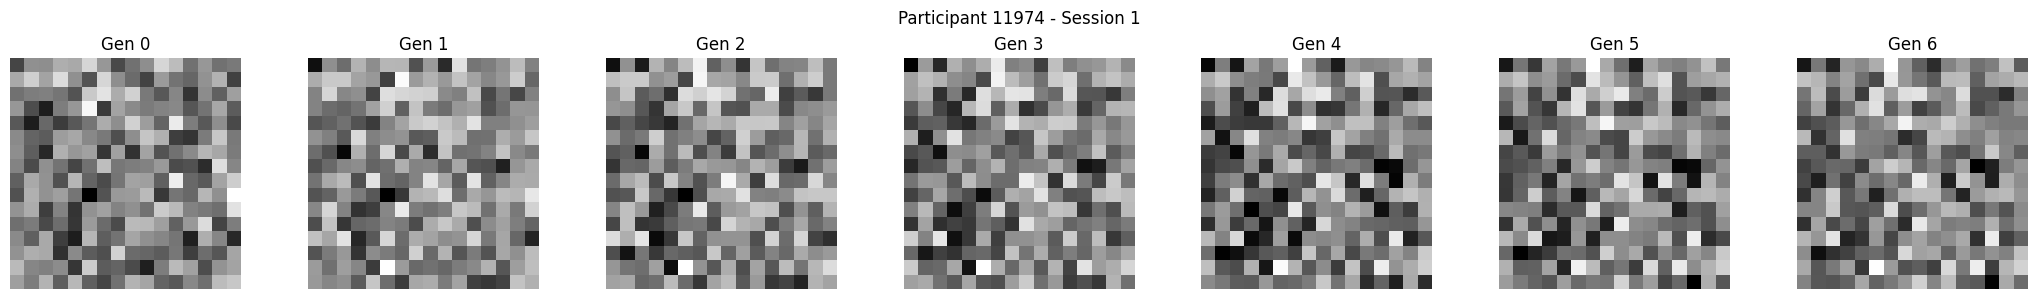

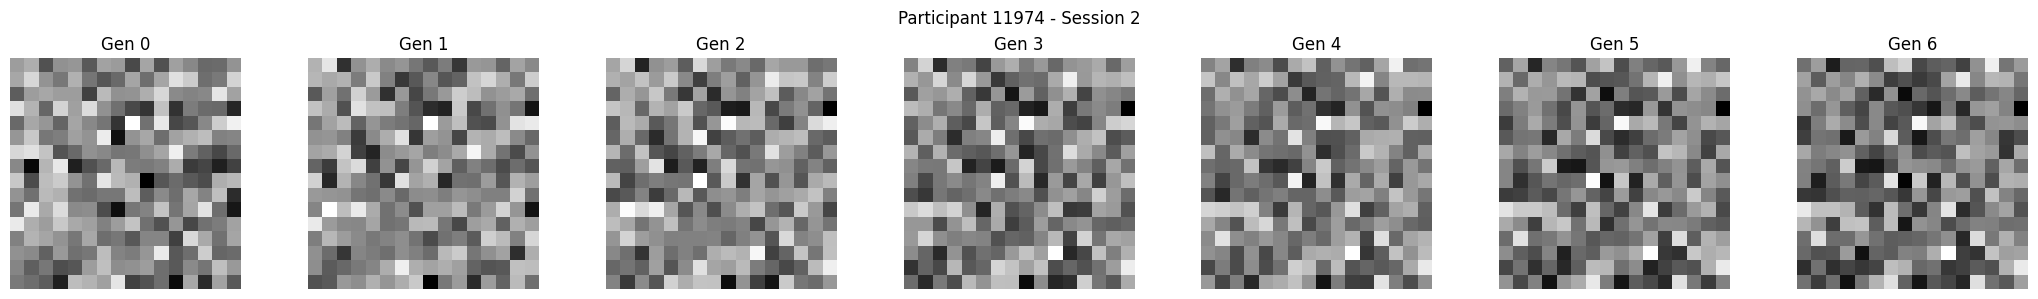

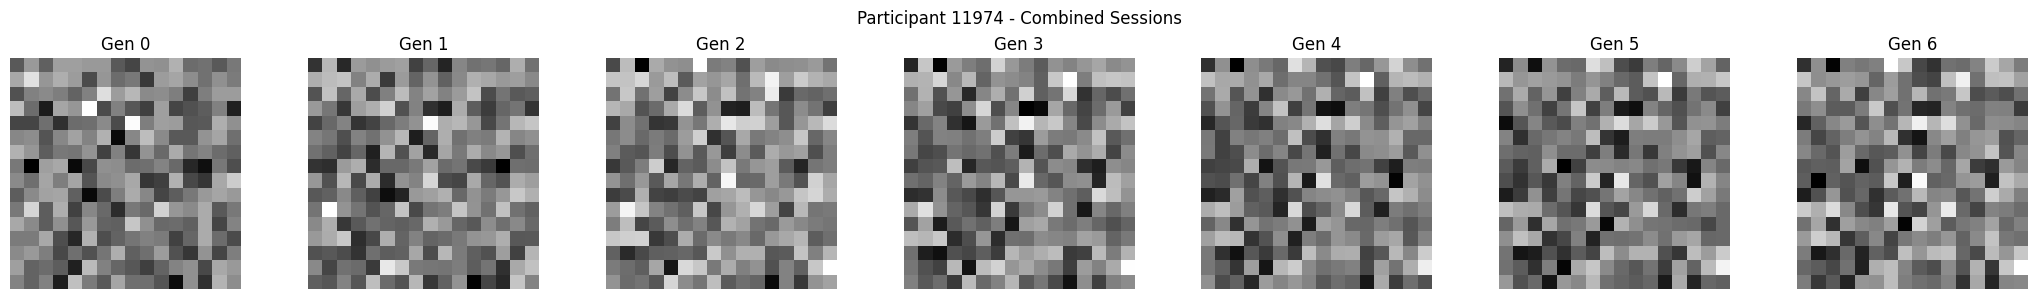


Participant 12040 (VVIQ Score: 2.47)


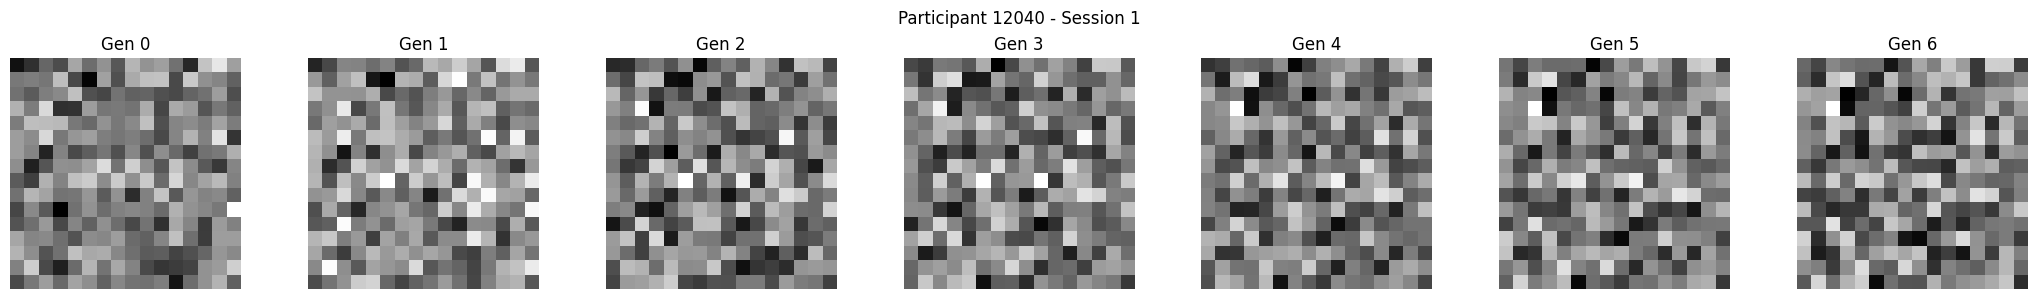

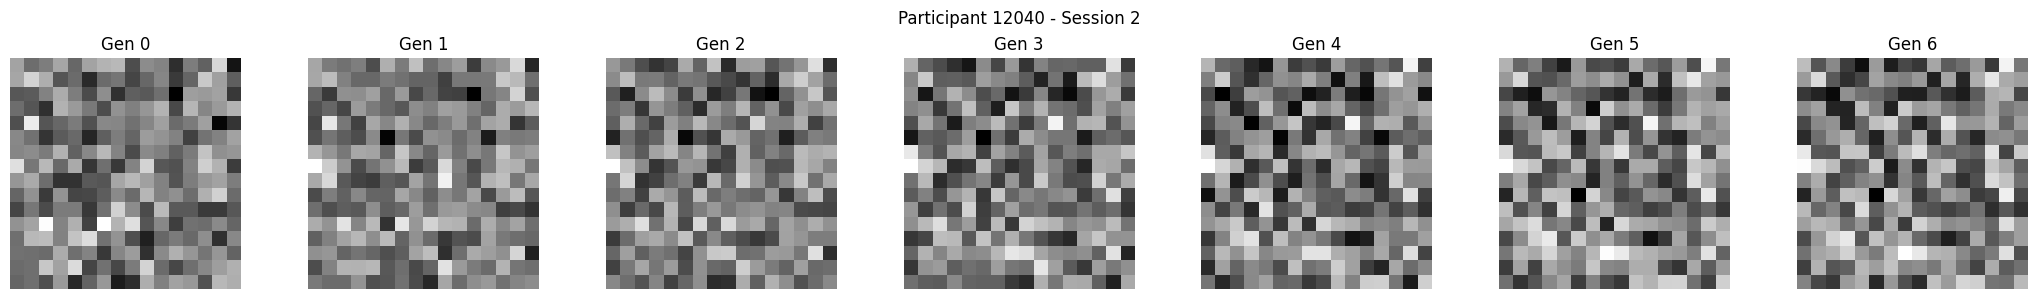

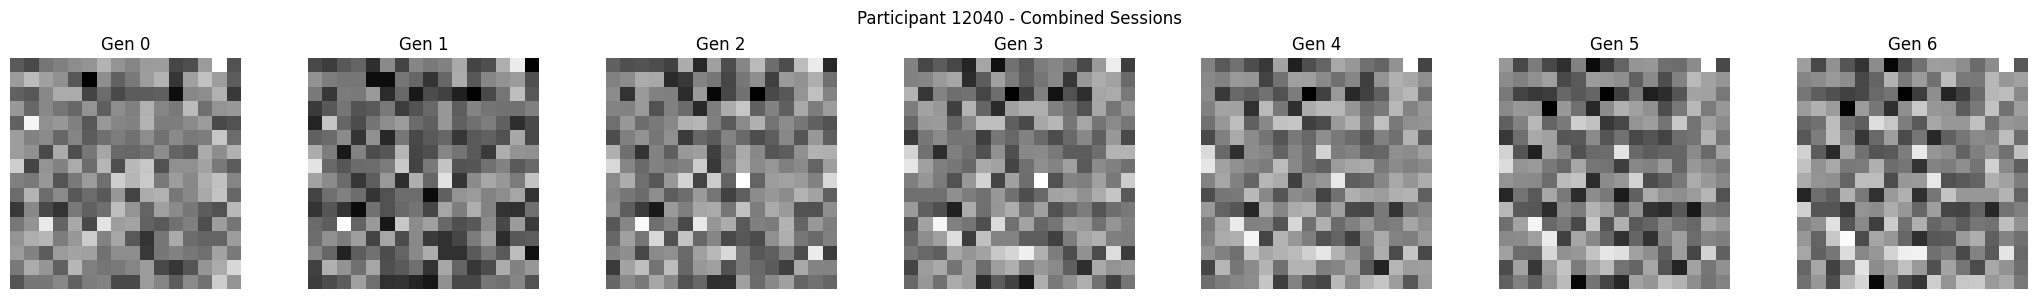


Participant 13186 (VVIQ Score: 2.06)


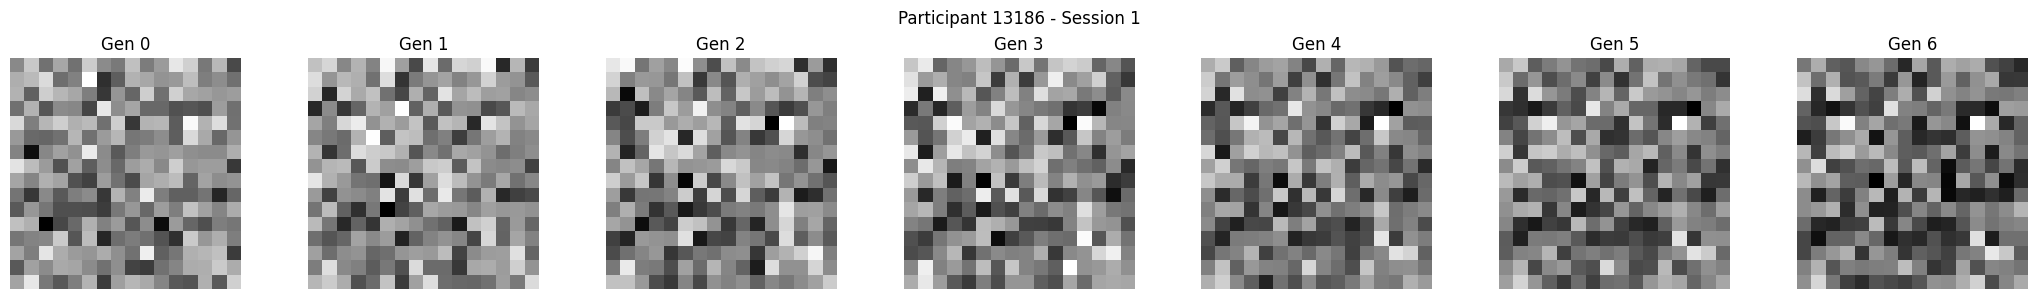

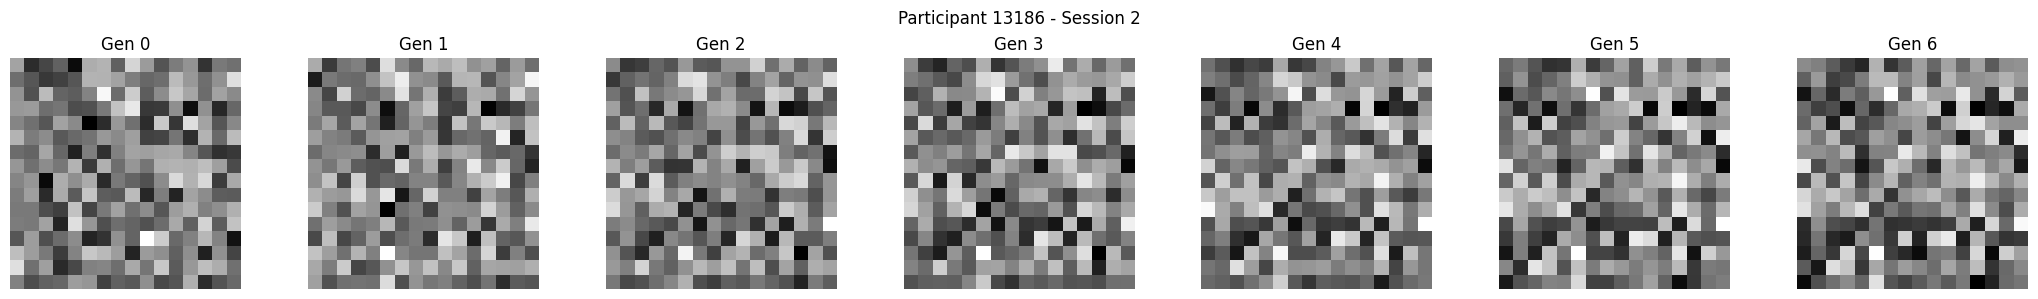

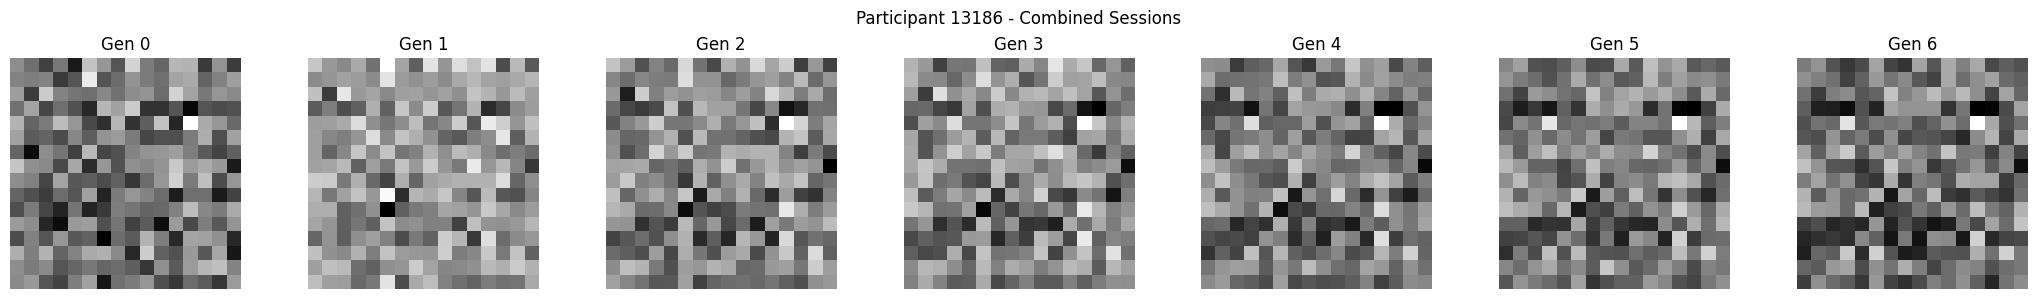


Participant 12361 (VVIQ Score: 2.47)


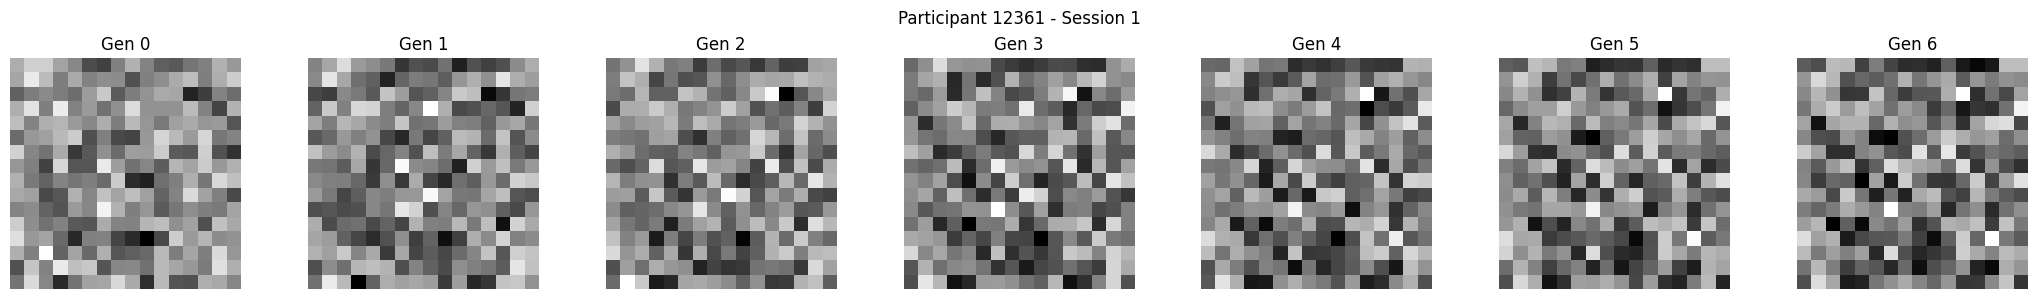

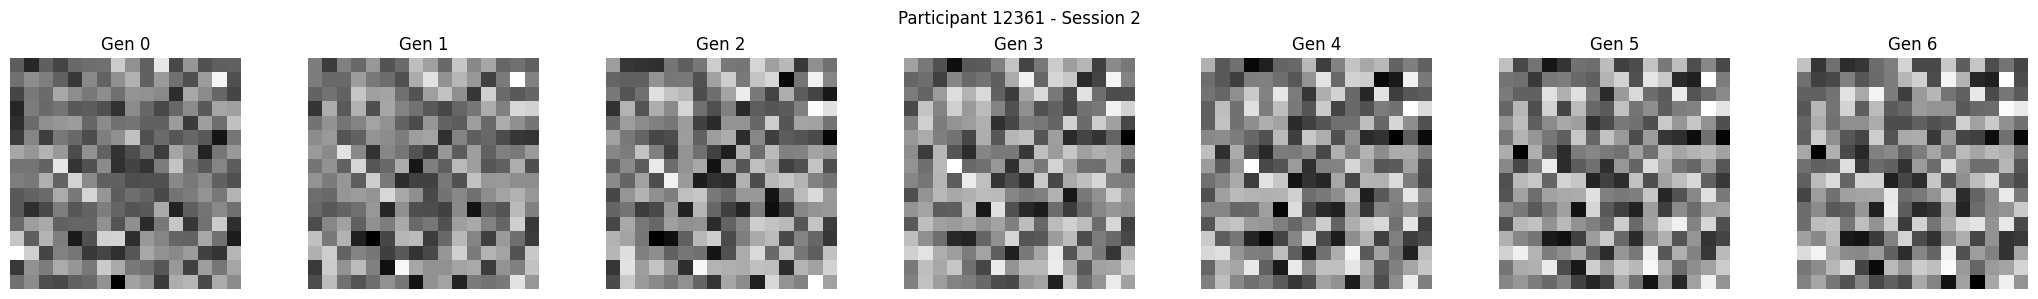

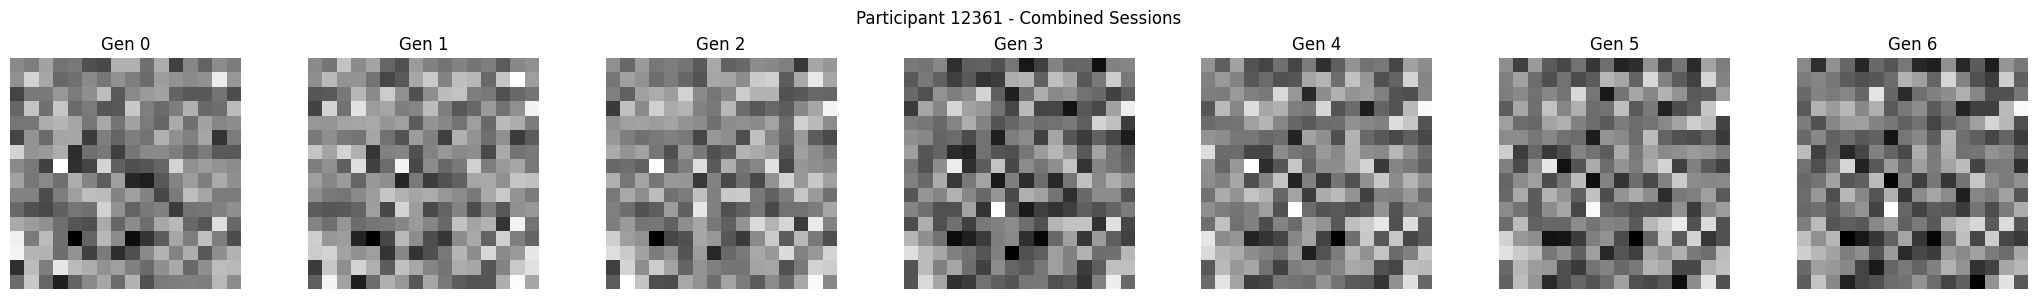


Participant 12382 (VVIQ Score: 2.74)


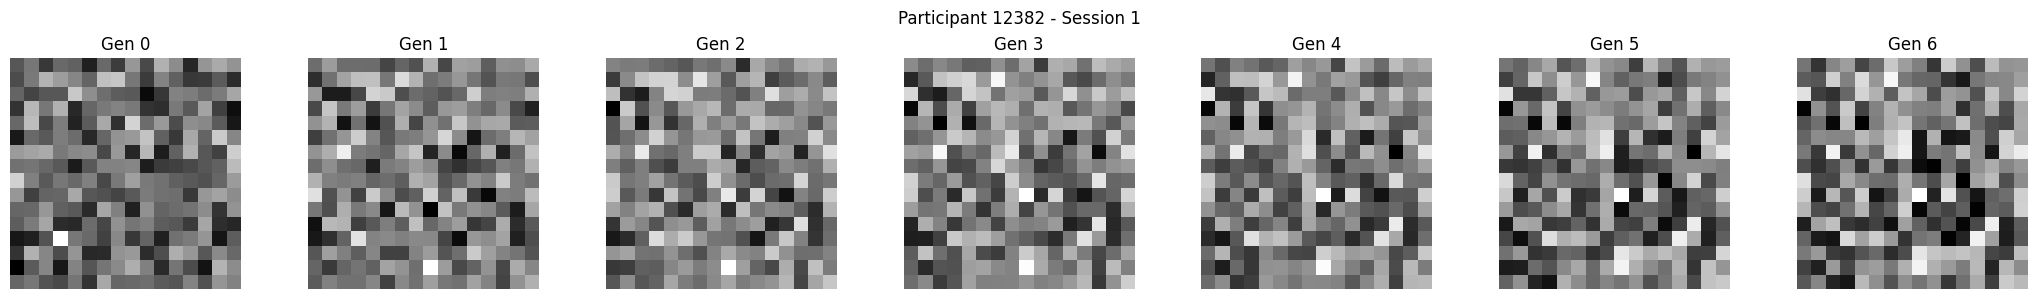

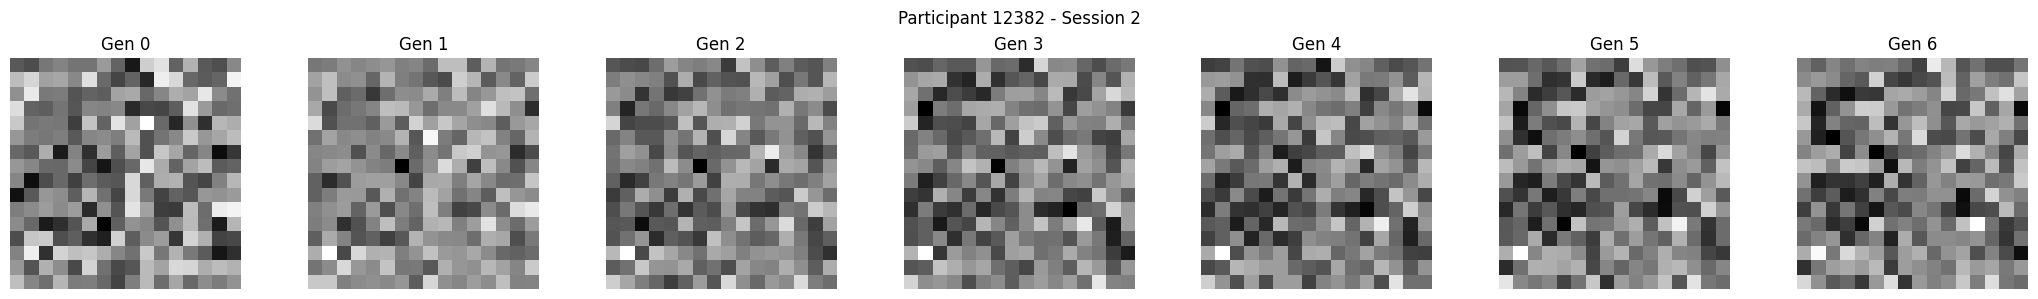

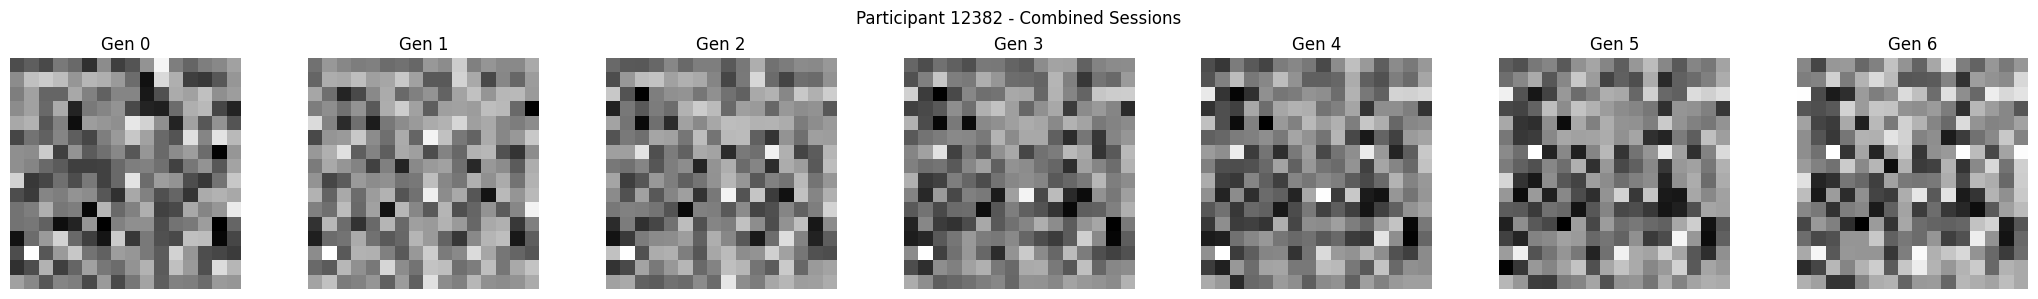


Participant 12511 (VVIQ Score: 2.21)


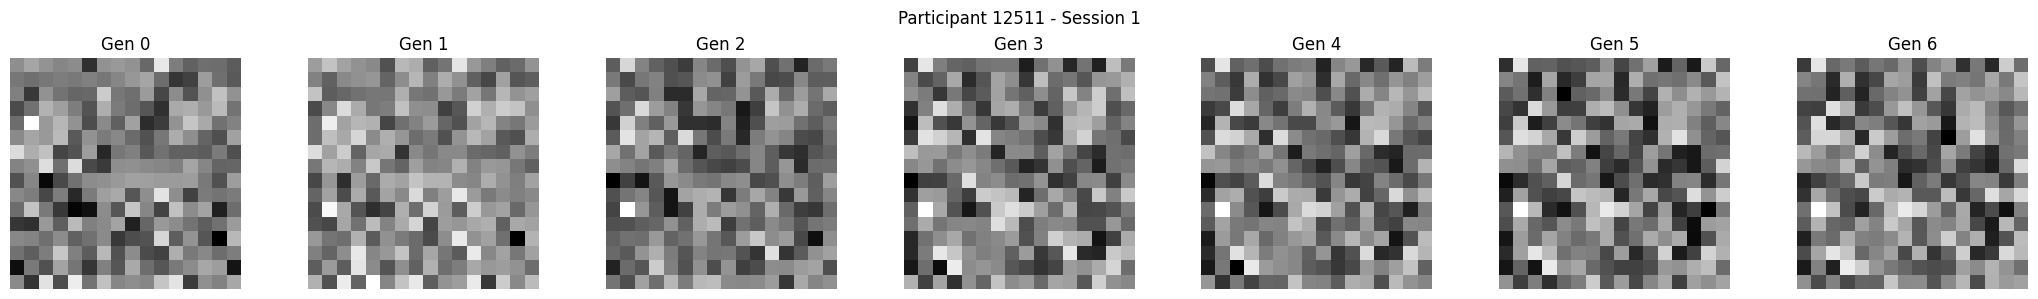

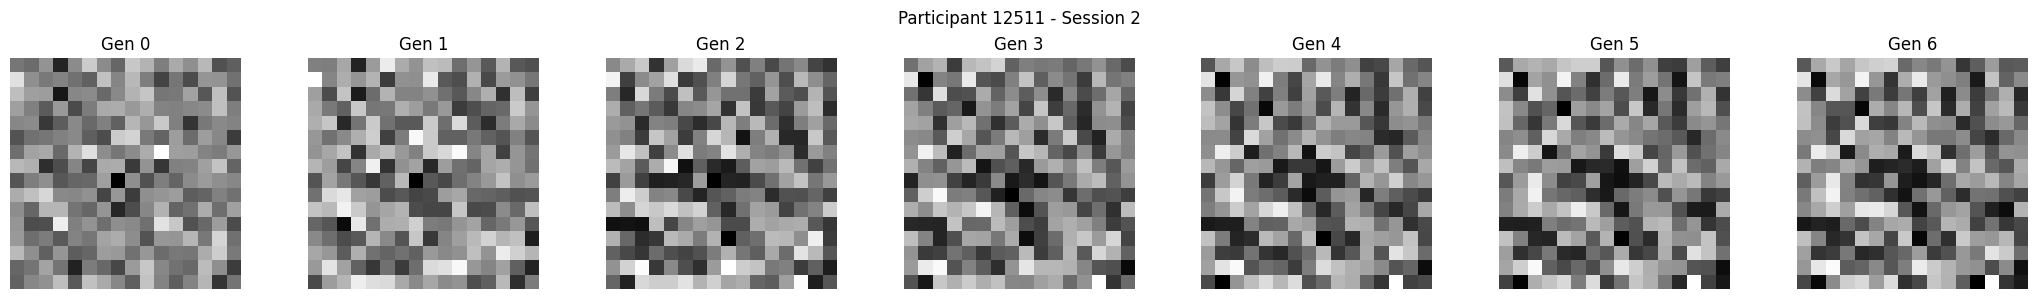

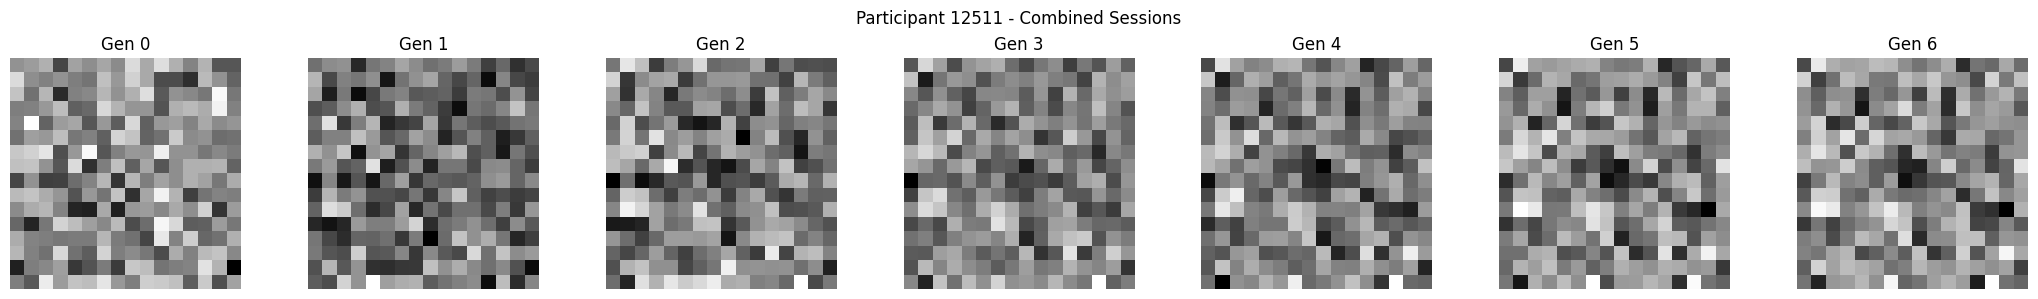


Participant 12334 (VVIQ Score: 2.53)


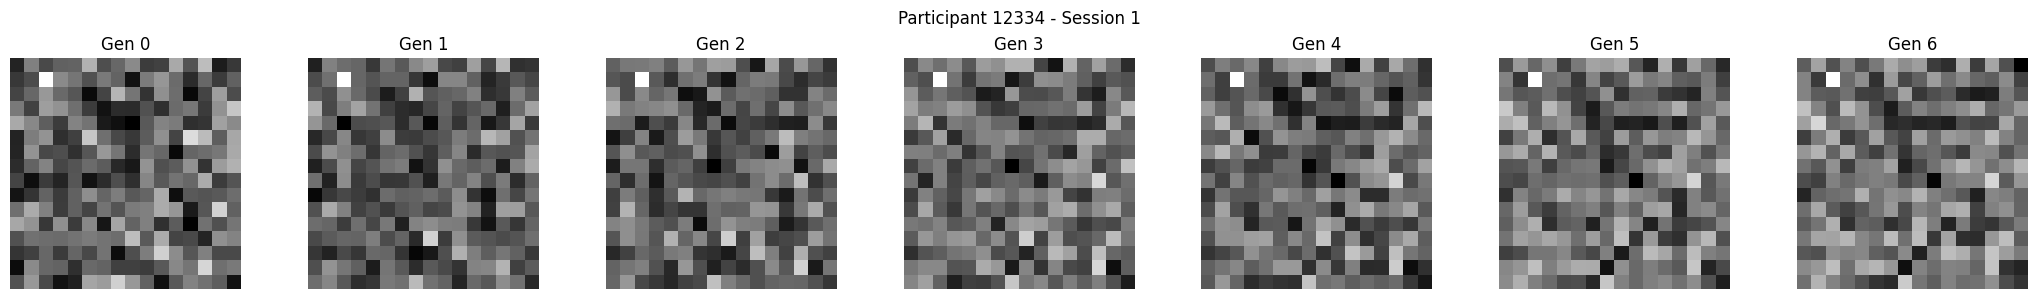

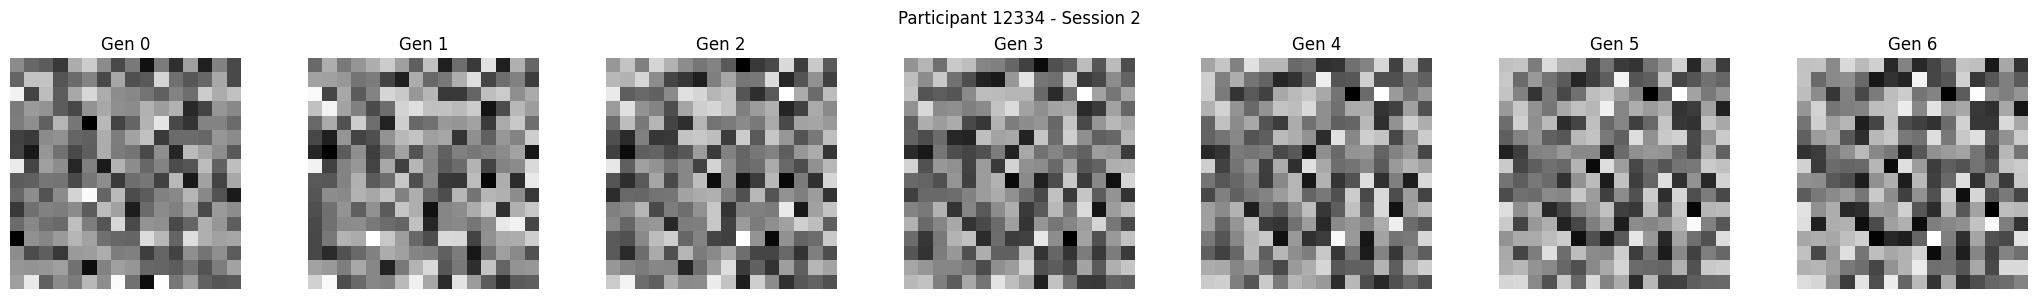

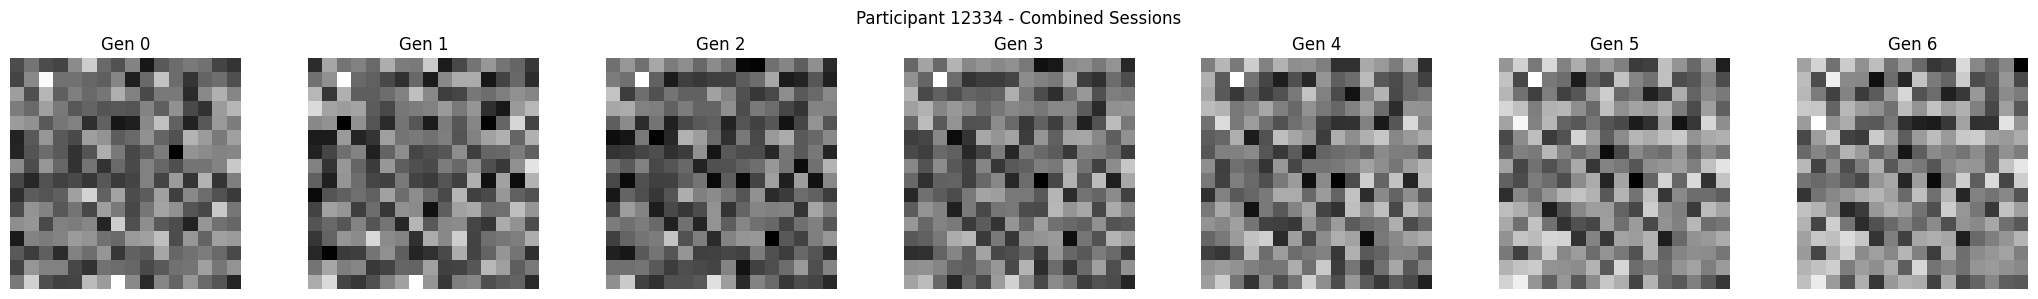


Participant 12295 (VVIQ Score: 2.26)


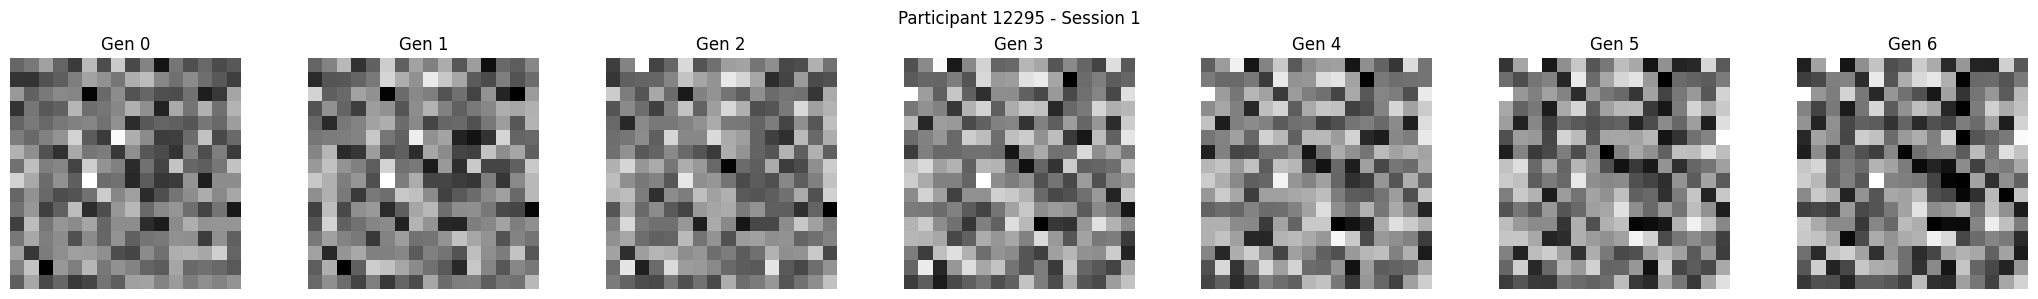

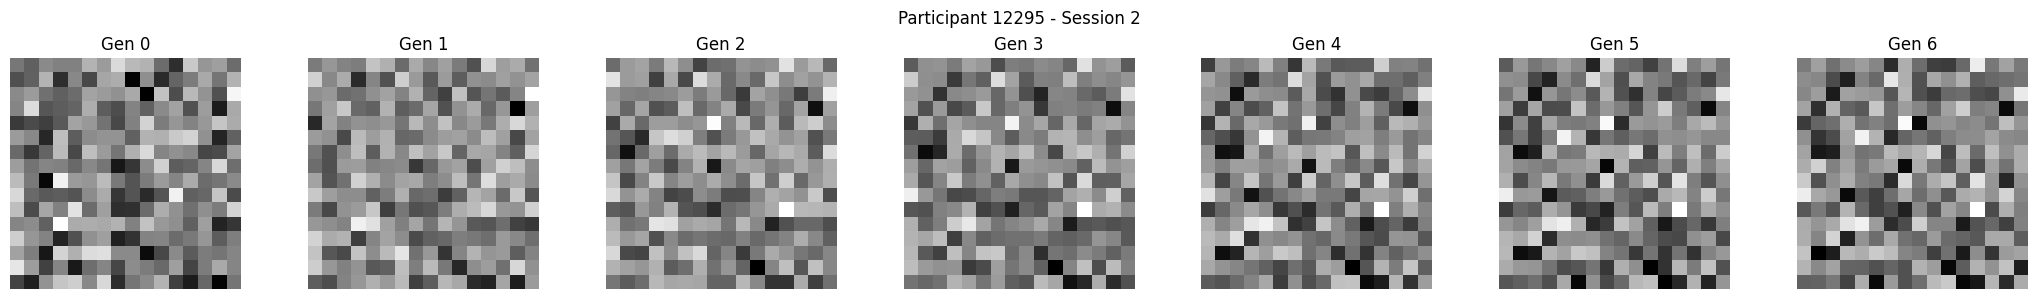

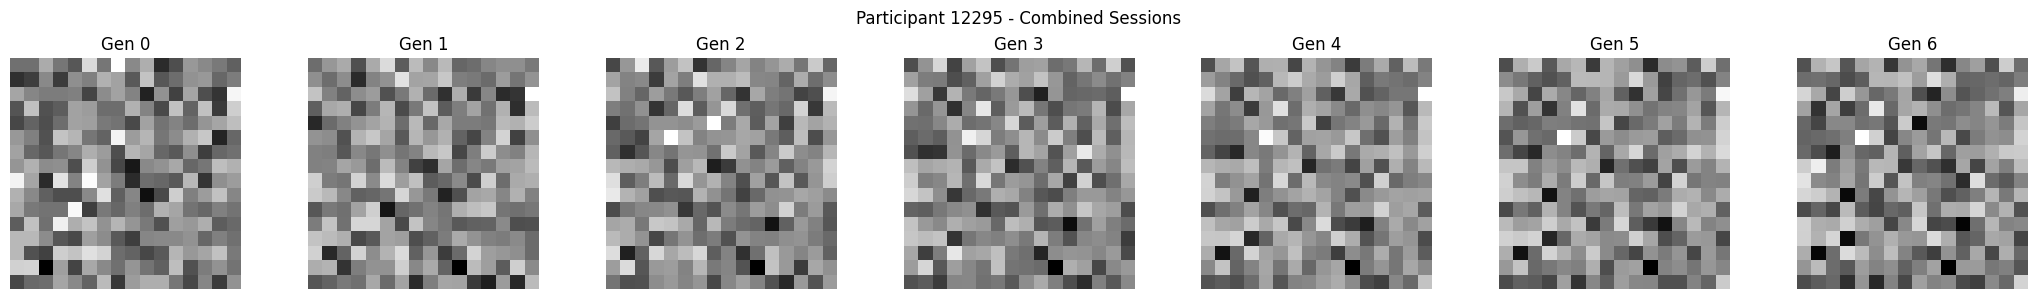


Participant 13153 (VVIQ Score: 2.32)


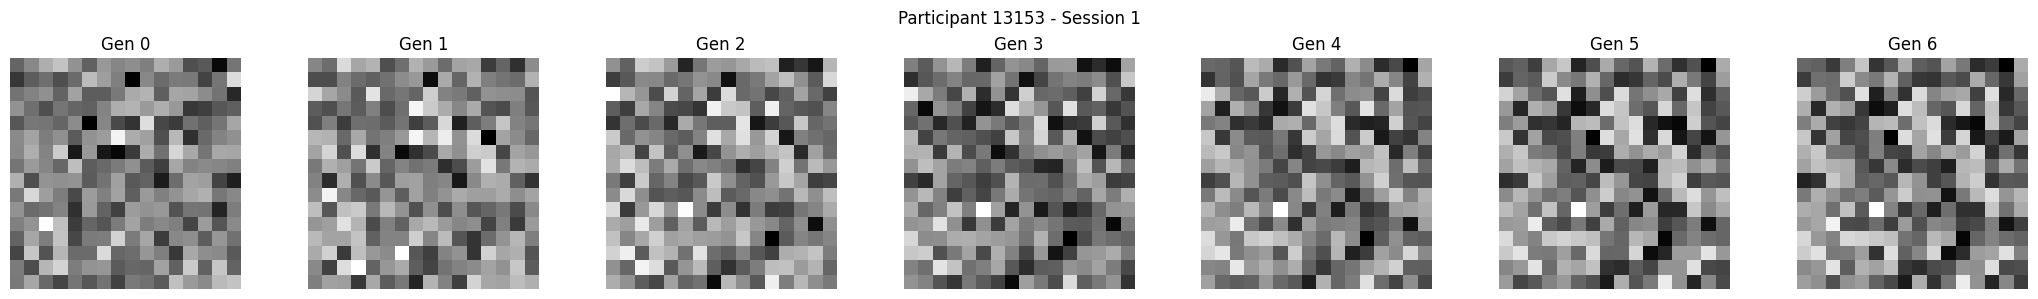

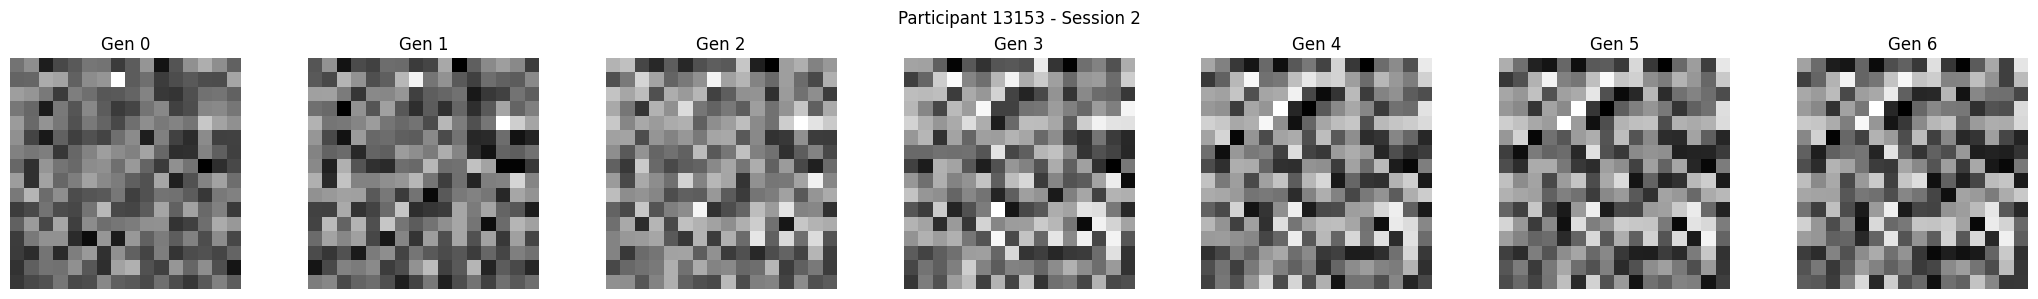

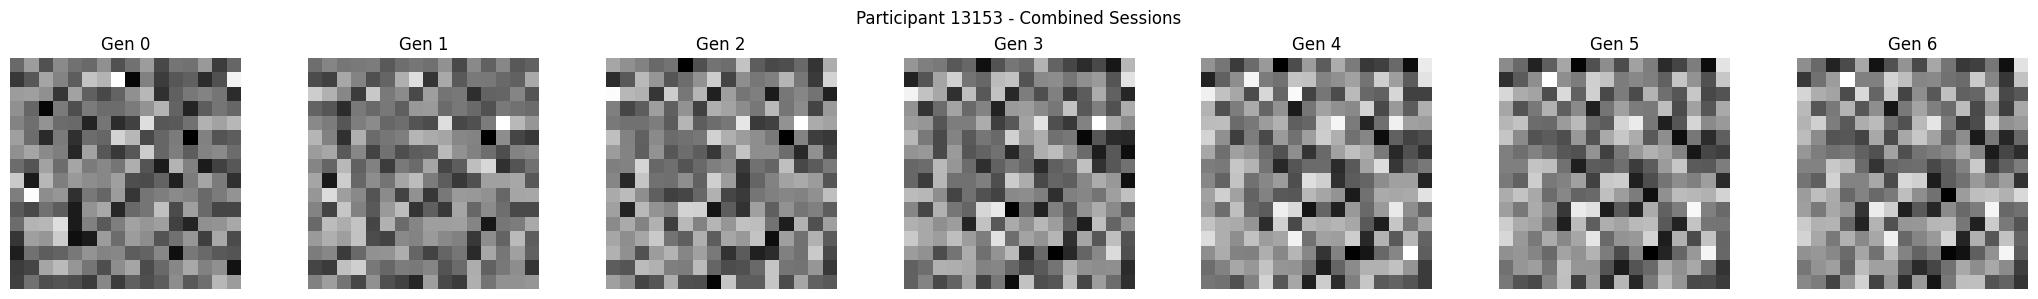


Classification Images for Group: low_vivid
Number of participants: 3

Participant 4737 (VVIQ Score: 3.03)


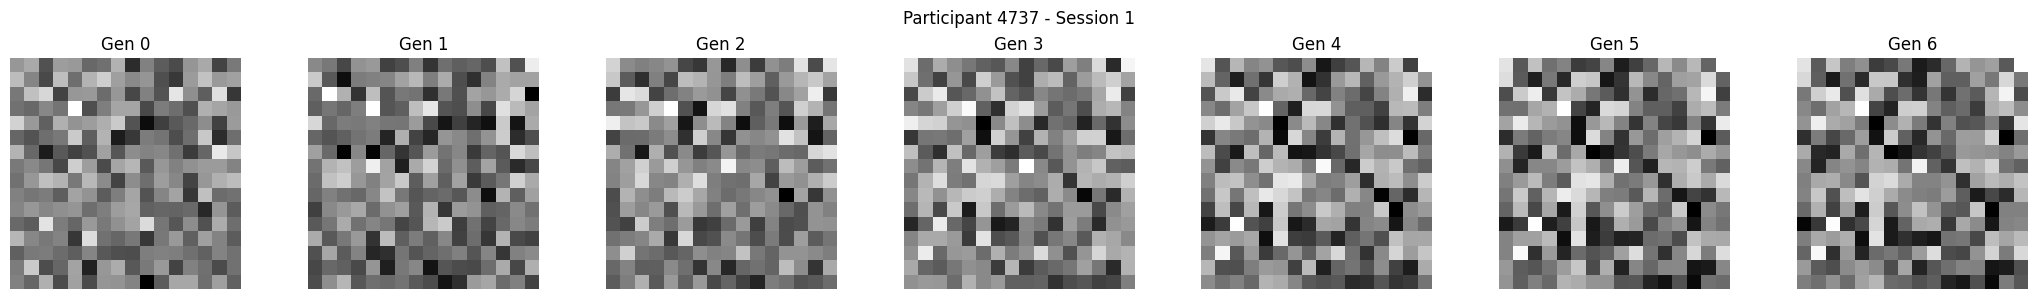

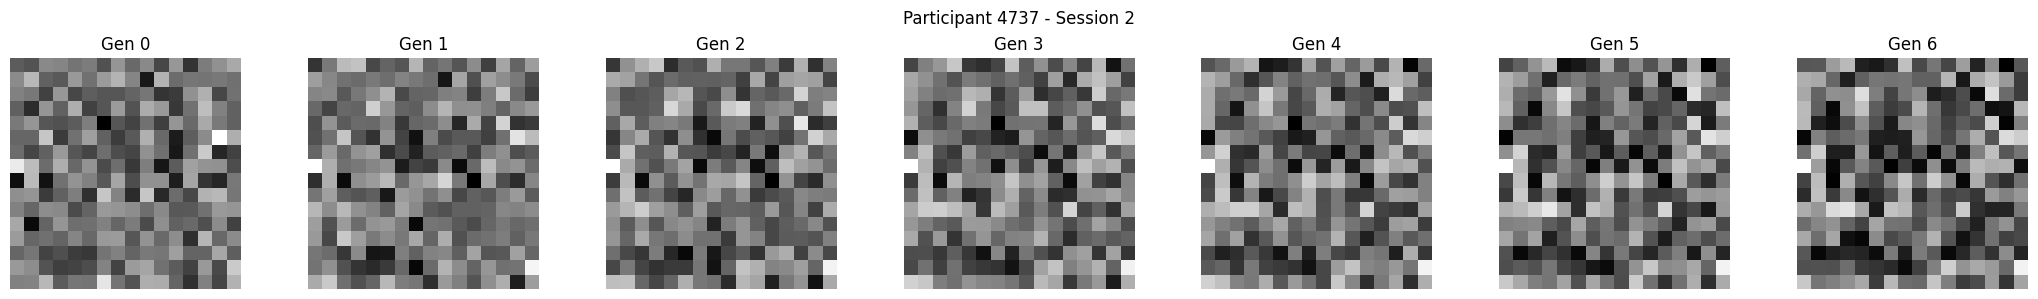

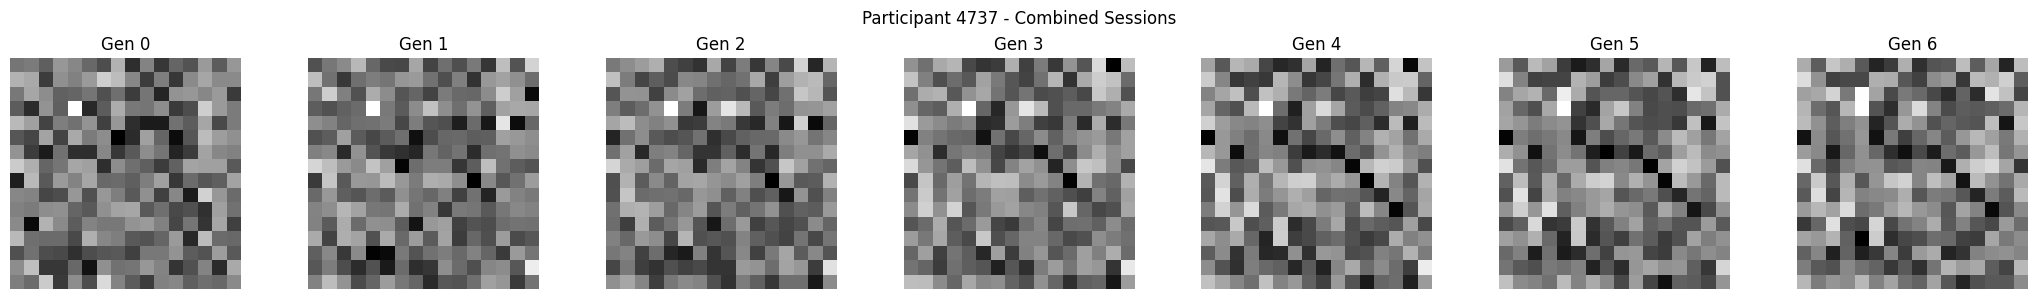


Participant 12346 (VVIQ Score: 3.00)


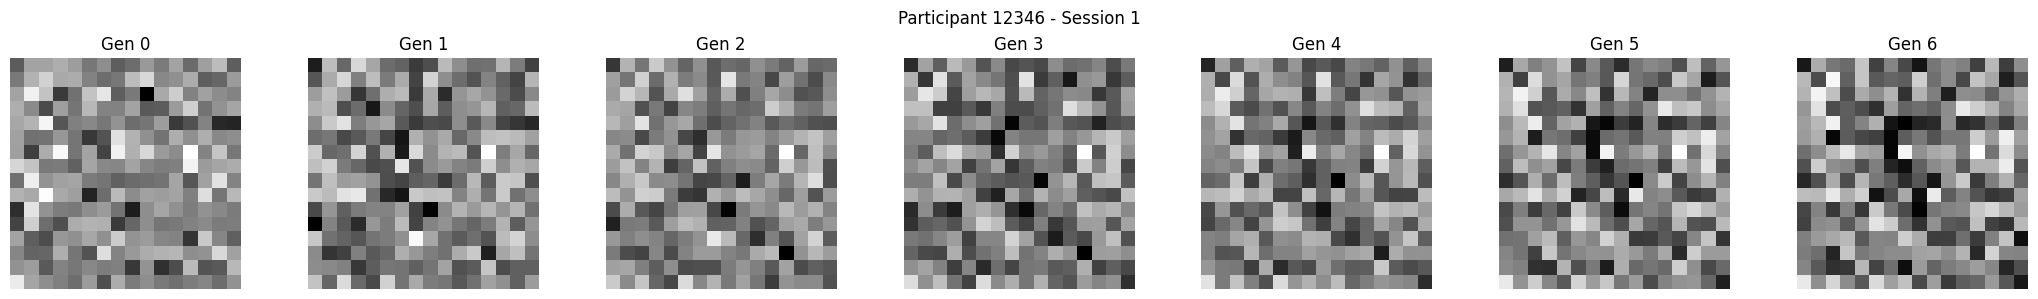

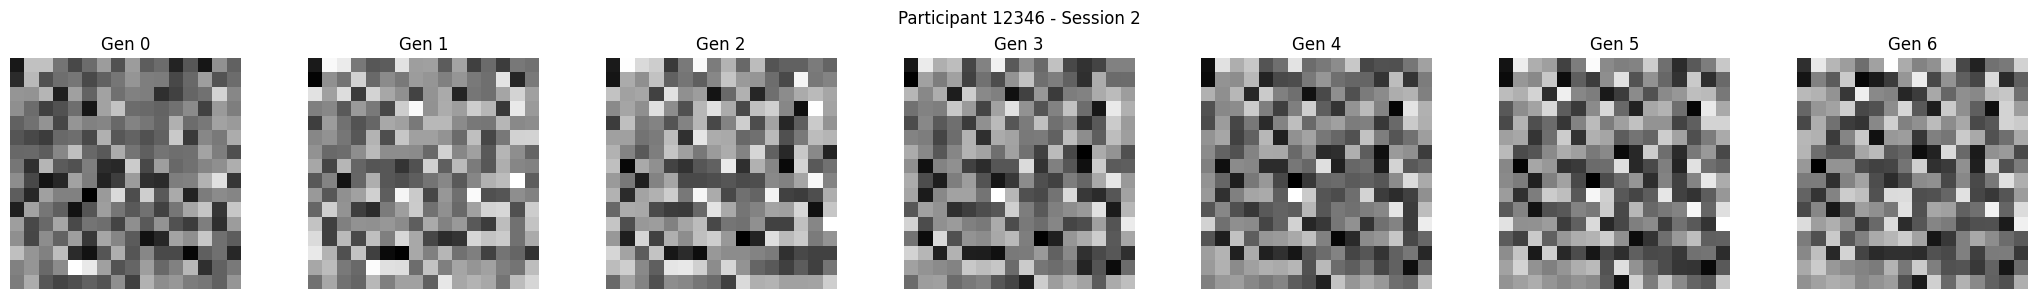

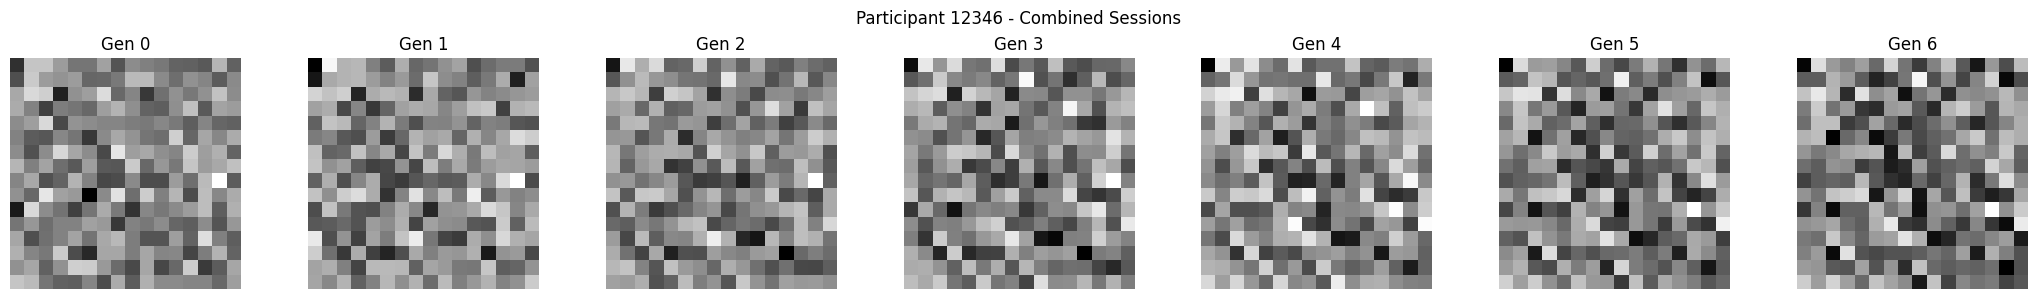


Participant 11929 (VVIQ Score: 3.35)


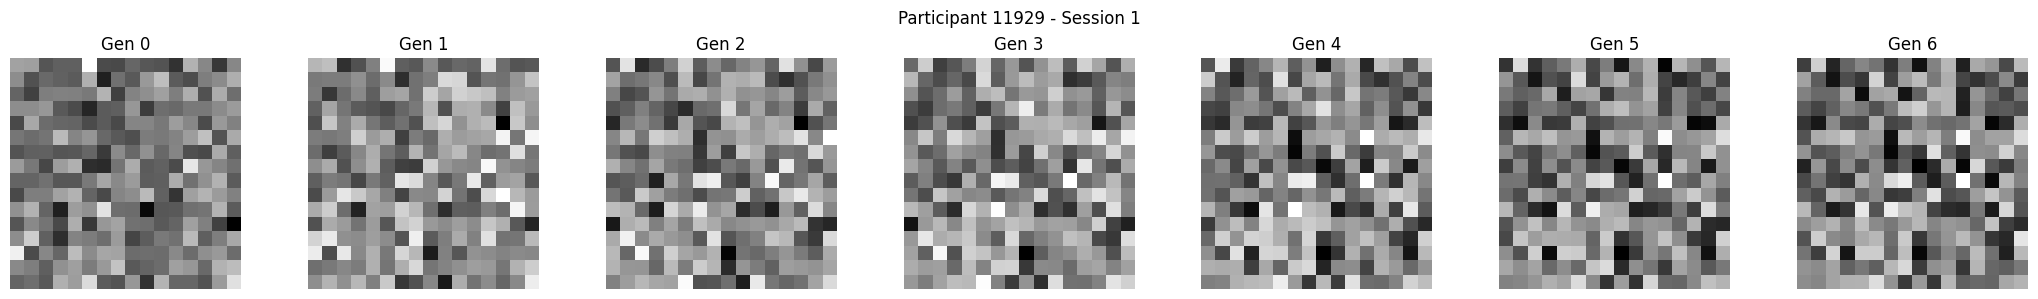

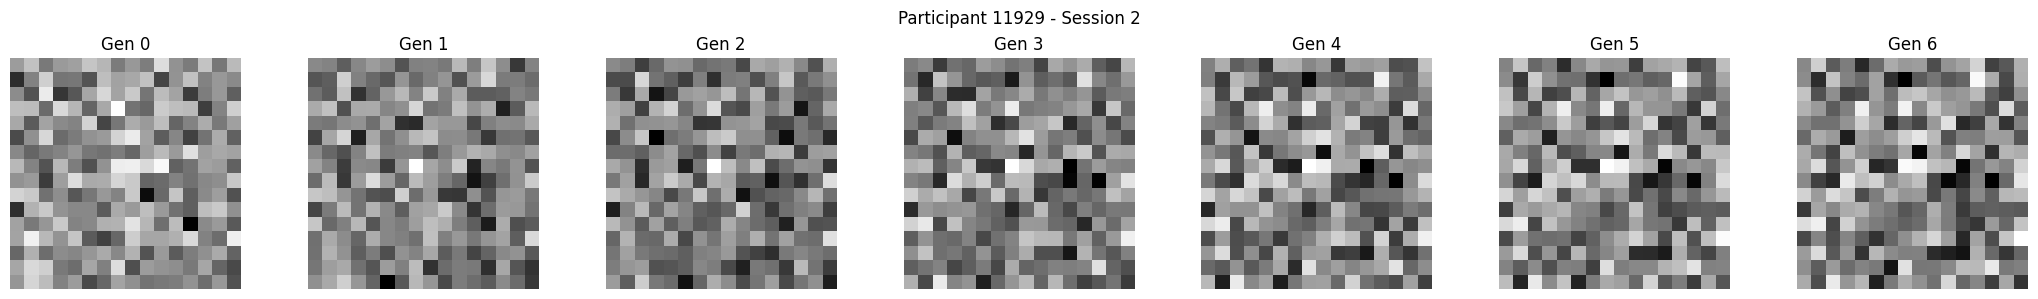

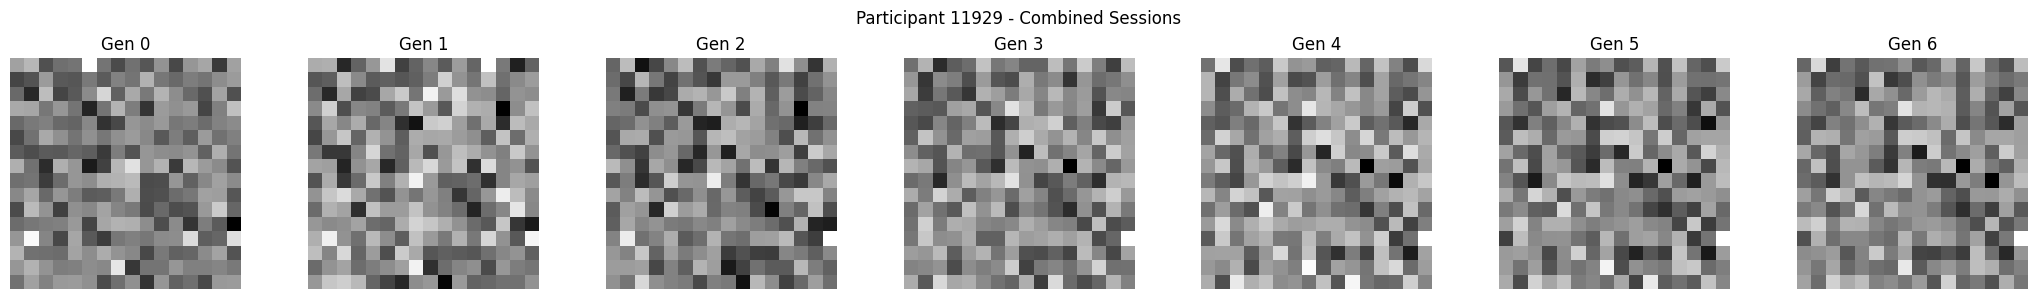

In [19]:
def visualize_classification_by_vviq(valid_results, clean_dfs, vviq_summary):
    # Define VVIQ groups
    def get_vviq_group(score):
        if score < 2.0:
            return 'high_vivid'  # Lower scores = more vivid
        elif score < 3.0:
            return 'medium_vivid'
        else:
            return 'low_vivid'  # Higher scores = less vivid
    
    # Add VVIQ group to summary
    vviq_groups = {
        pid: get_vviq_group(score) 
        for pid, score in vviq_summary['total_mean'].items()
    }
    
    # Process evolution data by VVIQ group
    grouped_results = {
        'high_vivid': {},
        'medium_vivid': {},
        'low_vivid': {}
    }
    
    # Organize data by VVIQ groups
    clean_participant_data = process_evolution_data(valid_results, clean_dfs)
    for participant_id, data in clean_participant_data.items():
        if participant_id in vviq_groups:
            group = vviq_groups[participant_id]
            grouped_results[group][participant_id] = data
    
    # Visualize each group
    for group, participants in grouped_results.items():
        if participants:
            print(f"\nClassification Images for Group: {group}")
            print(f"Number of participants: {len(participants)}")
            
            for participant_id, data in participants.items():
                print(f"\nParticipant {participant_id} (VVIQ Score: {vviq_summary.loc[participant_id, 'total_mean']:.2f})")
                plot_participant_sessions_with_combined(data, participant_id)

# Run the visualization
visualize_classification_by_vviq(valid_results, clean_dfs, vviq_summary)

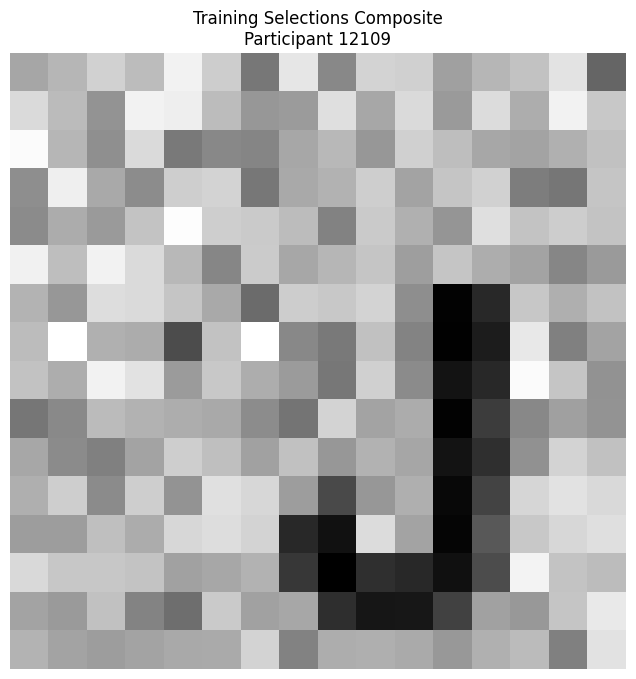

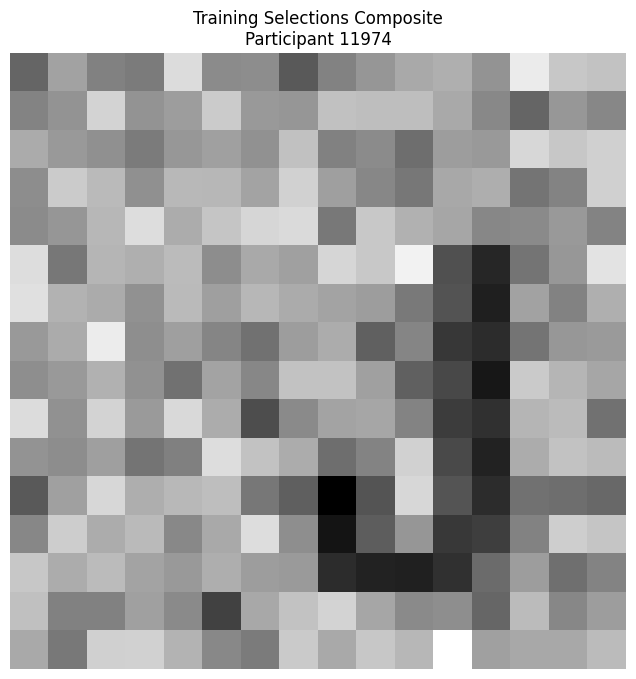

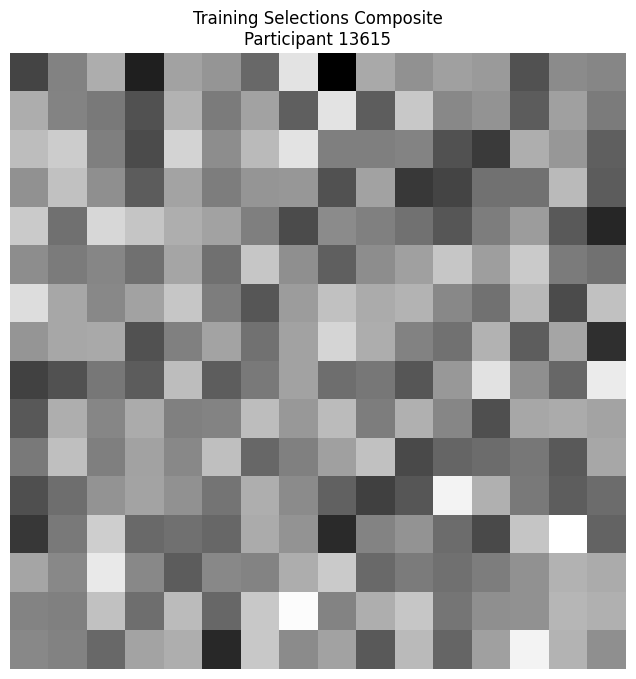

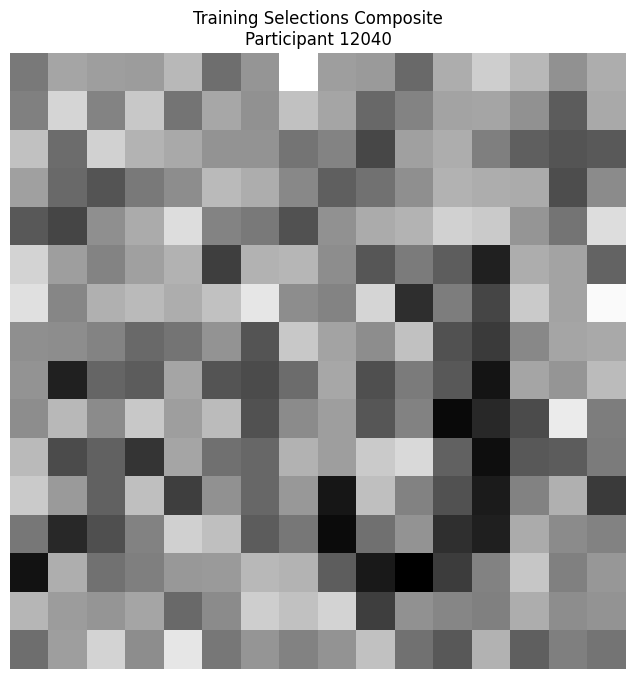

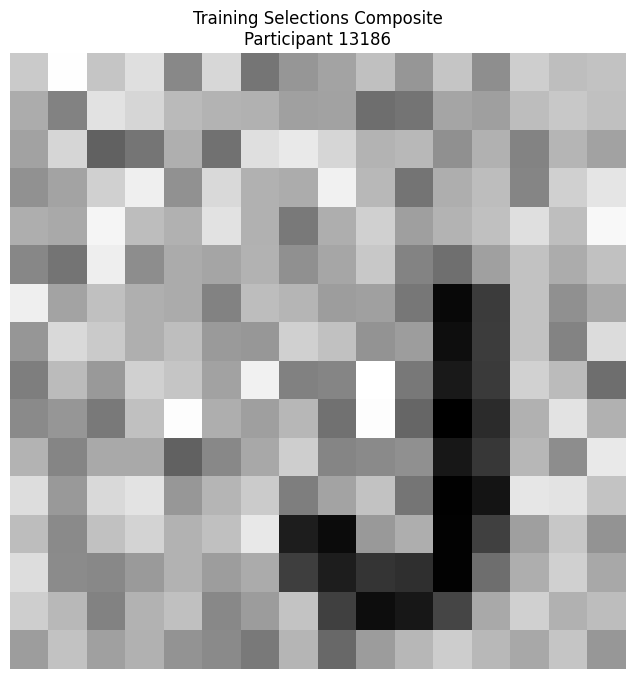

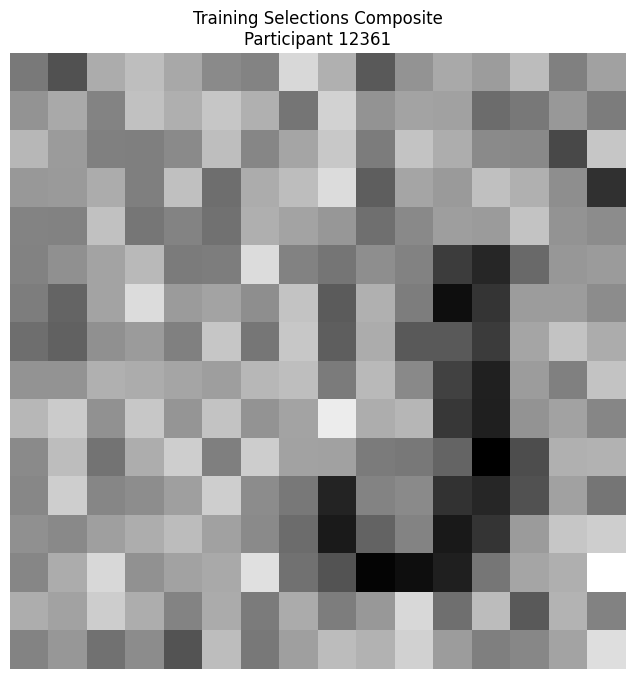

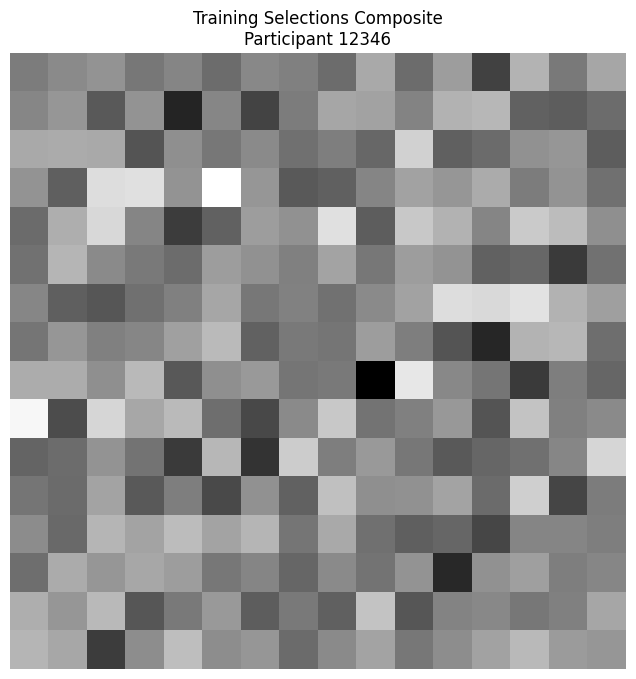

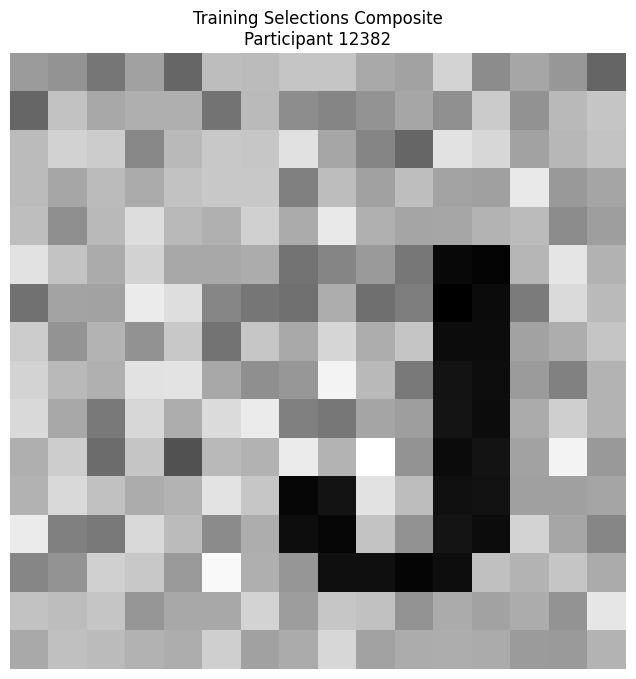

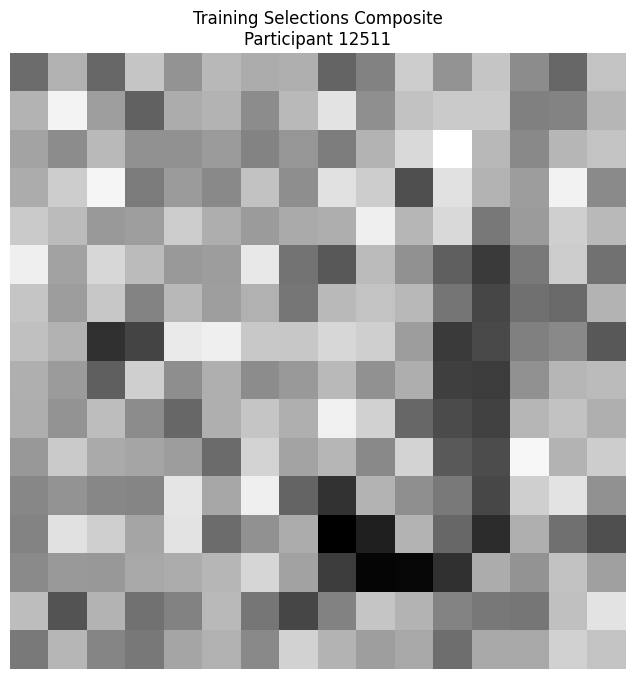

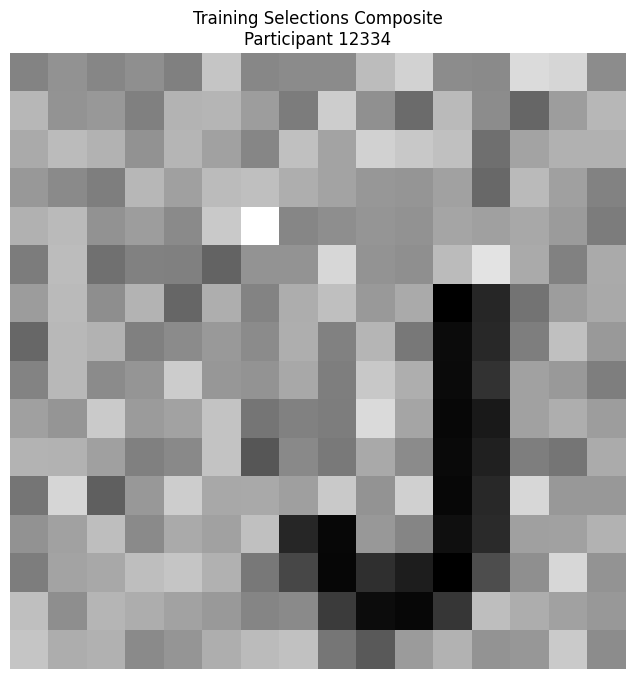

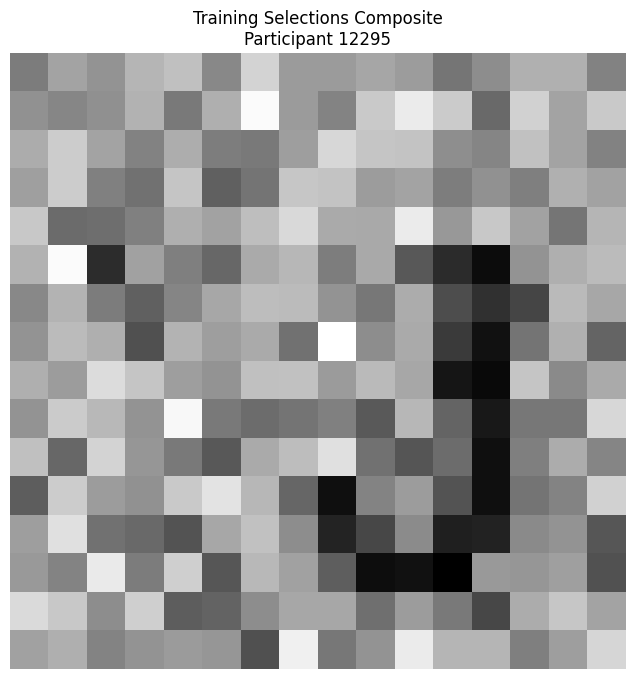

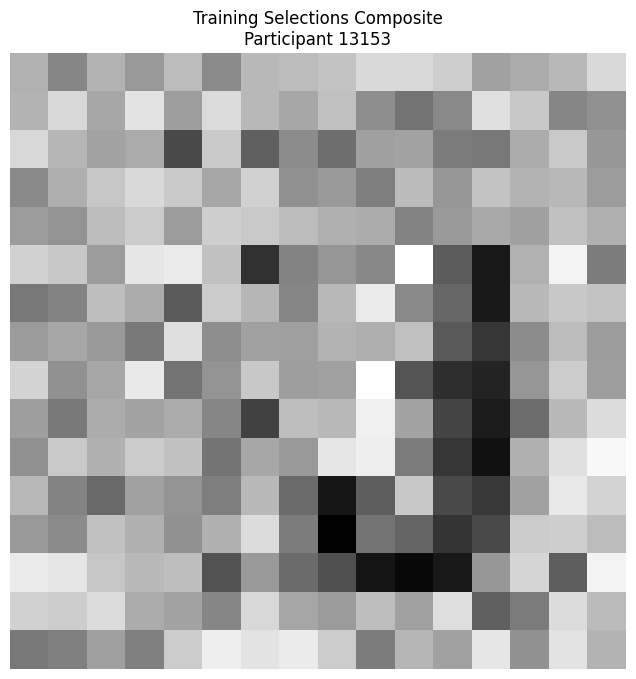

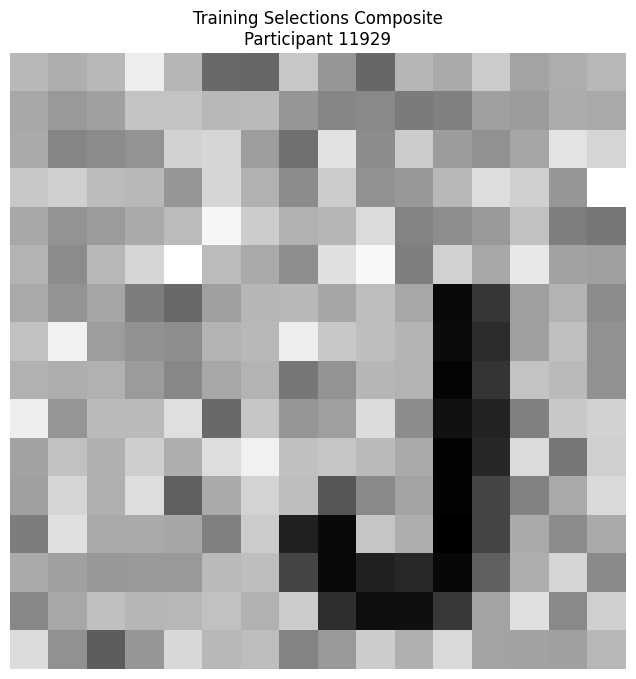

In [20]:
def visualize_training_selections(valid_results, clean_dfs):
    """Visualize training phase selections for each participant"""
    def extract_training_data(result):
        if 'training_phase' in result and 'trials' in result['training_phase']:
            return {
                'participant_id': result['metadata']['participant_id'],
                'trials': result['training_phase']['trials'],
                'selected_images': [trial['selected_image'] for trial in result['training_phase']['trials'] 
                                  if 'selected_image' in trial]
            }
        return None

    # Process training data
    training_selections = {}
    for result in valid_results:
        training_data = extract_training_data(result)
        if training_data and training_data['participant_id'] in clean_dfs['participants'].index:
            training_selections[training_data['participant_id']] = training_data['selected_images']

    # Visualize selections for each participant
    for participant_id, selections in training_selections.items():
        if selections:
            # Create composite of all selections
            selected_images = []
            for img_base64 in selections:
                try:
                    img = decode_base64_image(img_base64)
                    selected_images.append(img)
                except:
                    continue

            if selected_images:
                plt.figure(figsize=(8, 8))
                composite = create_composite_image(selected_images)
                plt.imshow(composite, cmap='gray')
                plt.axis('off')
                plt.title(f'Training Selections Composite\nParticipant {participant_id}')
                plt.show()
                plt.close()

# Run the visualization
visualize_training_selections(valid_results, clean_dfs)

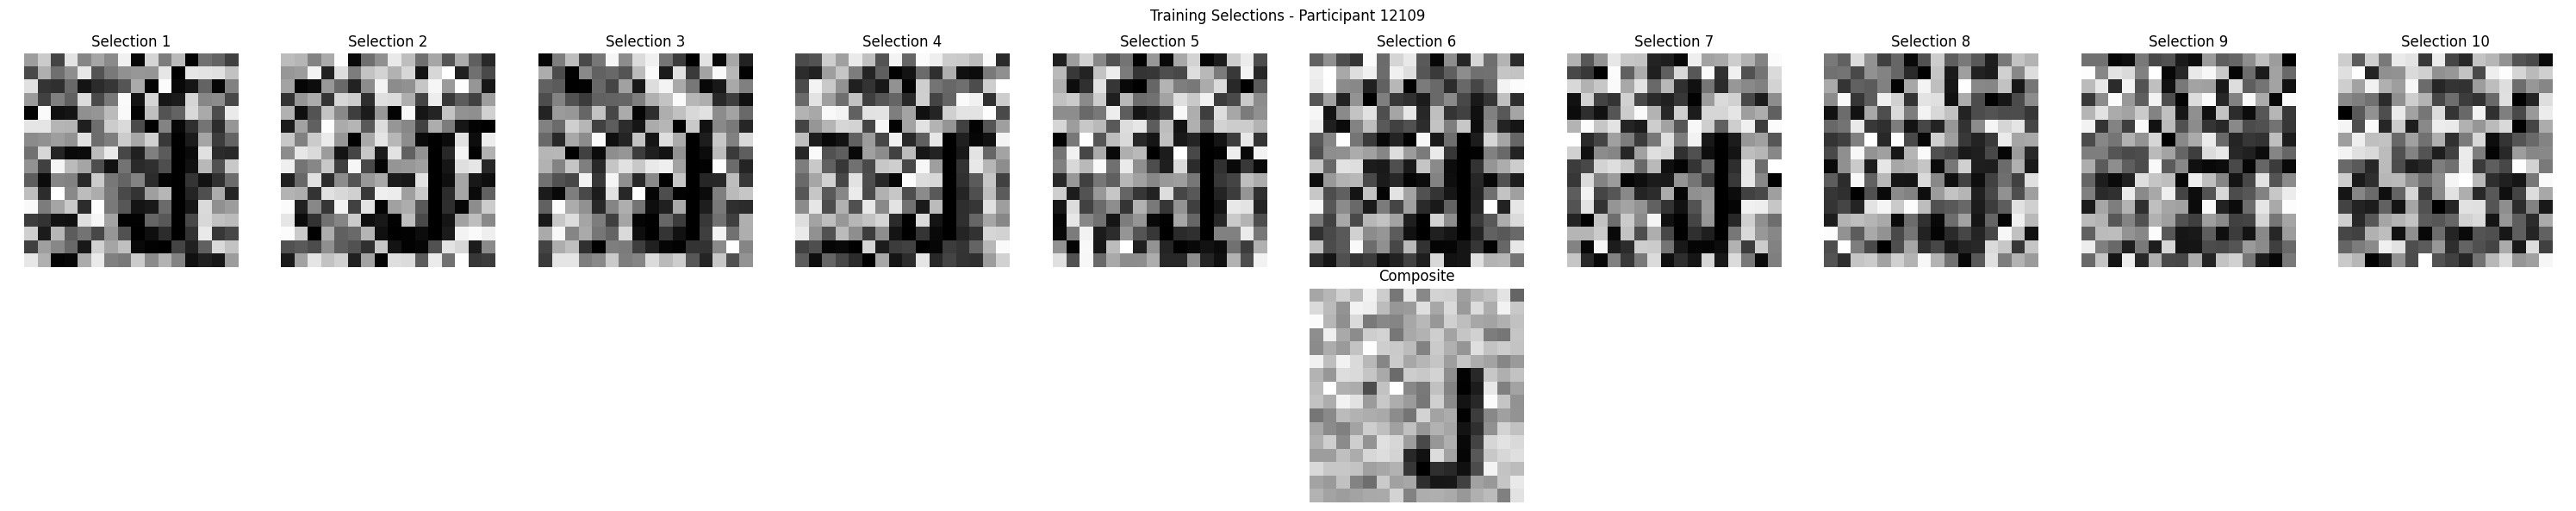

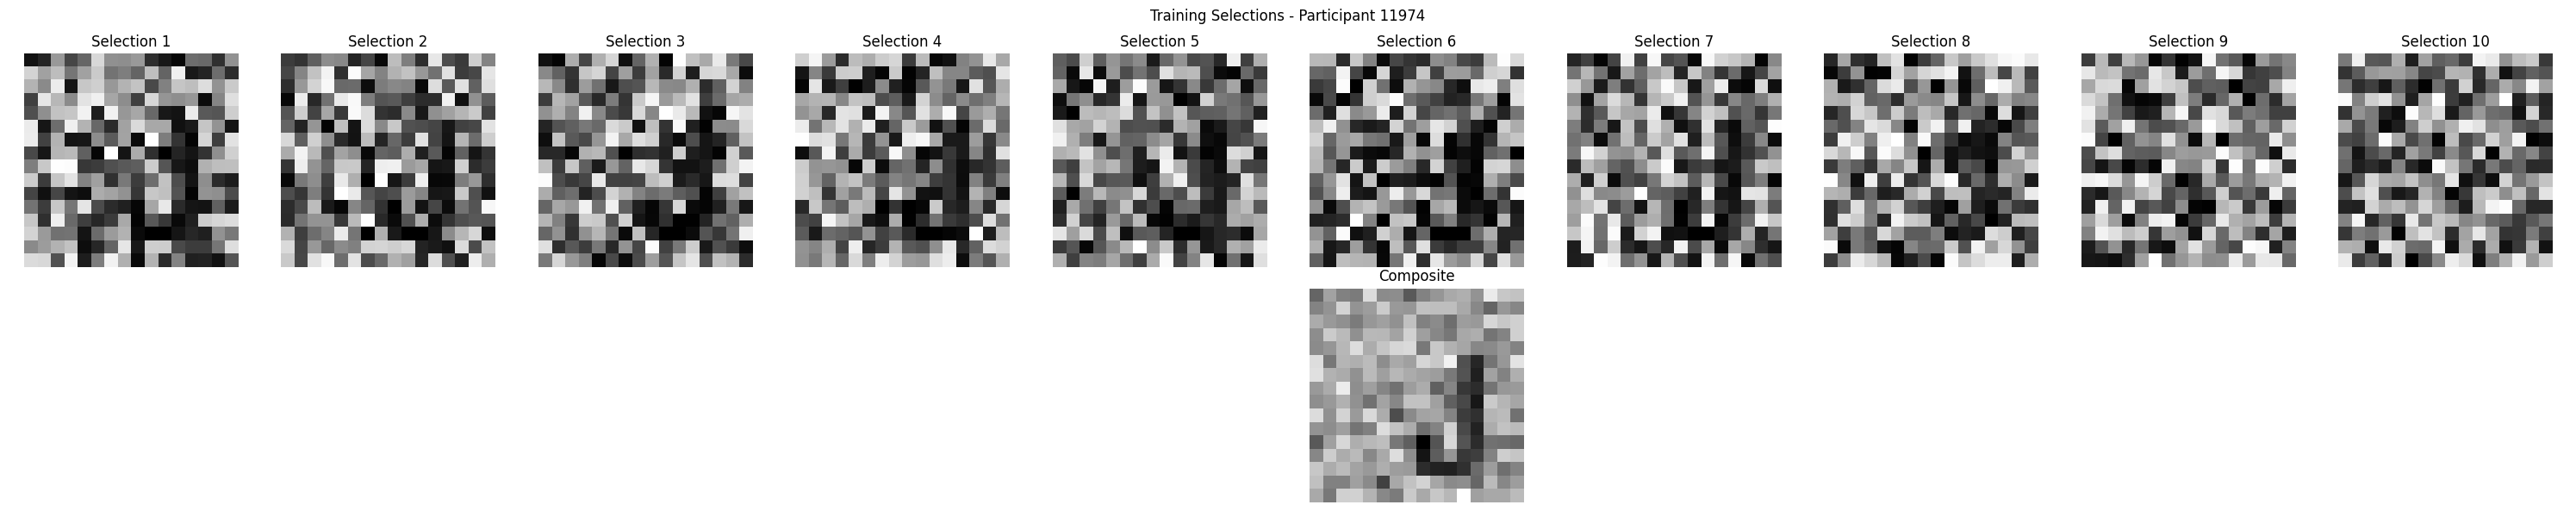

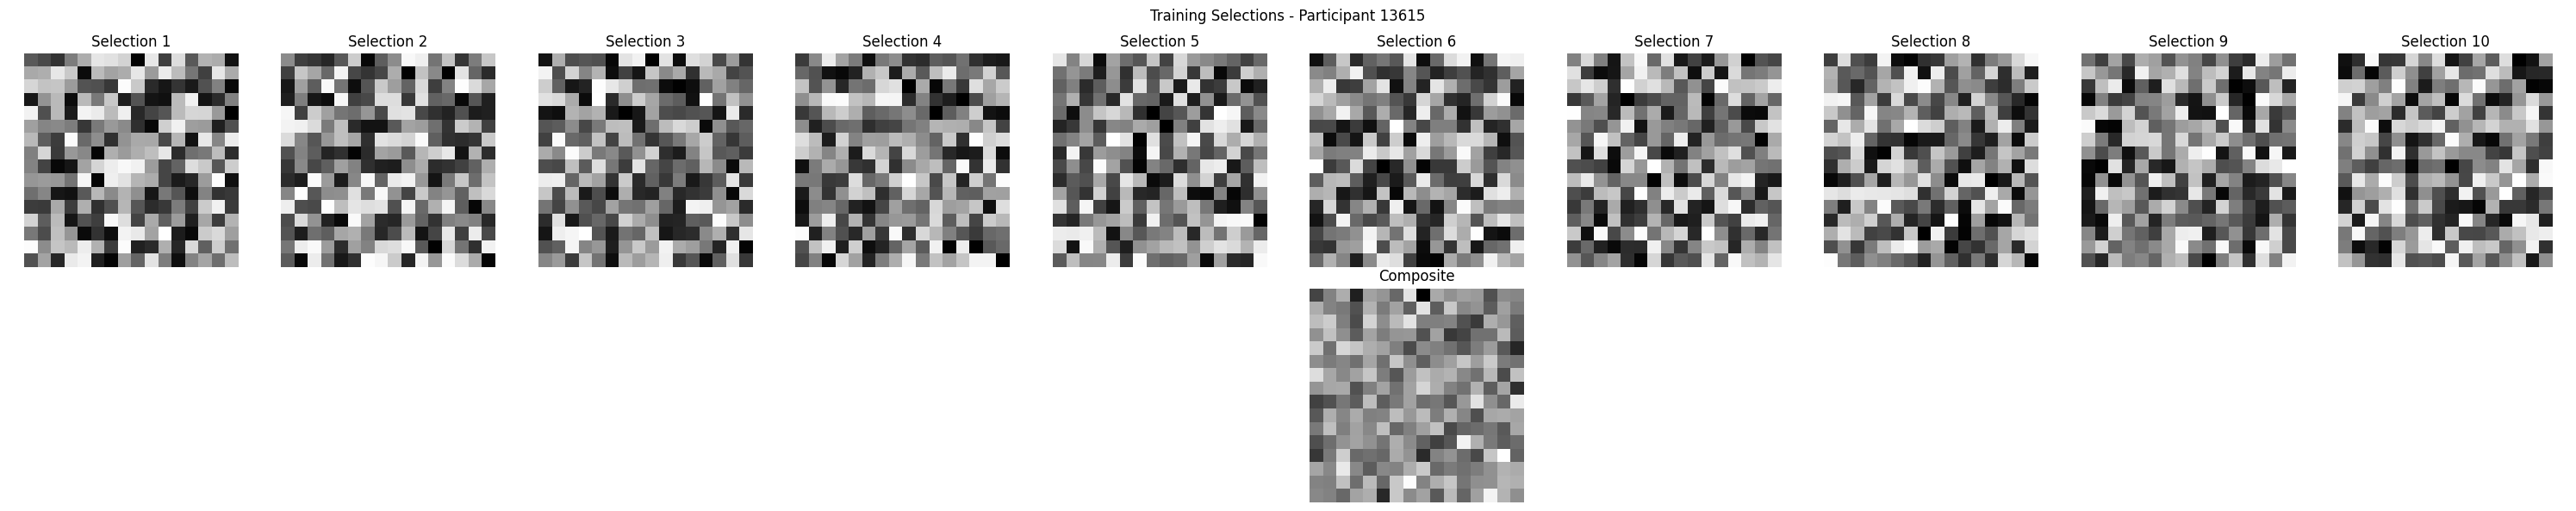

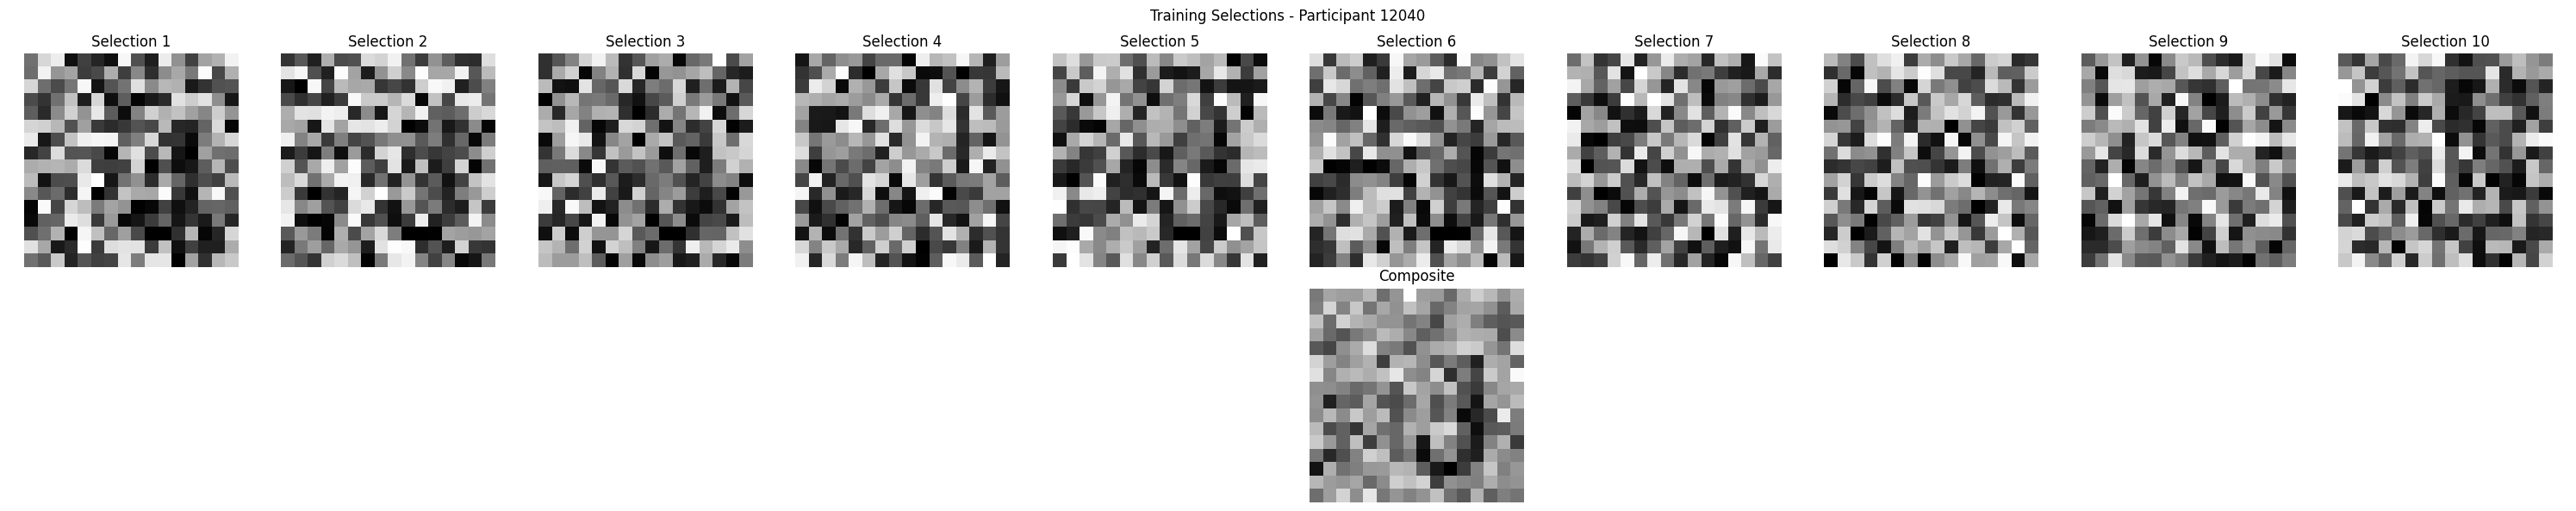

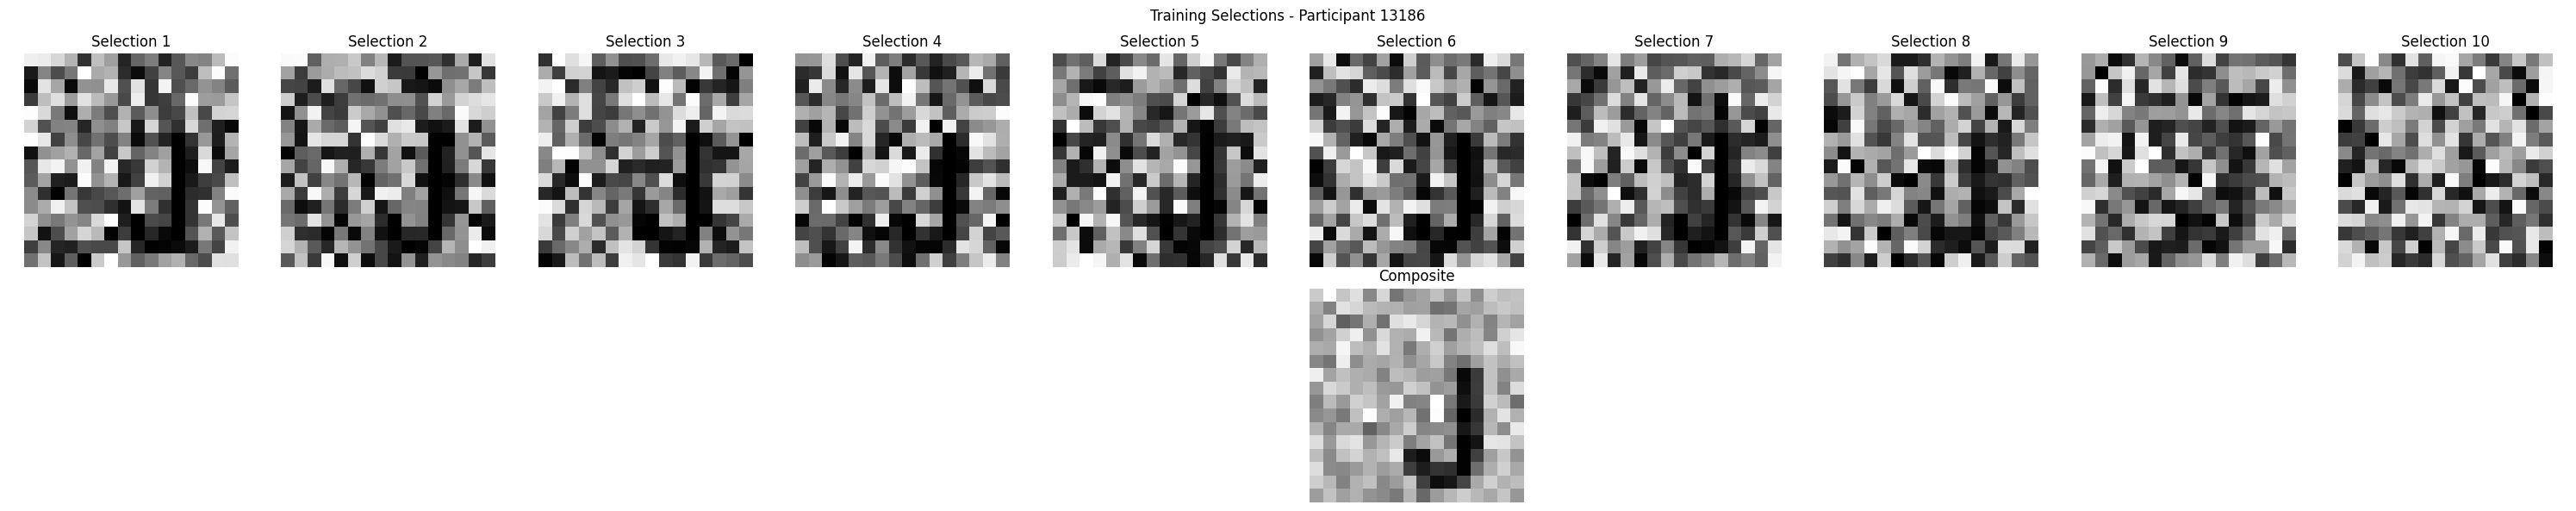

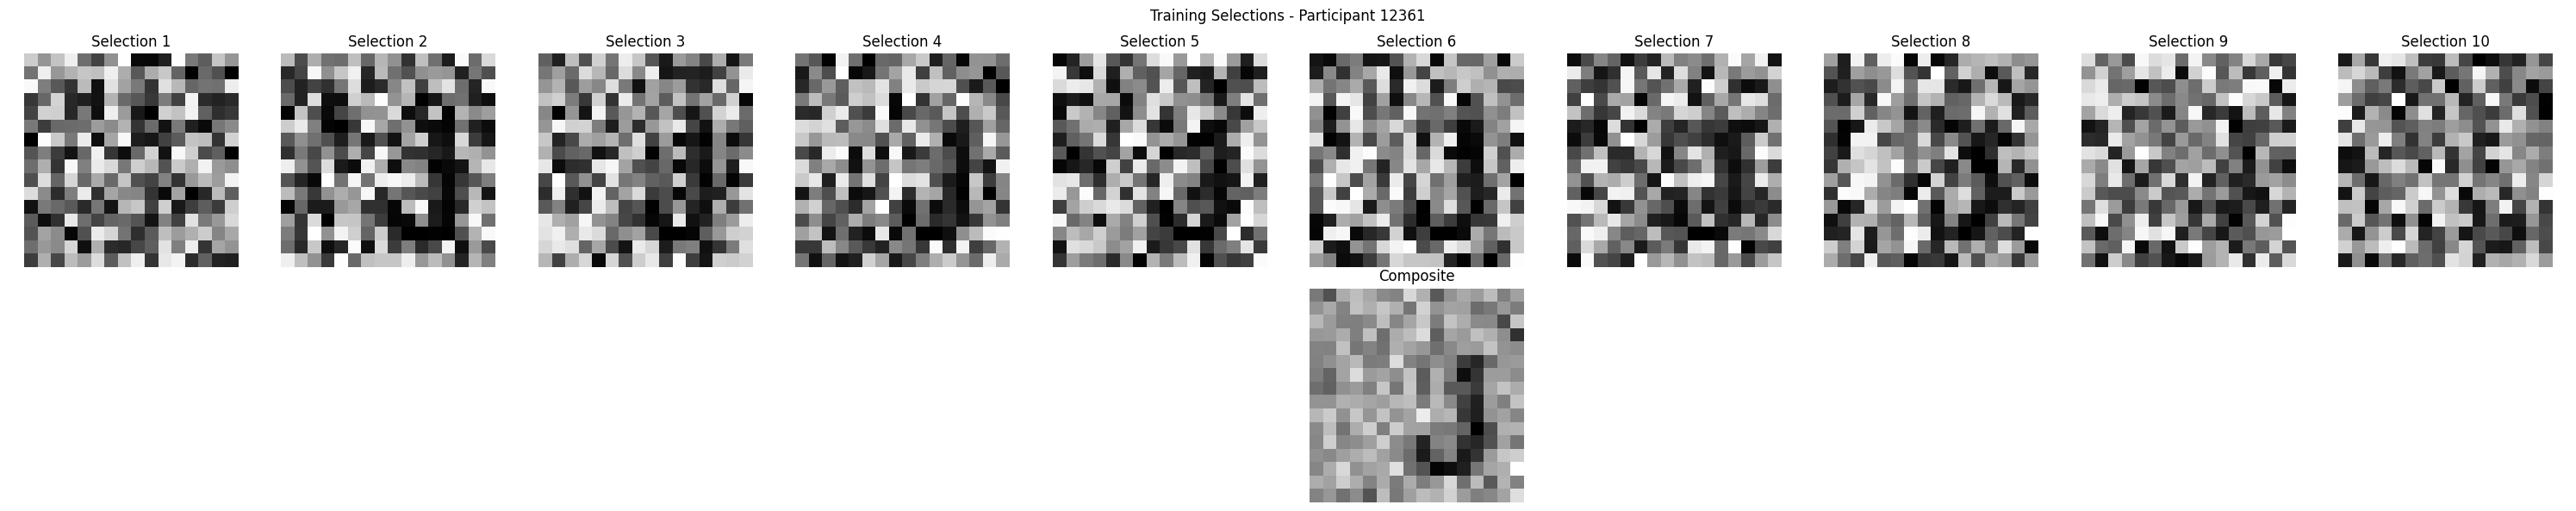

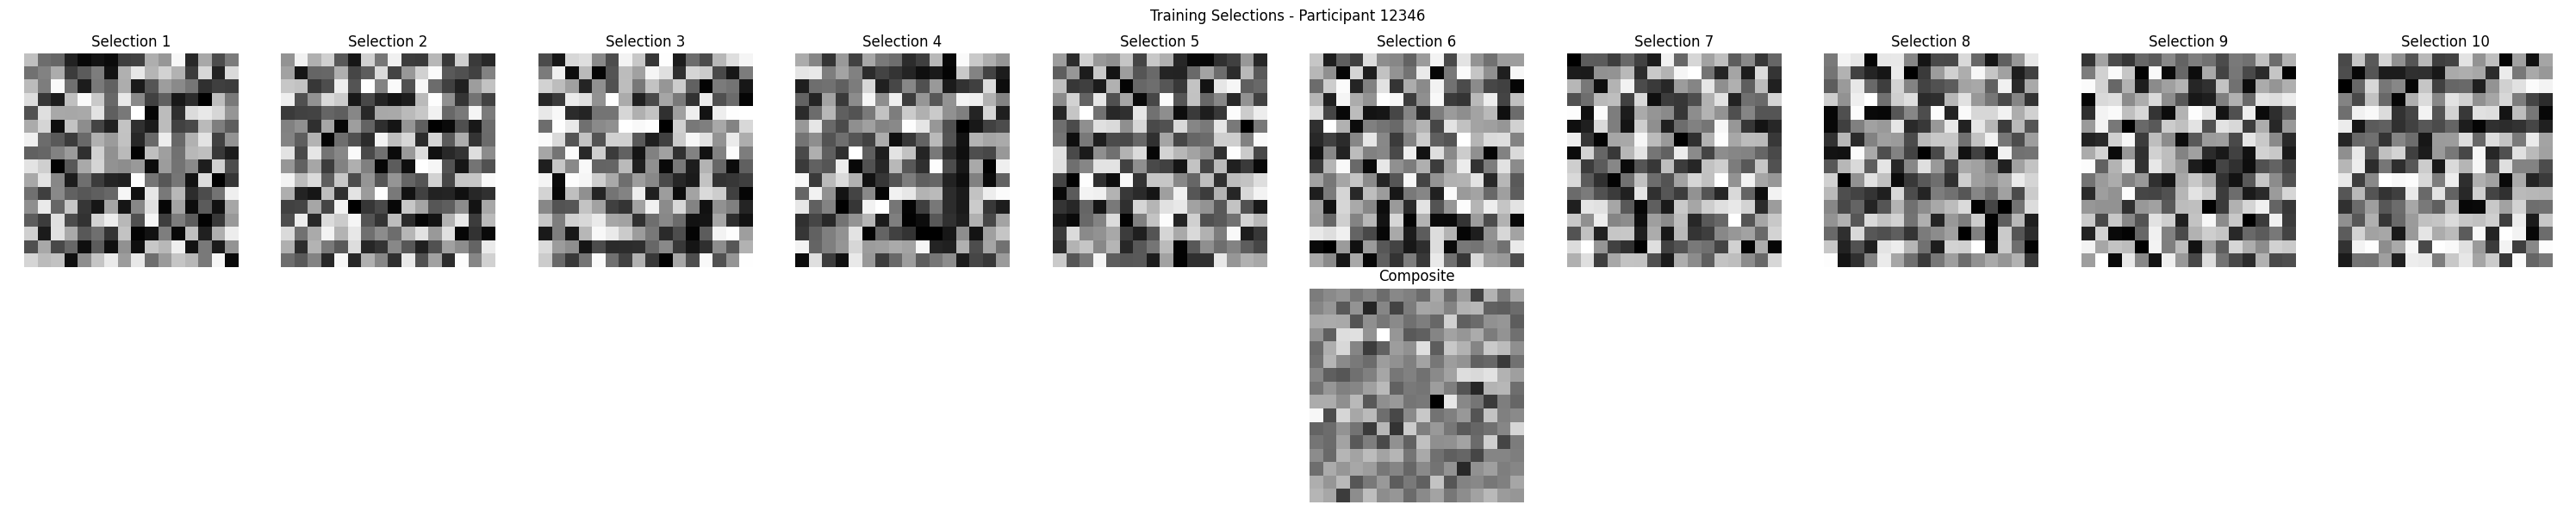

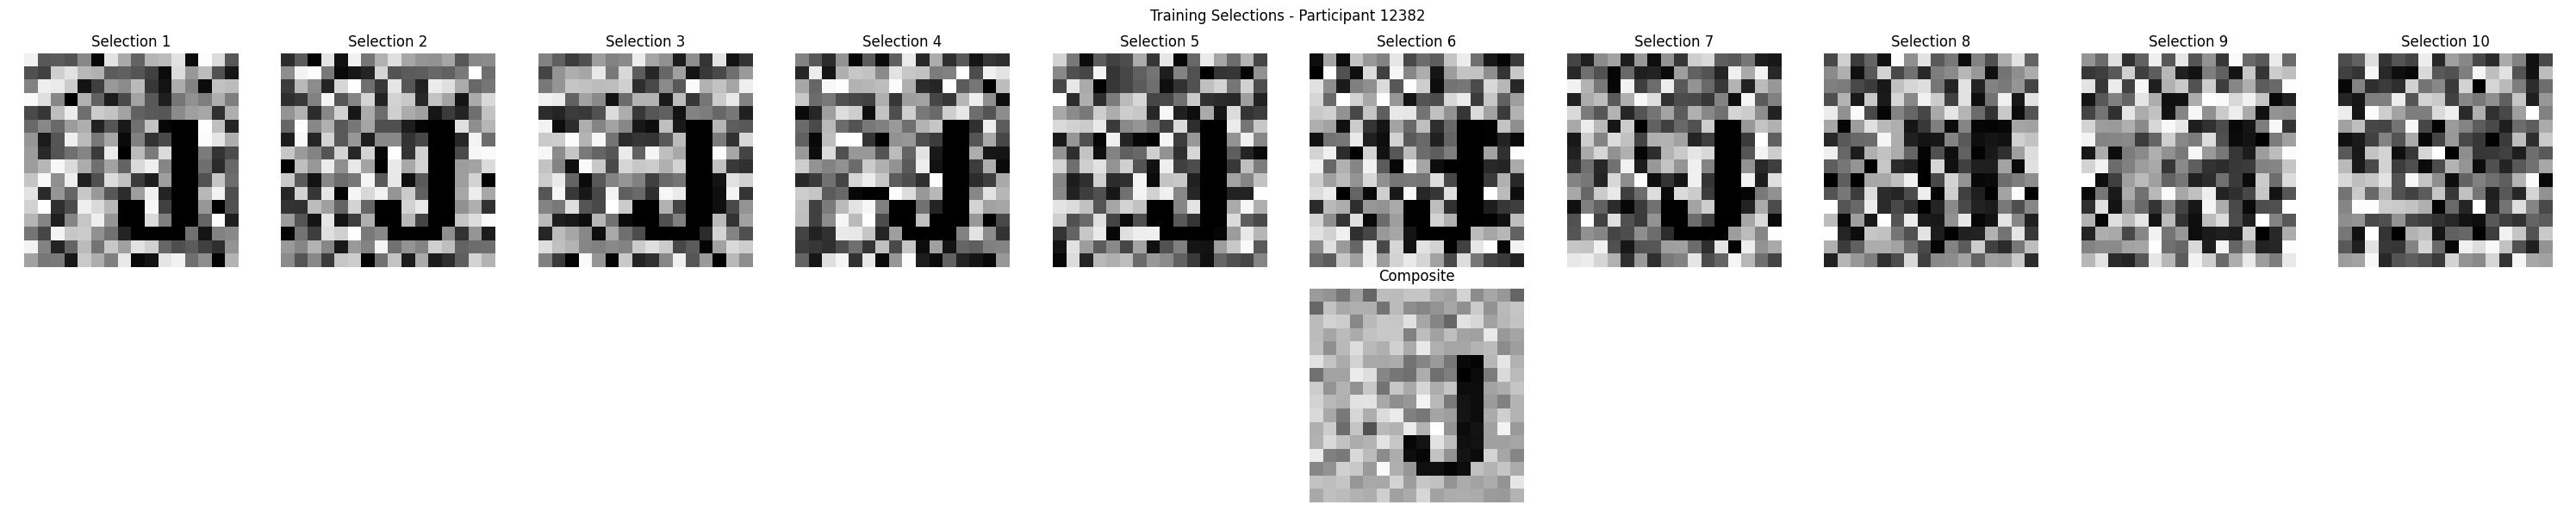

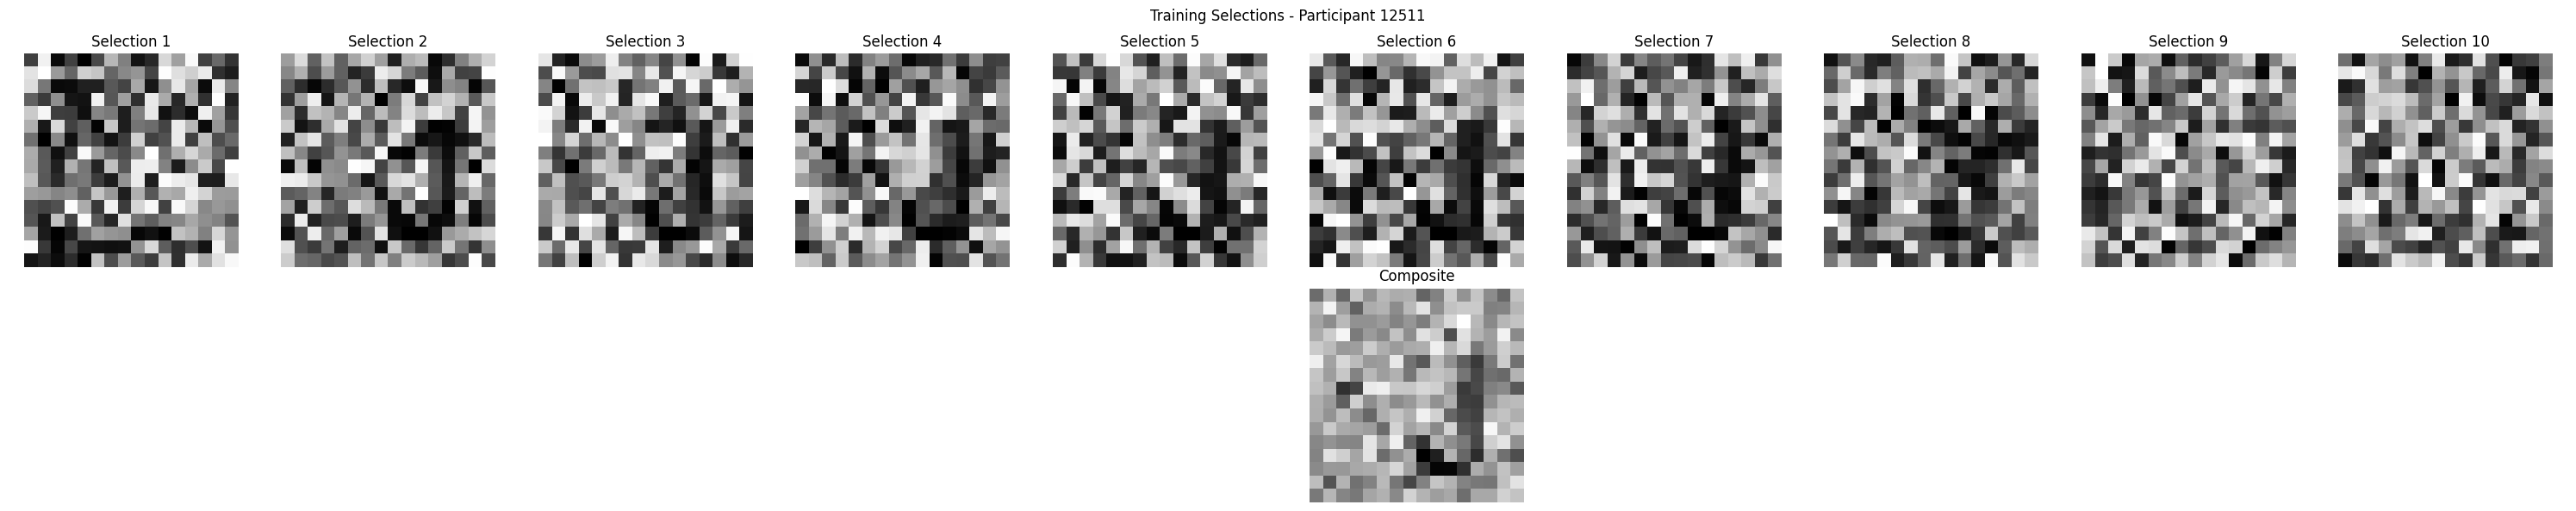

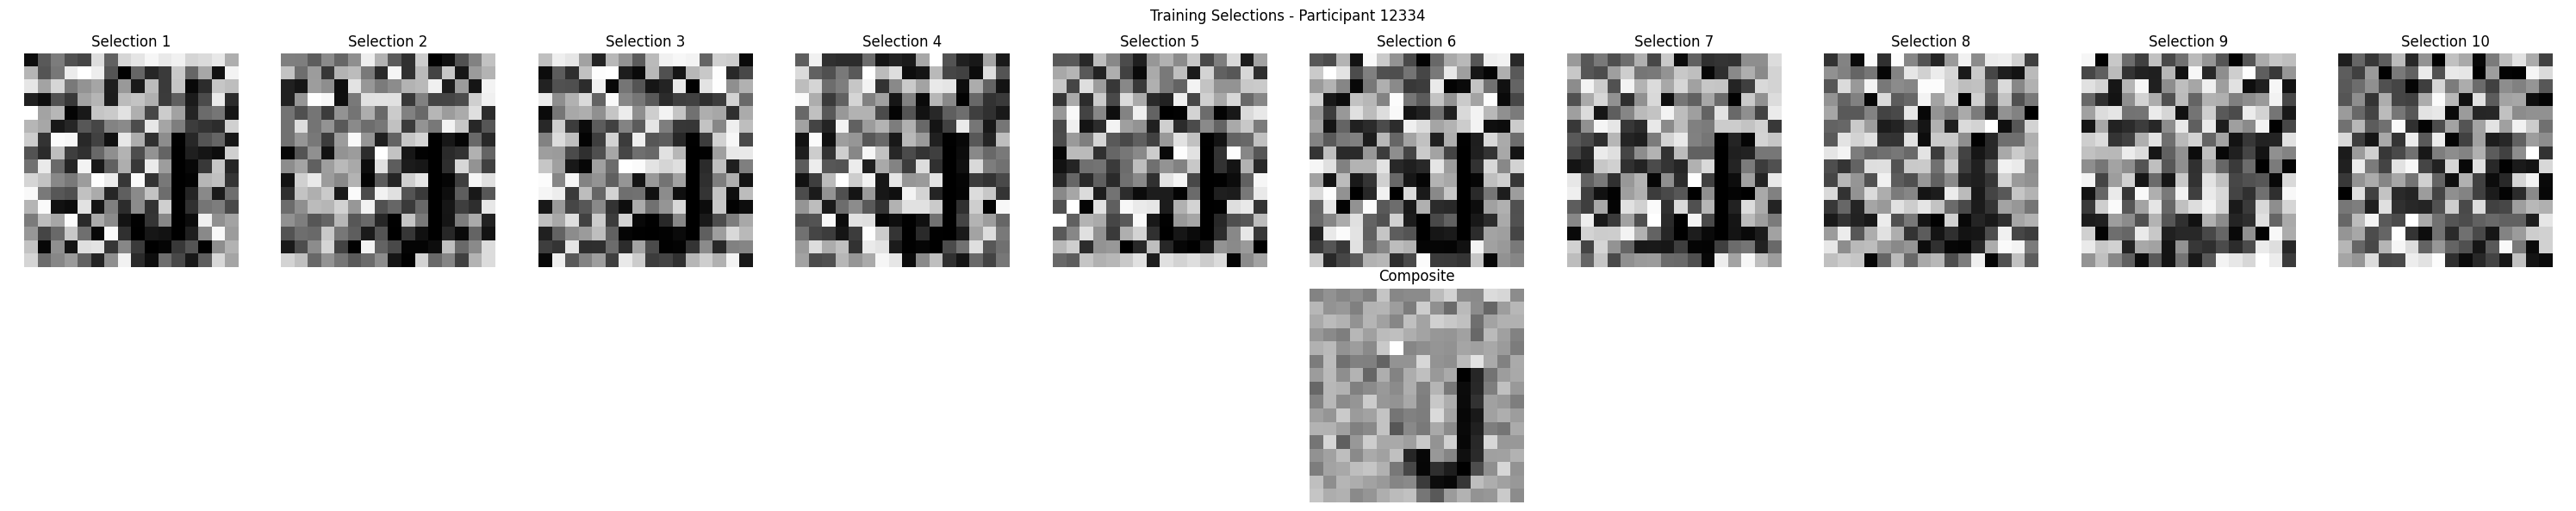

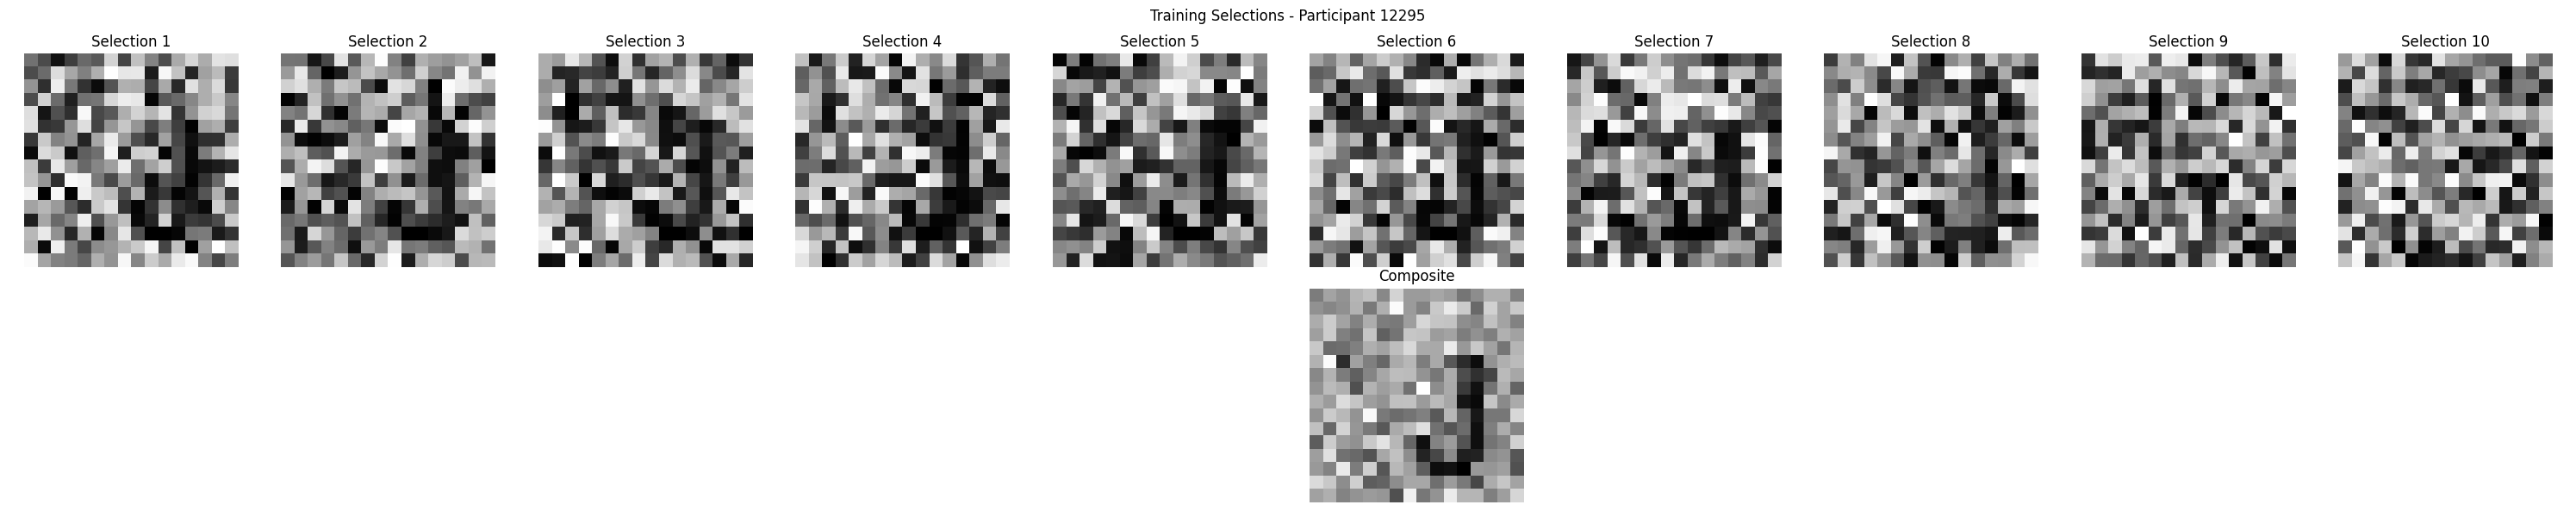

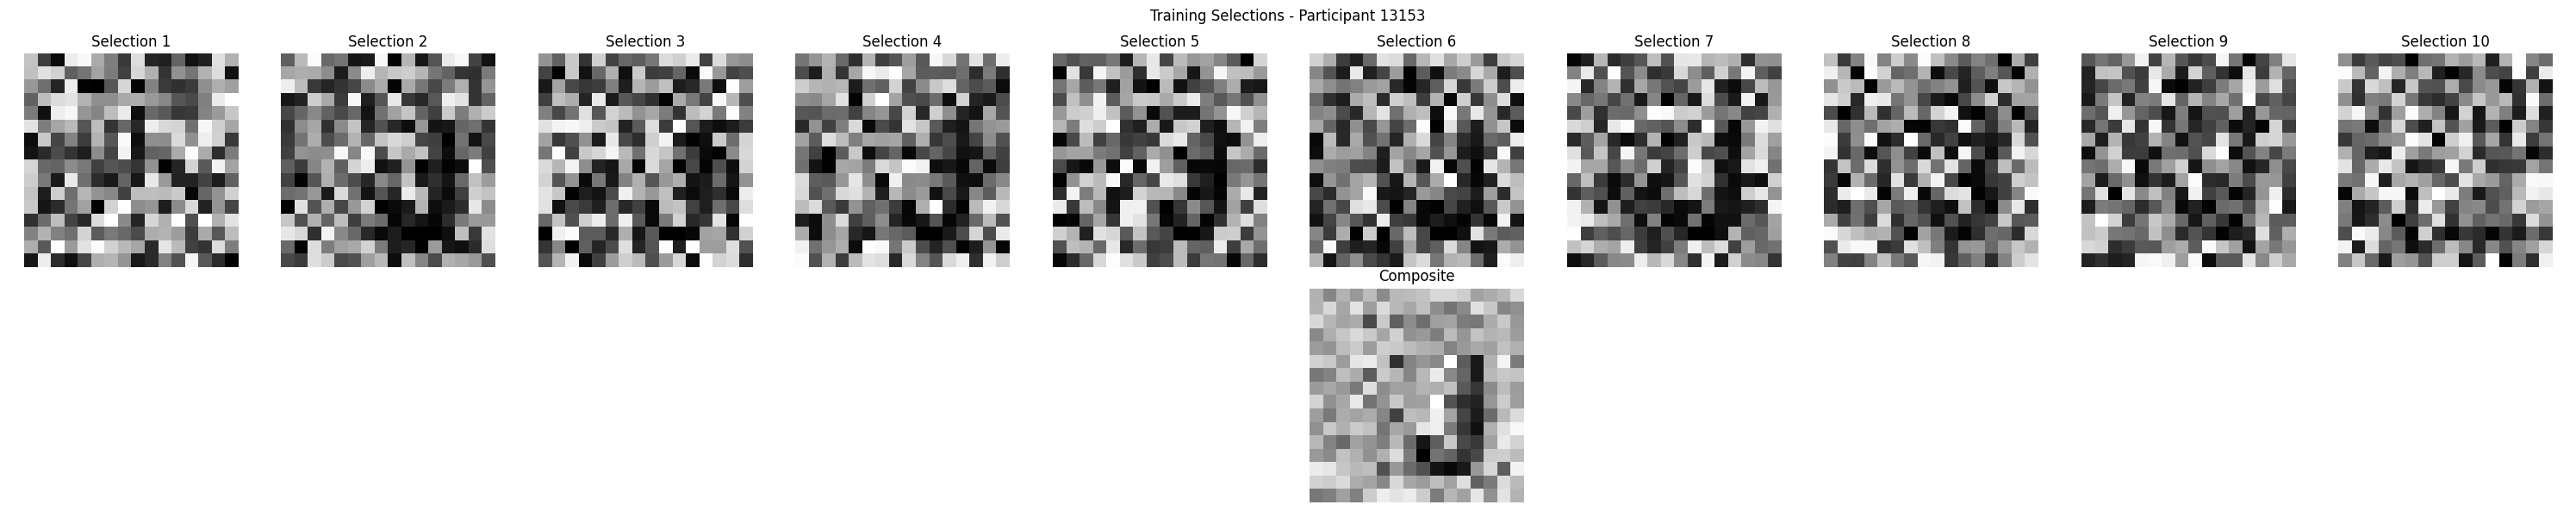

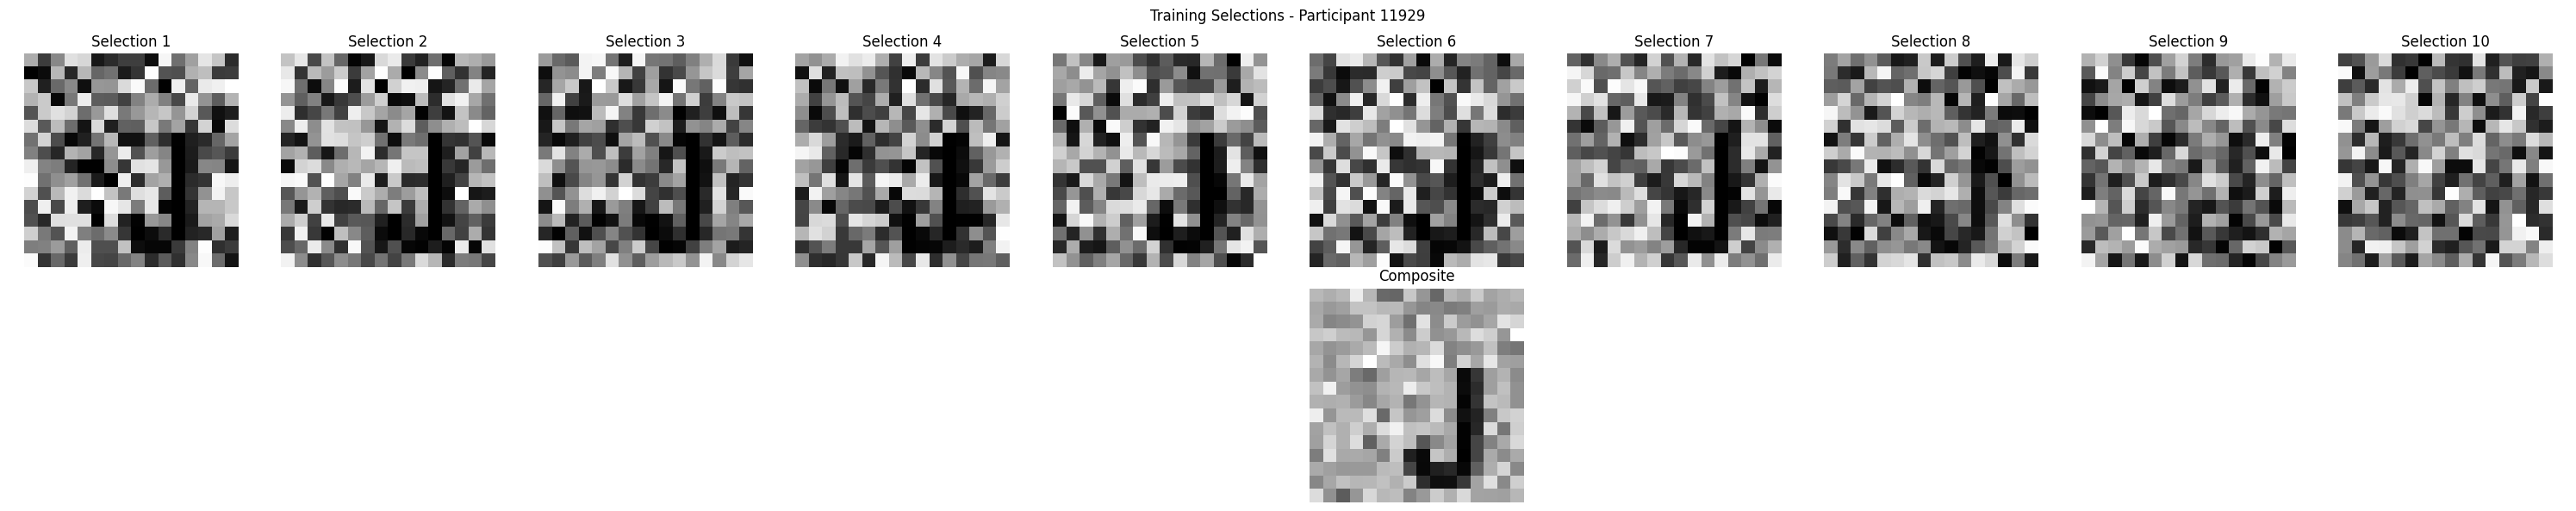

In [21]:
def visualize_training_selections_detailed(valid_results, clean_dfs):
    """Visualize both individual and composite training selections"""
    def extract_training_data(result):
        if 'training_phase' in result and 'trials' in result['training_phase']:
            return {
                'participant_id': result['metadata']['participant_id'],
                'trials': result['training_phase']['trials'],
                'selected_images': [trial['selected_image'] for trial in result['training_phase']['trials'] 
                                  if 'selected_image' in trial]
            }
        return None

    # Process training data
    training_selections = {}
    for result in valid_results:
        training_data = extract_training_data(result)
        if training_data and training_data['participant_id'] in clean_dfs['participants'].index:
            training_selections[training_data['participant_id']] = training_data['selected_images']

    # Visualize selections for each participant
    for participant_id, selections in training_selections.items():
        if selections:
            # Create figure for all selections and composite
            n_selections = len(selections)
            fig, axes = plt.subplots(2, max(n_selections, 1), 
                                   figsize=(3*max(n_selections, 1), 6))
            
            # Plot individual selections
            for idx, img_base64 in enumerate(selections):
                try:
                    img = decode_base64_image(img_base64)
                    axes[0, idx].imshow(img.convert('L'), cmap='gray')
                    axes[0, idx].axis('off')
                    axes[0, idx].set_title(f'Selection {idx+1}')
                except:
                    continue
            
            # Create and plot composite
            selected_images = []
            for img_base64 in selections:
                try:
                    img = decode_base64_image(img_base64)
                    selected_images.append(img)
                except:
                    continue

            if selected_images:
                composite = create_composite_image(selected_images)
                for ax in axes[1]:
                    ax.axis('off')
                axes[1, n_selections//2].imshow(composite, cmap='gray')
                axes[1, n_selections//2].set_title('Composite')

            plt.suptitle(f'Training Selections - Participant {participant_id}')
            plt.tight_layout()
            plt.show()
            plt.close()

# Run the visualization
visualize_training_selections_detailed(valid_results, clean_dfs)

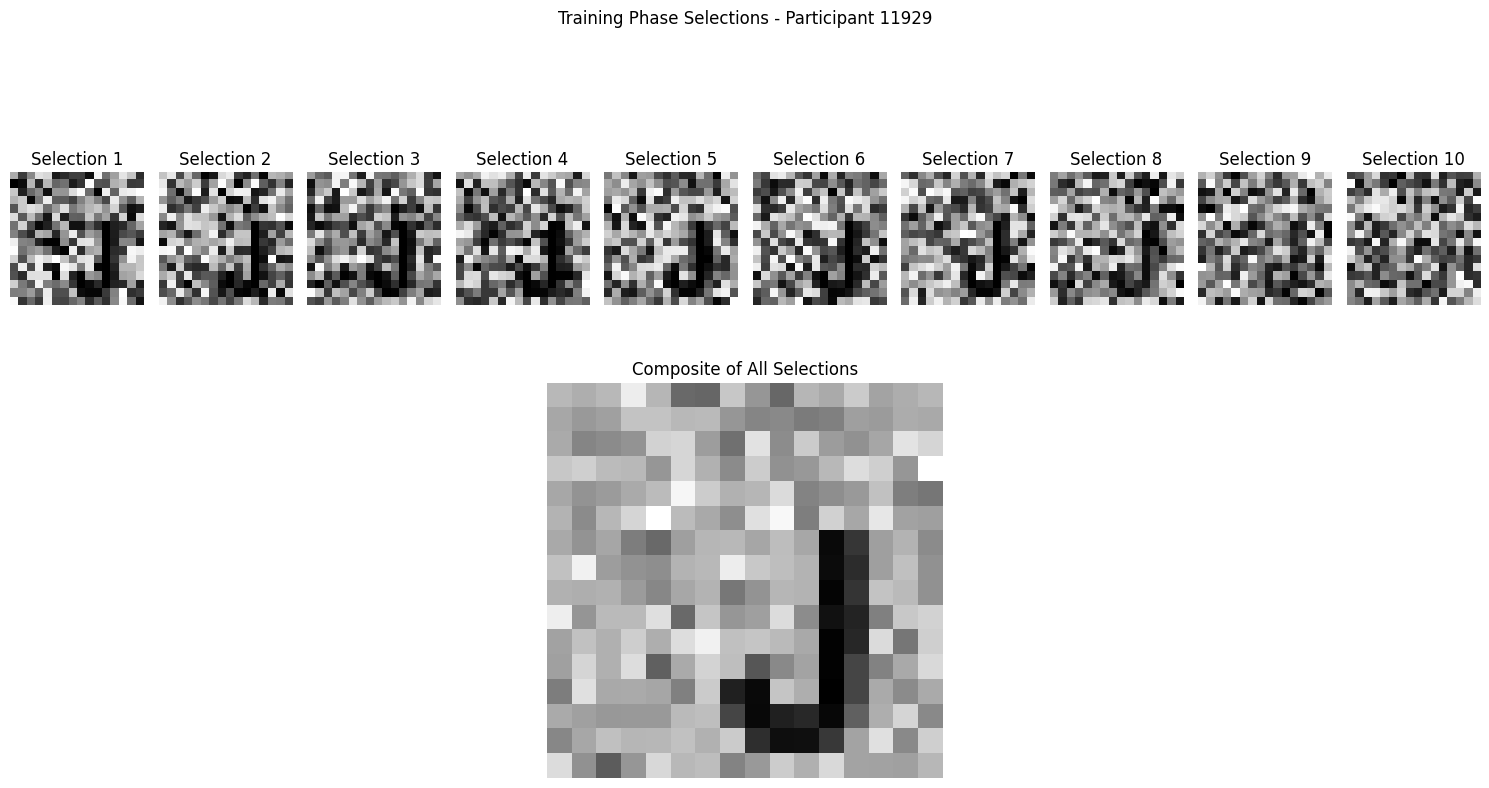

In [ ]:
def visualize_training_selections_simple(valid_results, participant_id):
    # Extract training data for the participant
    def extract_training_data(result):
        if ('training_phase' in result and 
            'trials' in result['training_phase'] and 
            result['metadata']['participant_id'] == participant_id):
            return [trial['selected_image'] for trial in result['training_phase']['trials'] 
                   if 'selected_image' in trial]
        return []

    # Get selections
    selections = []
    for result in valid_results:
        selections.extend(extract_training_data(result))
    
    if selections:
        # Create a single figure
        n_selections = len(selections)
        fig = plt.figure(figsize=(15, 8))
        
        # Plot individual selections
        for idx, img_base64 in enumerate(selections):
            plt.subplot(2, n_selections, idx + 1)
            try:
                img = decode_base64_image(img_base64)
                plt.imshow(img.convert('L'), cmap='gray')
                plt.axis('off')
                plt.title(f'Selection {idx+1}')
            except Exception as e:
                print(f"Error processing image {idx}: {str(e)}")
                continue
        
        # Create and plot composite
        selected_images = []
        for img_base64 in selections:
            try:
                img = decode_base64_image(img_base64)
                selected_images.append(img)
            except:
                continue
                
        if selected_images:
            # Center the composite in bottom row
            composite = create_composite_image(selected_images)
            plt.subplot(2, 1, 2)
            plt.imshow(composite, cmap='gray')
            plt.axis('off')
            plt.title('Composite of All Selections')
        
        plt.suptitle(f'Training Phase Selections - Participant {participant_id}')
        plt.tight_layout()
        plt.show()

# Try the visualization
visualize_training_selections_simple(valid_results, '11929')

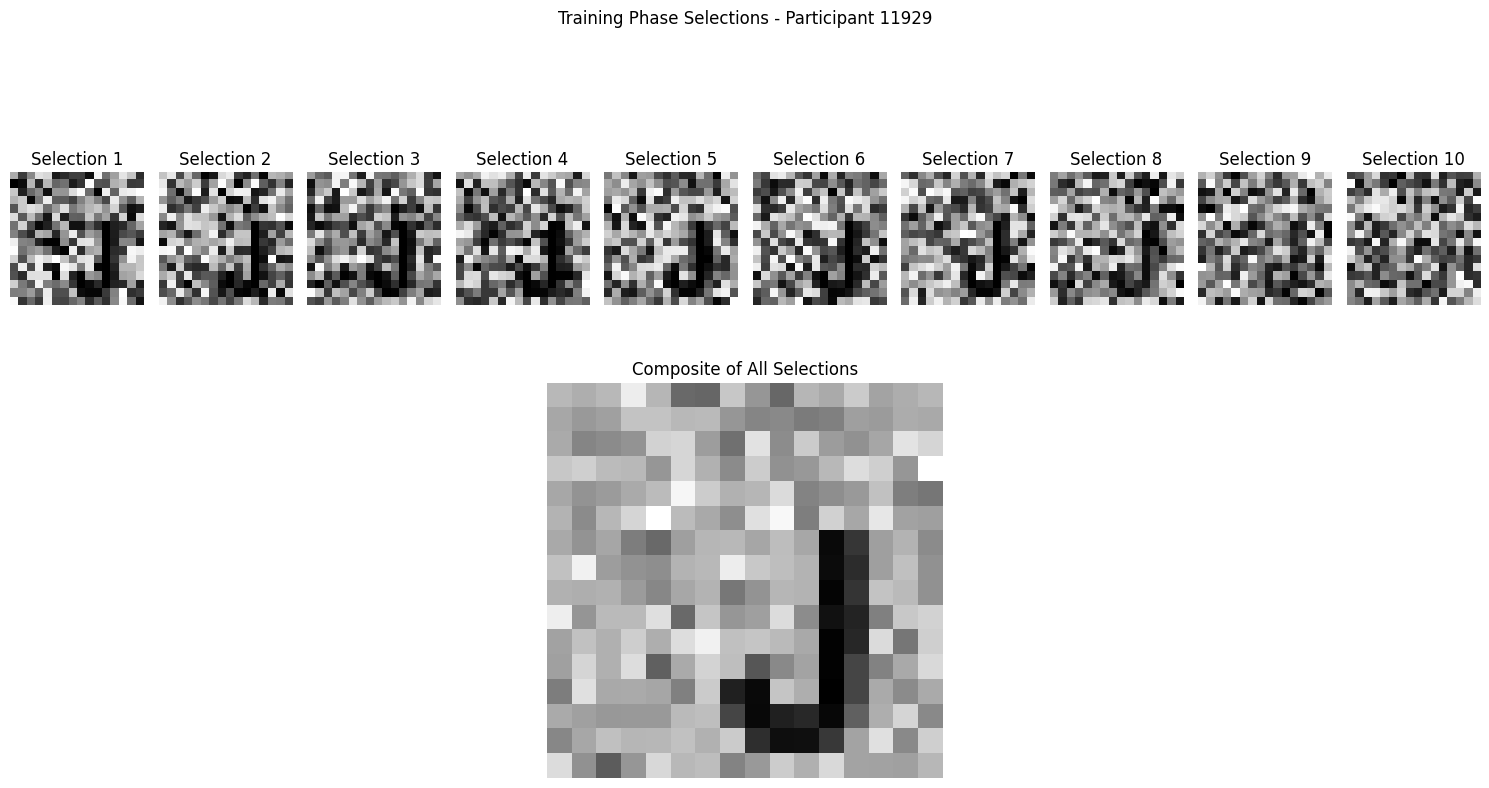

In [29]:
def create_compact_training_visualization(valid_results, participant_id):
    # Extract training data for the participant
    def extract_training_data(result):
        if ('training_phase' in result and 
            'trials' in result['training_phase'] and 
            result['metadata']['participant_id'] == participant_id):
            return [trial['selected_image'] for trial in result['training_phase']['trials'] 
                   if 'selected_image' in trial]
        return []

    # Get selections
    selections = []
    for result in valid_results:
        selections.extend(extract_training_data(result))
    
    if selections:
        n_selections = len(selections)
        # Calculate grid dimensions for selections
        n_cols = (n_selections + 1) // 2  # Add 1 for composite
        
        # Create figure with appropriate size
        fig = plt.figure(figsize=(12, 5))
        
        # Plot individual selections in 2 rows
        for idx, img_base64 in enumerate(selections):
            row = idx // n_cols
            col = idx % n_cols
            plt.subplot(2, n_cols + 1, col + 1 + row * (n_cols + 1))
            try:
                img = decode_base64_image(img_base64)
                plt.imshow(img.convert('L'), cmap='gray')
                plt.axis('off')
                plt.title(f'Selection {idx+1}', fontsize=8)
            except Exception as e:
                print(f"Error processing image {idx}: {str(e)}")
                continue
        
        # Create and plot composite on the right
        selected_images = []
        for img_base64 in selections:
            try:
                img = decode_base64_image(img_base64)
                selected_images.append(img)
            except:
                continue
                
        if selected_images:
            composite = create_composite_image(selected_images)
            plt.subplot(2, n_cols + 1, (n_cols + 1) * 2)
            plt.imshow(composite, cmap='gray')
            plt.axis('off')
            plt.title('Composite', fontsize=8)
        
        plt.suptitle(f'Training Phase Selections - Participant {participant_id}', fontsize=10)
        plt.tight_layout()
        plt.show()

# Try the visualization
visualize_training_selections_simple(valid_results, '11929')

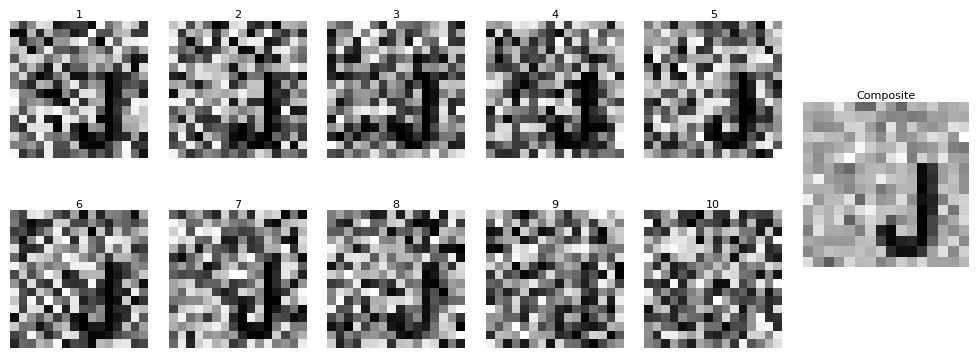

In [30]:
def create_compact_training_grid(valid_results, participant_id):
    # Extract training data
    selections = []
    for result in valid_results:
        if result['metadata']['participant_id'] == participant_id:
            if 'training_phase' in result and 'trials' in result['training_phase']:
                selections = [trial['selected_image'] for trial in result['training_phase']['trials'] 
                            if 'selected_image' in trial]
                break
    
    if selections:
        # Create a figure with a specific aspect ratio
        fig = plt.figure(figsize=(10, 4))
        
        # Calculate number of selections for grid layout
        n_selections = len(selections)
        n_per_row = n_selections // 2  # Split selections into 2 rows
        
        # Create grid: 2 rows for selections, last column for composite
        grid = plt.GridSpec(2, n_per_row + 1, width_ratios=[1]*n_per_row + [1.2])
        
        # Plot selections in first n_per_row columns
        for idx, img_base64 in enumerate(selections):
            row = idx // n_per_row
            col = idx % n_per_row
            ax = plt.subplot(grid[row, col])
            try:
                img = decode_base64_image(img_base64)
                ax.imshow(img.convert('L'), cmap='gray')
                ax.axis('off')
                ax.set_title(f'{idx+1}', fontsize=8, pad=2)
            except Exception as e:
                print(f"Error with image {idx}: {e}")
        
        # Create composite in last column, spanning both rows
        composite_ax = plt.subplot(grid[:, -1])
        selected_images = [decode_base64_image(img) for img in selections]
        if selected_images:
            composite = create_composite_image(selected_images)
            composite_ax.imshow(composite, cmap='gray')
            composite_ax.axis('off')
            composite_ax.set_title('Composite', fontsize=8, pad=2)
        
        plt.tight_layout(pad=1.5)
        plt.show()

# Run visualization
create_compact_training_grid(valid_results, '11929')

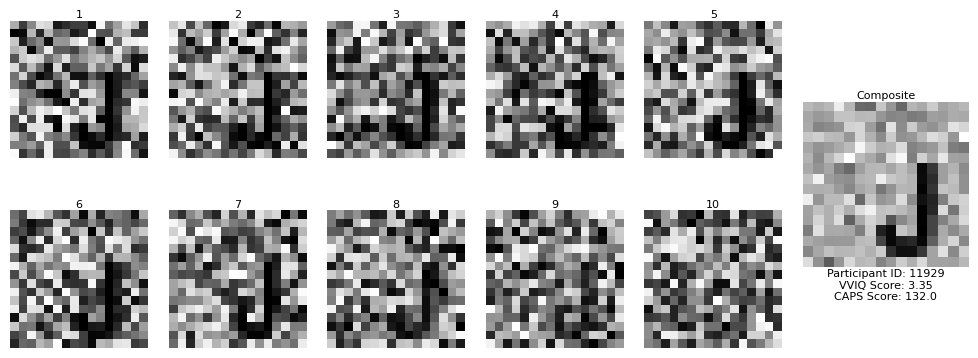

In [31]:
def create_compact_training_grid(valid_results, participant_id, vviq_summary, caps_summary):
    # Extract training data
    selections = []
    for result in valid_results:
        if result['metadata']['participant_id'] == participant_id:
            if 'training_phase' in result and 'trials' in result['training_phase']:
                selections = [trial['selected_image'] for trial in result['training_phase']['trials'] 
                            if 'selected_image' in trial]
                break
    
    if selections:
        # Get participant info
        vviq_score = vviq_summary.loc[participant_id, 'total_mean']
        caps_score = caps_summary.loc[participant_id, 'total_score']
        
        # Create a figure with a specific aspect ratio
        fig = plt.figure(figsize=(10, 4))
        
        # Calculate number of selections for grid layout
        n_selections = len(selections)
        n_per_row = n_selections // 2  # Split selections into 2 rows
        
        # Create grid: 2 rows for selections, last column for composite
        grid = plt.GridSpec(2, n_per_row + 1, width_ratios=[1]*n_per_row + [1.2])
        
        # Plot selections in first n_per_row columns
        for idx, img_base64 in enumerate(selections):
            row = idx // n_per_row
            col = idx % n_per_row
            ax = plt.subplot(grid[row, col])
            try:
                img = decode_base64_image(img_base64)
                ax.imshow(img.convert('L'), cmap='gray')
                ax.axis('off')
                ax.set_title(f'{idx+1}', fontsize=8, pad=2)
            except Exception as e:
                print(f"Error with image {idx}: {e}")
        
        # Create composite in last column, spanning both rows
        composite_ax = plt.subplot(grid[:, -1])
        selected_images = [decode_base64_image(img) for img in selections]
        if selected_images:
            composite = create_composite_image(selected_images)
            composite_ax.imshow(composite, cmap='gray')
            composite_ax.axis('off')
            composite_ax.set_title('Composite', fontsize=8, pad=2)
            
            # Add participant info below the composite
            info_text = f'Participant ID: {participant_id}\nVVIQ Score: {vviq_score:.2f}\nCAPS Score: {caps_score:.1f}'
            composite_ax.text(0.5, -0.2, info_text, 
                            fontsize=8, ha='center', 
                            transform=composite_ax.transAxes)
        
        plt.tight_layout(pad=1.5)
        plt.show()

# Run visualization
create_compact_training_grid(valid_results, '11929', vviq_summary, caps_summary)